In [2]:
import math
import numpy as np
import pandas as pd
import datetime
from scipy.interpolate import interp1d

import pyomo.environ as pyomo
import pulp

import os
import csv

import matplotlib
import matplotlib.pyplot as plt

In [3]:
pip install pulp

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Plot Options
plt.rcParams['font.family'] = 'serif'
plt.rcParams.update({'font.size': 16})
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.pad_inches'] = 0.5
plt.rcParams['axes.titlepad'] = 6.0
plt.rcParams['axes.labelpad'] = 2.0
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['figure.figsize'] = [12,6]
plt.rcParams['figure.dpi'] = 300
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['scatter.edgecolors'] = 'face'
#matplotlib.rcParams.update(matplotlib.rcParamsDefault)

In [5]:
fpath="./"
os.chdir(fpath)

In [6]:
# Load the data
route_schedule = pd.read_csv('./route1_schedule.csv',index_col=0)
forecasts = pd.read_csv('./day1_forecasts.csv')

# Display the loaded data for inspection
print("Route Schedule Data:")
print(route_schedule)

print("\nDay 1 Forecasts Data:")
print(forecasts.head())

Route Schedule Data:
                      A          B          C          D           E
measure                                                             
eco-energy    38.052326  83.549407  36.335986  59.921933   66.783968
eco-time      28.998297  55.916802  27.284668  51.815136   56.051256
fast-energy   38.459771  83.988776  40.386108  80.917812   73.990403
fast-time     27.675135  54.819251  26.525876  44.685524   44.965860
stop-time     20.000000  30.000000  40.000000  30.000000  480.000000
stop-charger   0.000000   0.000000   1.000000   0.000000    1.000000

Day 1 Forecasts Data:
   time     price  emissions
0     0  152.6668       1016
1     5  152.6668       1010
2    10  152.6668       1010
3    15  152.6668       1010
4    20  152.6668       1010


In [7]:
# Define initial parameters
# start_time_nominal = 6.5 * 60  # 6:30 AM in minutes
start_time_nominal = 2.5 * 60  # 2:30 AM in minutes
min_start_shift = 2 * 60 # time shift (minutes) to set min possible start time
max_start_shift = 2 * 60 # time shift (minutes) to set max possible start time
start_time_lower_bound = start_time_nominal - min_start_shift
start_time_upper_bound = start_time_nominal + max_start_shift
battery_capacity = 256  # kWh
min_soc = 0.10 * battery_capacity  # 10% SOC
max_soc = 0.90 * battery_capacity  # 90% SOC
initial_soc = max_soc

# Extract relevant data from route_schedule
eco_energy = route_schedule.iloc[0, :].dropna().values
eco_time = route_schedule.iloc[1, :].dropna().values
stop_times = route_schedule.iloc[4, :].dropna().values
can_charge = route_schedule.iloc[5, :].dropna().astype(bool).values

# Extract relevant grid data
electricity_price = forecasts['price'].values / 1000  # converting to $/kWh
carbon_intensity = forecasts['emissions'].values / 1000 # converting to kgCO2/kWh
time_index = forecasts['time'].values
#time_index = np.arange(0, len(forecasts) * 5, 5)

# Add extra datapoint at 1440
time_index = np.append(time_index, 1440)
electricity_price = np.append(electricity_price, electricity_price[-1])
carbon_intensity = np.append(carbon_intensity, carbon_intensity[-1])

# Setup function to interpolate original carbon data
f_interp = interp1d(time_index, carbon_intensity, kind='linear')

# Interpolate input data to get 1 minute resolution
time_index = np.arange(0, 1441)  # 0 to 1440 inclusive
electricity_price = np.repeat(electricity_price[:-1], 5)
electricity_price = np.append(electricity_price, electricity_price[-1])  # add the last value
carbon_intensity = f_interp(time_index)

# Initial energy list (cumulative energy consumption)
energy_list = np.cumsum(np.insert(eco_energy, 0, 0))

# Calculate the required charge
required_charge = energy_list[-1] - max_soc + min_soc

# Augmented energy list with stops
augmented_energy_list = []
for i in range(len(energy_list)):
    if i!=0:
        augmented_energy_list.append(energy_list[i])
    if i < len(energy_list) - 1:
        augmented_energy_list.append(energy_list[i])

# Augmented energy list with charging
# NOTE: Naive assumption that only one on-route charger is used
if required_charge > 0:
    for i in range(len(augmented_energy_list)):
        if i!=0 and i % 2 == 0 and can_charge[(i-1) // 2]:
            for j in range(i,len(augmented_energy_list)):
                augmented_energy_list[j] -= required_charge
            break

# Augmented energy list should end with 0 to indicate charging back to full
augmented_energy_list.append(0)

# Remaining energy list
remaining_energy_list = [max_soc-e for e in augmented_energy_list]

# Time list with stops
time_list = [0]
for i in range(len(eco_time)):
    time_list.append(time_list[-1] + eco_time[i])
    time_list.append(time_list[-1] + stop_times[i])

# Isolate charging time windows
charge_windows = []
for i in range(1,len(time_list)):
    if i % 2 == 0 and can_charge[(i-1) // 2]:
        charge_windows.append((time_list[i-1], time_list[i]))

# Ensure bounds are within acceptable limits
start_time_lower_bound = max(0, start_time_lower_bound)
start_time_upper_bound = min(1440 - time_list[-1], start_time_upper_bound)

# Verify the constructed lists
print("Time List:\n", time_list)
print("Augmented Energy List:\n", augmented_energy_list)
print("Remaining Energy List:\n", remaining_energy_list)
print("Charge Windows:\n",charge_windows)

Time List:
 [0, 28.9982971, 48.9982971, 104.91509930000001, 134.9150993, 162.1997676, 202.1997676, 254.01490330000001, 284.0149033, 340.0661595, 820.0661595]
Augmented Energy List:
 [0.0, 38.0523265, 38.0523265, 121.601733, 121.601733, 157.93771859999998, 78.09409849999997, 138.01603179999998, 138.01603179999998, 204.8, 0]
Remaining Energy List:
 [230.4, 192.3476735, 192.3476735, 108.79826700000001, 108.79826700000001, 72.46228140000002, 152.30590150000003, 92.38396820000003, 92.38396820000003, 25.599999999999994, 230.4]
Charge Windows:
 [(162.1997676, 202.1997676), (340.0661595, 820.0661595)]


In [8]:
# Save 1-minute interval data
time_index.tofile("./time_index.txt",sep="\n")
electricity_price.tofile("./electricity_price.txt",sep="\n")
carbon_intensity.tofile("./carbon_intensity.txt",sep="\n")

## Initial Plot

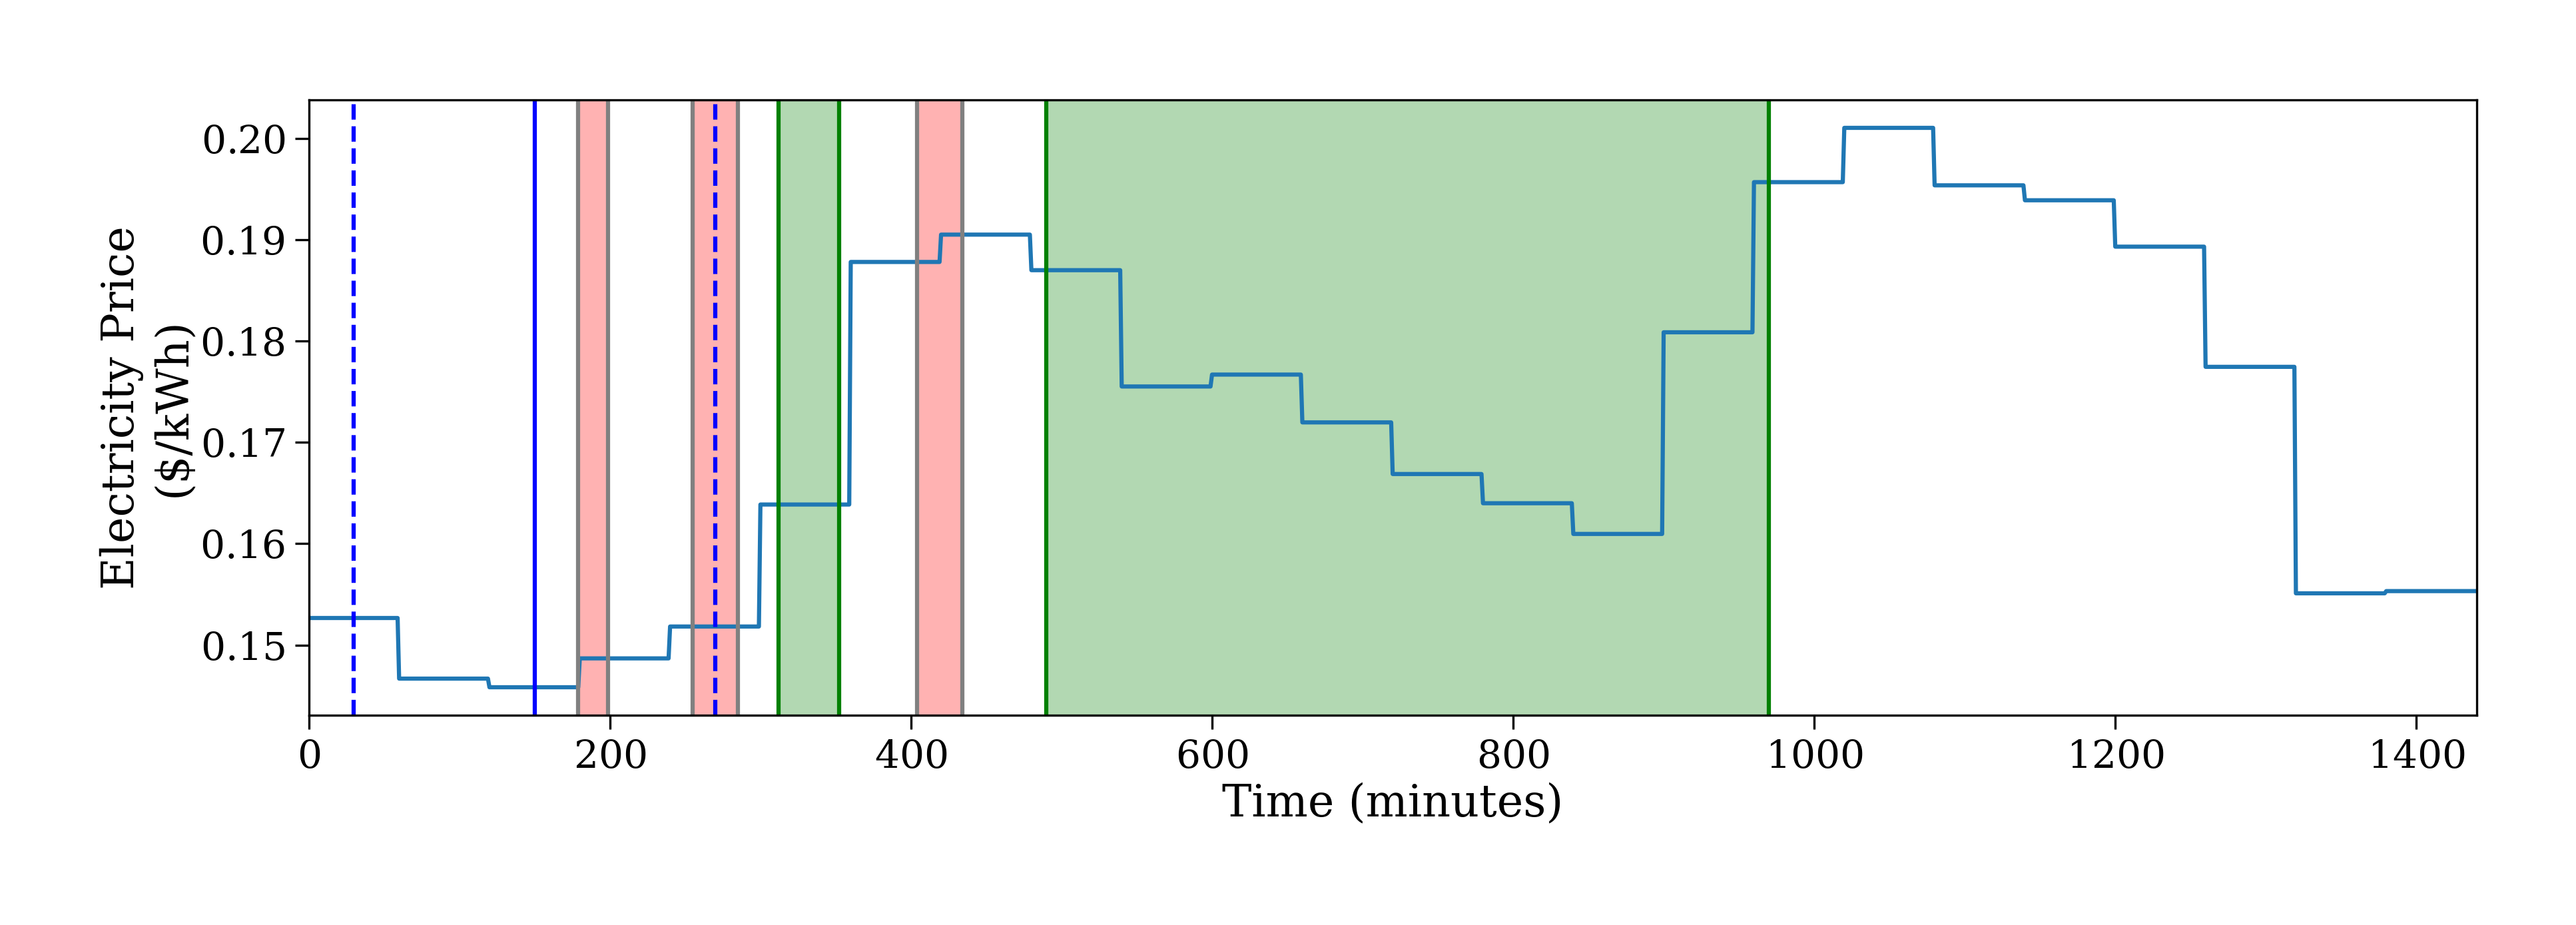

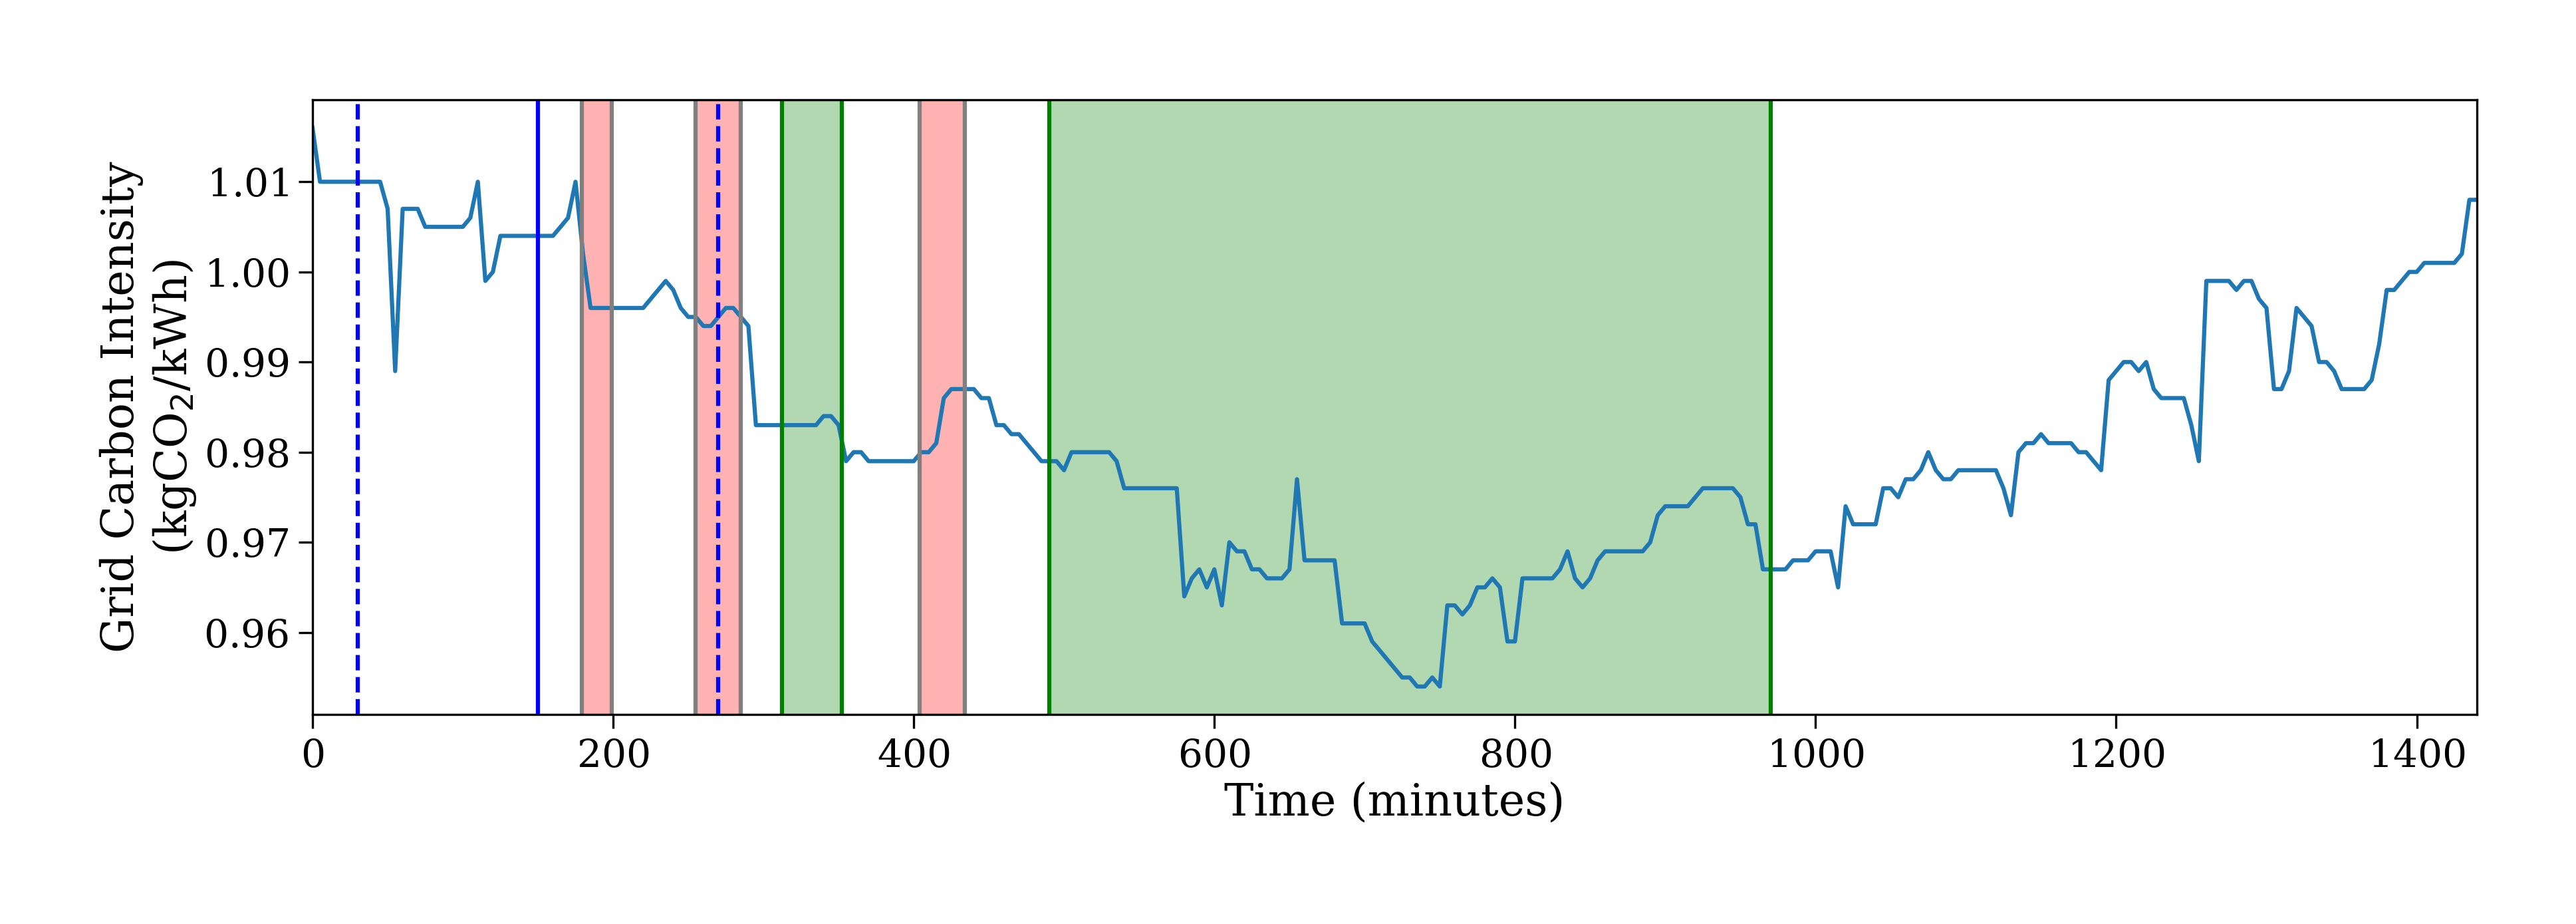

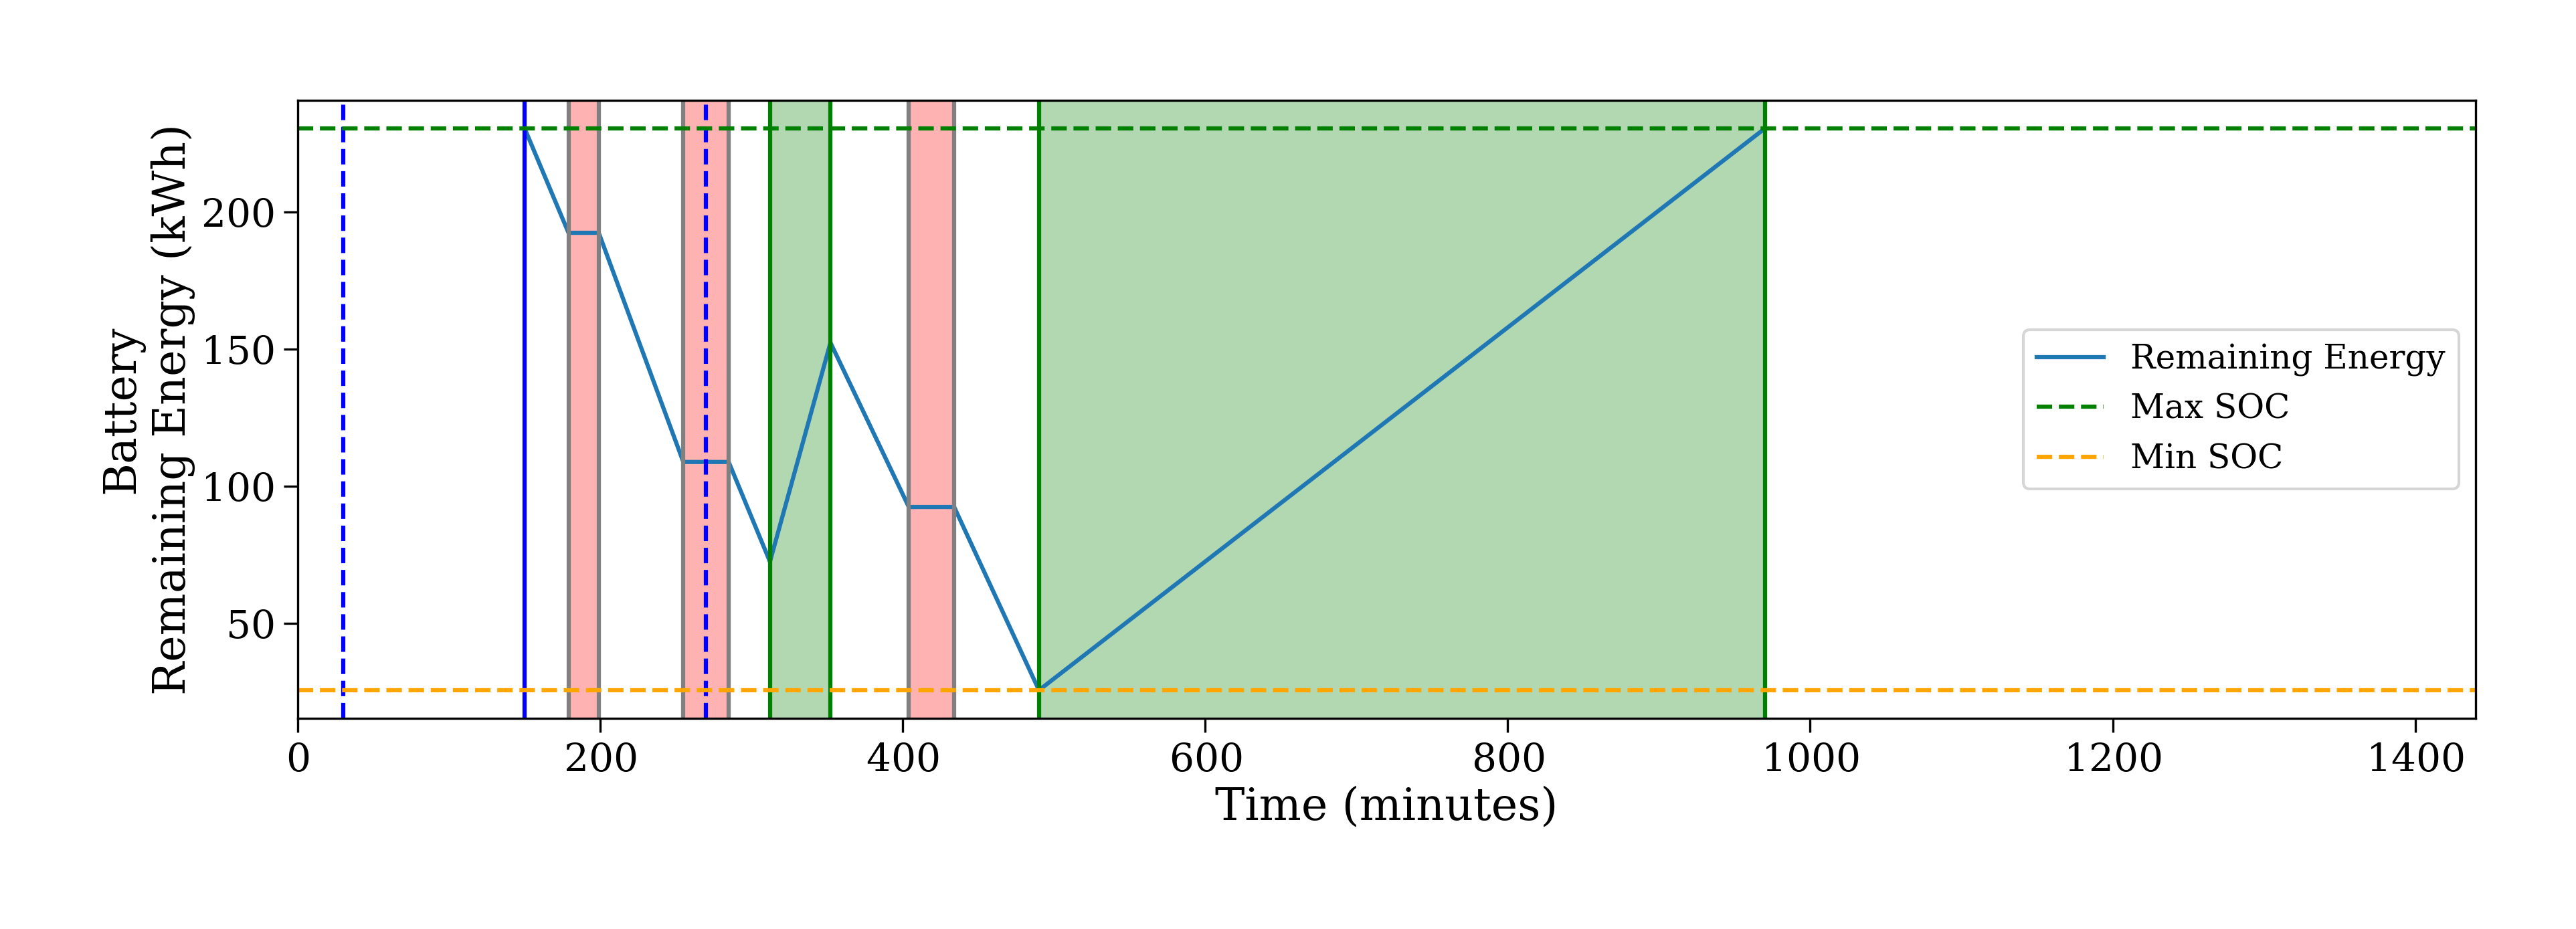

In [9]:
# Plot electricity price
fig1, ax1 = plt.subplots(figsize=(14, 4))
ax1.plot(time_index, electricity_price, label='Electricity Price')

# Mark transition points
for i in range(len(time_list)):
    if time_list[i] == 0:
        ax1.axvline(x=start_time_nominal + time_list[i], color='b', linestyle='-')
    elif can_charge[(i-1) // 2]:
        ax1.axvline(x=start_time_nominal + time_list[i], color='g', linestyle='-')
    else:
        ax1.axvline(x=start_time_nominal + time_list[i], color='grey', linestyle='-')
        if i % 2 == 0:
            ax1.axvspan(start_time_nominal + time_list[i-1], start_time_nominal + time_list[i], facecolor='red', alpha=0.3)
    if time_list[i] != 0 and i % 2 == 0 and can_charge[(i-1) // 2]:
        ax1.axvspan(start_time_nominal + time_list[i-1], start_time_nominal + time_list[i], facecolor='green', alpha=0.3)

# Mark bounds for start time
ax1.axvline(x=start_time_lower_bound, color='b', linestyle='--')
ax1.axvline(x=start_time_upper_bound, color='b', linestyle='--')

# Set labels
ax1.set_ylabel('Electricity Price\n($/kWh)')
ax1.set_xlabel('Time (minutes)')
ax1.set_xlim(0, 1440)

plt.show()

# Plot grid carbon intensity
fig2, ax2 = plt.subplots(figsize=(14, 4))
ax2.plot(time_index, carbon_intensity, label='Grid Carbon Intensity')

# Mark transition points
for i in range(len(time_list)):
    if time_list[i] == 0:
        ax2.axvline(x=start_time_nominal + time_list[i], color='b', linestyle='-')
    elif can_charge[(i-1) // 2]:
        ax2.axvline(x=start_time_nominal + time_list[i], color='g', linestyle='-')
    else:
        ax2.axvline(x=start_time_nominal + time_list[i], color='grey', linestyle='-')
        if i % 2 == 0:
            ax2.axvspan(start_time_nominal + time_list[i-1], start_time_nominal + time_list[i], facecolor='red', alpha=0.3)
    if time_list[i] != 0 and i % 2 == 0 and can_charge[(i-1) // 2]:
        ax2.axvspan(start_time_nominal + time_list[i-1], start_time_nominal + time_list[i], facecolor='green', alpha=0.3)

# Mark bounds for start time
ax2.axvline(x=start_time_lower_bound, color='b', linestyle='--')
ax2.axvline(x=start_time_upper_bound, color='b', linestyle='--')

# Set labels
ax2.set_ylabel('Grid Carbon Intensity\n(kgCO$_2$/kWh)')
ax2.set_xlabel('Time (minutes)')
ax2.set_xlim(0, 1440)

plt.show()

# Plot the final results for remaining battery energy
fig3, ax3 = plt.subplots(figsize=(14, 4))
ax3.plot([start_time_nominal + t for t in time_list], remaining_energy_list, label='Remaining Energy')

# Mark transition points and optimized charging windows
for i in range(len(time_list)):
    if time_list[i] == 0:
        ax3.axvline(x=start_time_nominal + time_list[i], color='b', linestyle='-')
    elif can_charge[(i-1) // 2]:
        ax3.axvline(x=start_time_nominal + time_list[i], color='g', linestyle='-')
    else:
        ax3.axvline(x=start_time_nominal + time_list[i], color='grey', linestyle='-')
        if i % 2 == 0:
            ax3.axvspan(start_time_nominal + time_list[i-1], start_time_nominal + time_list[i], facecolor='red', alpha=0.3)
    if time_list[i] != 0 and i % 2 == 0 and can_charge[(i-1) // 2]:
        ax3.axvspan(start_time_nominal + time_list[i-1], start_time_nominal + time_list[i], facecolor='green', alpha=0.3)

# Mark bounds for start time
ax3.axvline(x=start_time_lower_bound, color='b', linestyle='--')
ax3.axvline(x=start_time_upper_bound, color='b', linestyle='--')

# Plot
ax3.axhline(y=max_soc, color='g', linestyle='--', label='Max SOC')
ax3.axhline(y=min_soc, color='orange', linestyle='--', label='Min SOC')

# Set labels
ax3.set_ylabel('Battery\nRemaining Energy (kWh)')
ax3.set_xlabel('Time (minutes)')
ax3.set_xlim(0, 1440)
ax3.legend()

plt.show()

# Route Scheduling

## MIP Optimization

In [10]:
# Set hyperparameter
lambd = 0.18

# Print start time bounds
print('Nominal Start Time:', start_time_nominal)
print('Start Time Lower Bound:', start_time_lower_bound)
print('Start Time Upper Bound:', start_time_upper_bound)

# Setup dictionaries indexed on time
price_dict = dict(zip(time_index, electricity_price))
emission_dict = dict(zip(time_index, carbon_intensity))

# Create duration_dict with the time gap over which the current measure is valid
duration_dict = {t: 1/60 for t in time_index}

# Initialize optimization problem
prob = pulp.LpProblem("Schedule_Route_Start", pulp.LpMinimize)

# Declare time index variable
#time = pulp.LpVariable.dicts("t", time_index, cat='Continuous')

# Declare decision variable(s)
t0 = pulp.LpVariable("t0", lowBound=start_time_lower_bound, upBound=start_time_upper_bound, cat='Integer')
charge_window_dict = pulp.LpVariable.dicts("in_window", time_index, cat='Binary')

# Add objective function to problem first
prob += pulp.lpSum([charge_window_dict[t] * (price_dict[t] + lambd * emission_dict[t]) * duration_dict[t] for t in time_index])

# Create auxiliary binary variables for each charge window
charge_window_vars = {}
for i, (start, end) in enumerate(charge_windows):
    rounded_start = round(start)-0.001   # NOTE: count cost from first minute (change with -0.001)
    rounded_end = round(end)-0.001 # NOTE: do not count cost from extra minute (change with -0.001)
    charge_window_vars[i] = pulp.LpVariable.dicts(f"window_{i}", time_index, lowBound=0, upBound=1, cat='Binary')
    for t in time_index:
        # Create auxiliary variables to check if t is within the charge window
        within_window_start = pulp.LpVariable(f"within_window_start_{i}_{t}", cat='Binary')
        within_window_end = pulp.LpVariable(f"within_window_end_{i}_{t}", cat='Binary')

        prob += within_window_start <= (t - (rounded_start + t0)) / 1440 + 1
        prob += within_window_start >= (t - (rounded_start + t0)) / 1440

        prob += within_window_end <= ((rounded_end + t0) - t) / 1440 + 1
        prob += within_window_end >= ((rounded_end + t0) - t) / 1440

        prob += charge_window_vars[i][t] <= within_window_start
        prob += charge_window_vars[i][t] <= within_window_end
        prob += charge_window_vars[i][t] >= within_window_start + within_window_end - 1

# Combine charge window variables to determine if the time falls within any window
for t in time_index:
    prob += charge_window_dict[t] == pulp.lpSum([charge_window_vars[i][t] for i in range(len(charge_windows))])

# Option: set desired t0 to show computed cost
#prob += t0 == 130.

# Solve the problem
prob.solve()

# Get the optimized start time
optimized_start_time = pulp.value(t0)

print("\nLambda:", lambd)
print("Optimized Start Time:", optimized_start_time)

# Evaluate the total cost with the optimized values
optimized_total_cost = sum(
    pulp.value(charge_window_dict[t]) * (price_dict[t] + lambd * emission_dict[t]) * duration_dict[t]
    for t in time_index
)

print("Optimized Total Cost:", optimized_total_cost)

Nominal Start Time: 150.0
Start Time Lower Bound: 30.0
Start Time Upper Bound: 270.0
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l_/9_zfnc1528j4t0x96tq52wdh0000gn/T/30503bdeefd74395901fa9c74cf4c78b-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l_/9_zfnc1528j4t0x96tq52wdh0000gn/T/30503bdeefd74395901fa9c74cf4c78b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 21620 COLUMNS
At line 90791 RHS
At line 112407 BOUNDS
At line 122497 ENDATA
Problem MODEL has 21615 rows, 10088 columns and 47553 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.42 seconds
Cgl0003I 4 fixed, 0 tightened bounds, 135 strengthened rows, 808 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 0 strengthened rows, 76 substitutions
Cgl0003I 0 fix

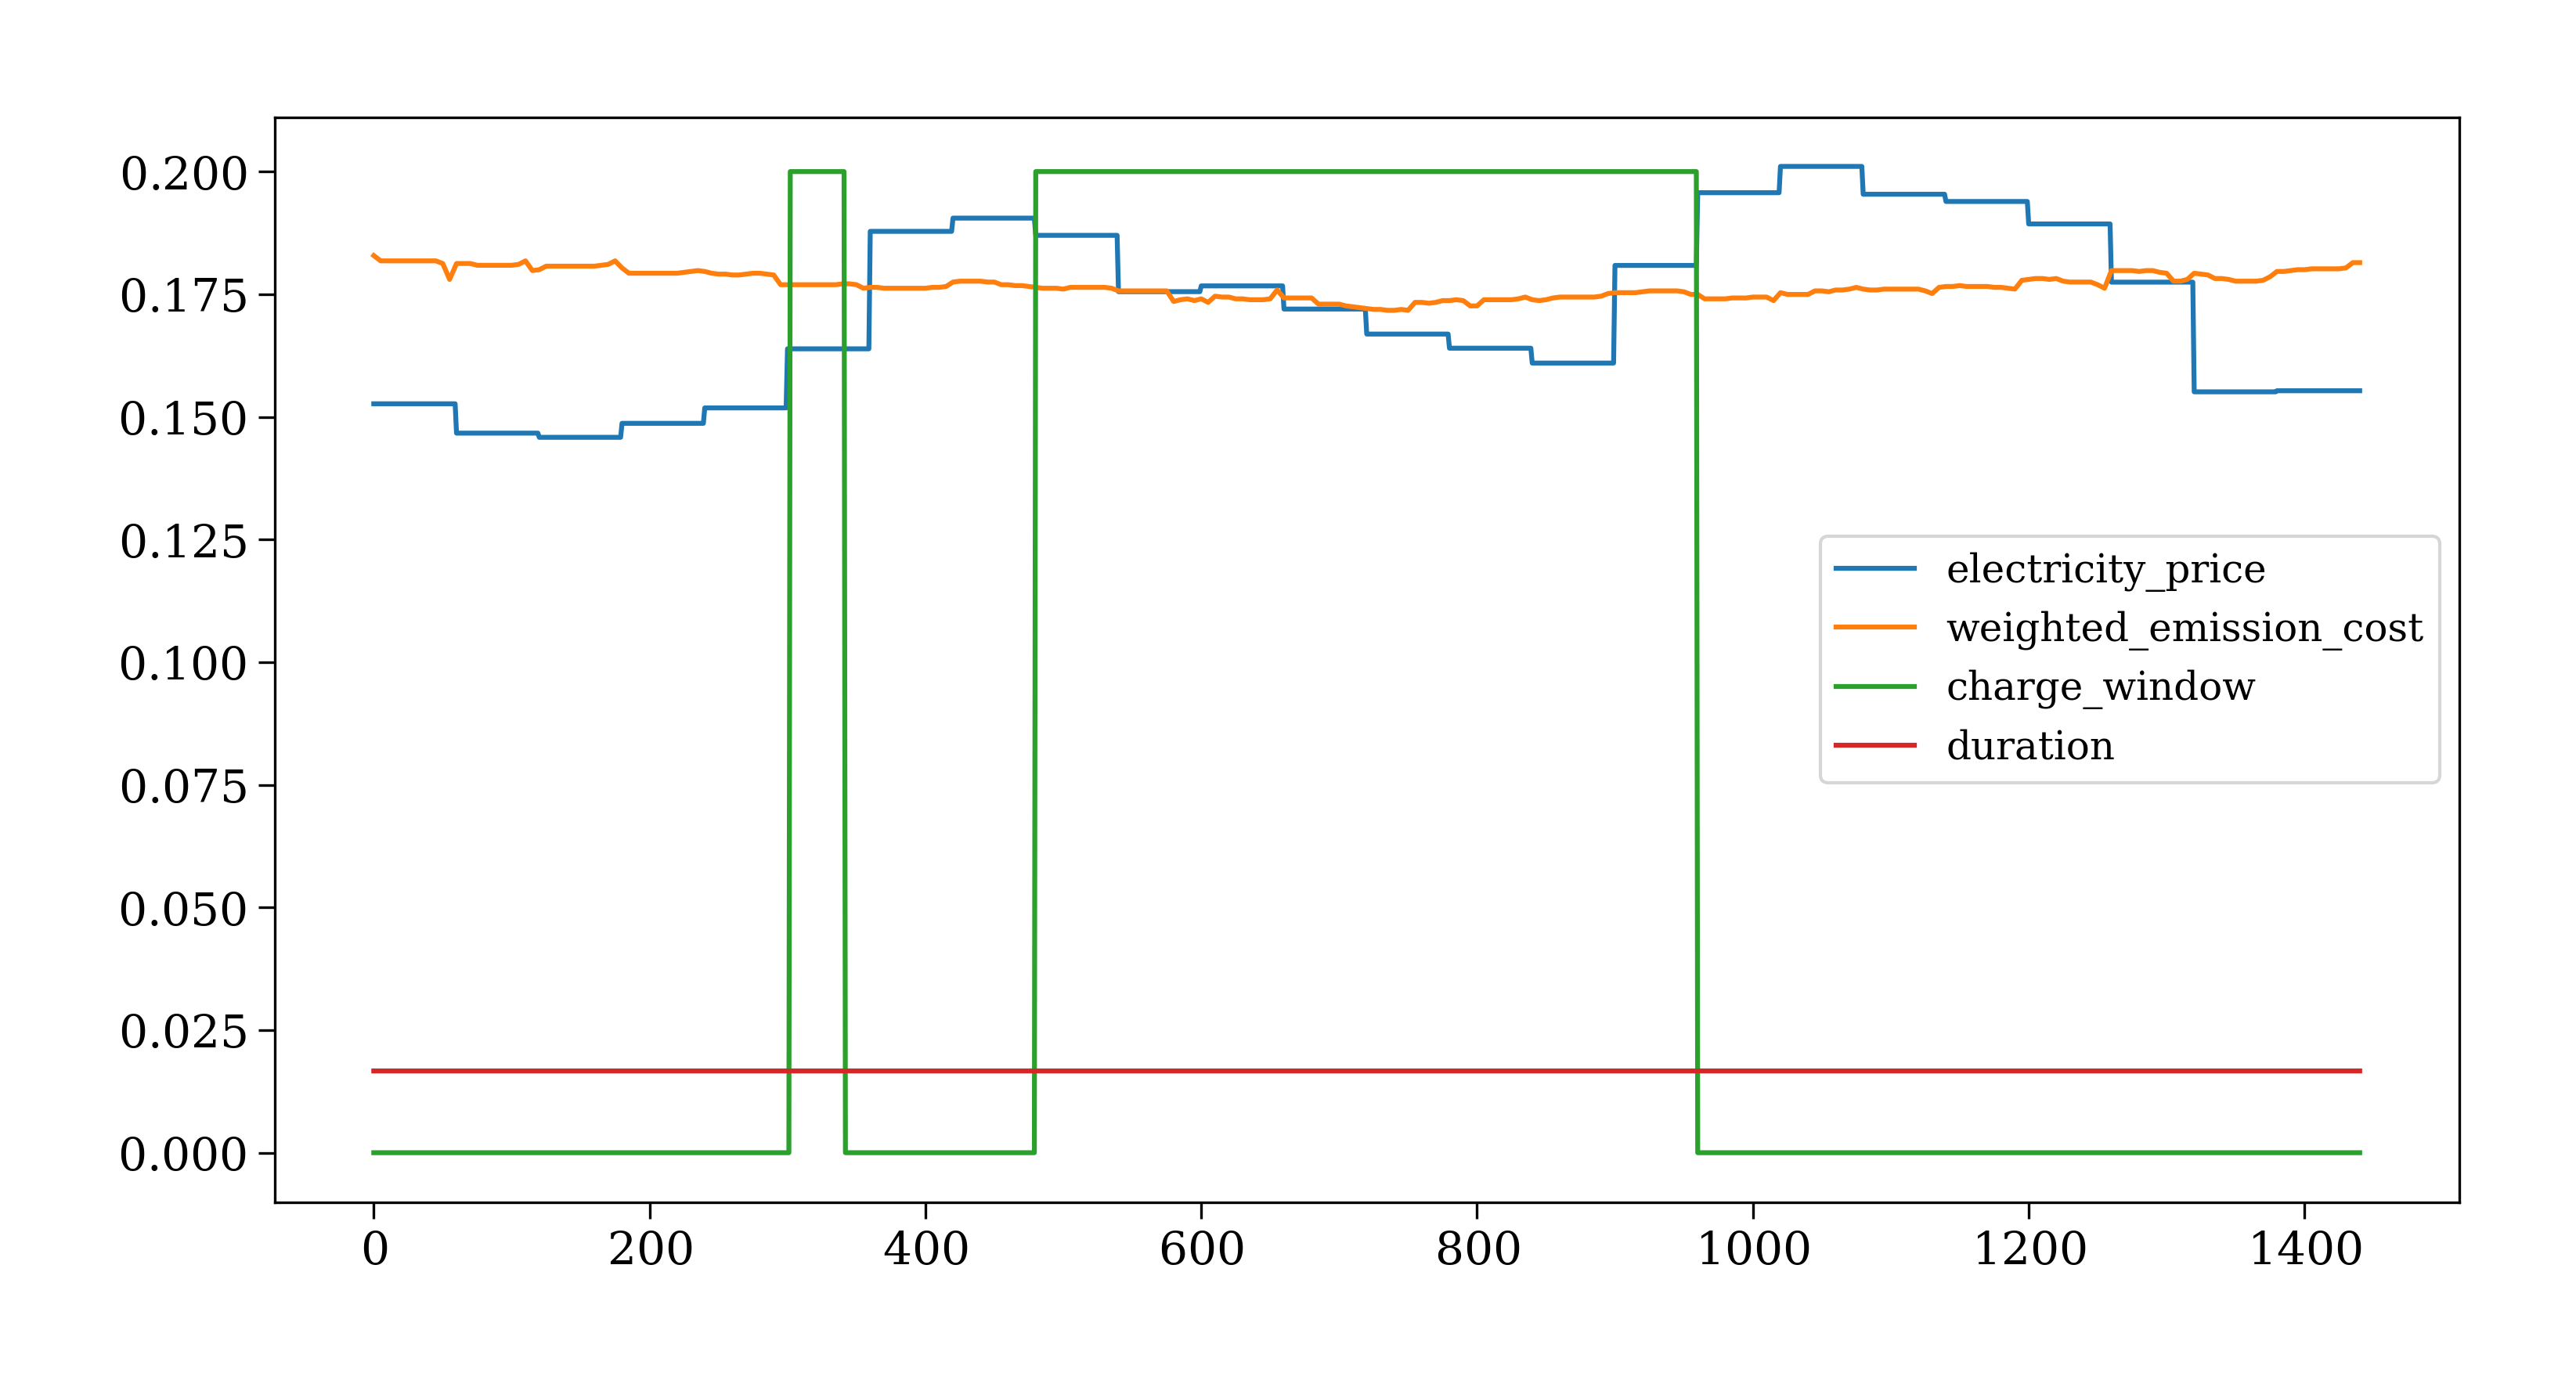

In [11]:
charge_flag = [pulp.value(charge_window_dict[t]) for t in time_index]

plt.plot(range(len(time_index)),[price_dict[t] for t in time_index],label='electricity_price')
plt.plot(range(len(time_index)),[lambd * emission_dict[t] for t in time_index],label='weighted_emission_cost')
plt.plot(range(len(time_index)),[charge_flag[t]*0.2 for t in time_index],label='charge_window')
plt.plot(range(len(time_index)),[duration_dict[t] for t in time_index],label='duration')
plt.legend()
plt.show()

## MIP Optimized Plots

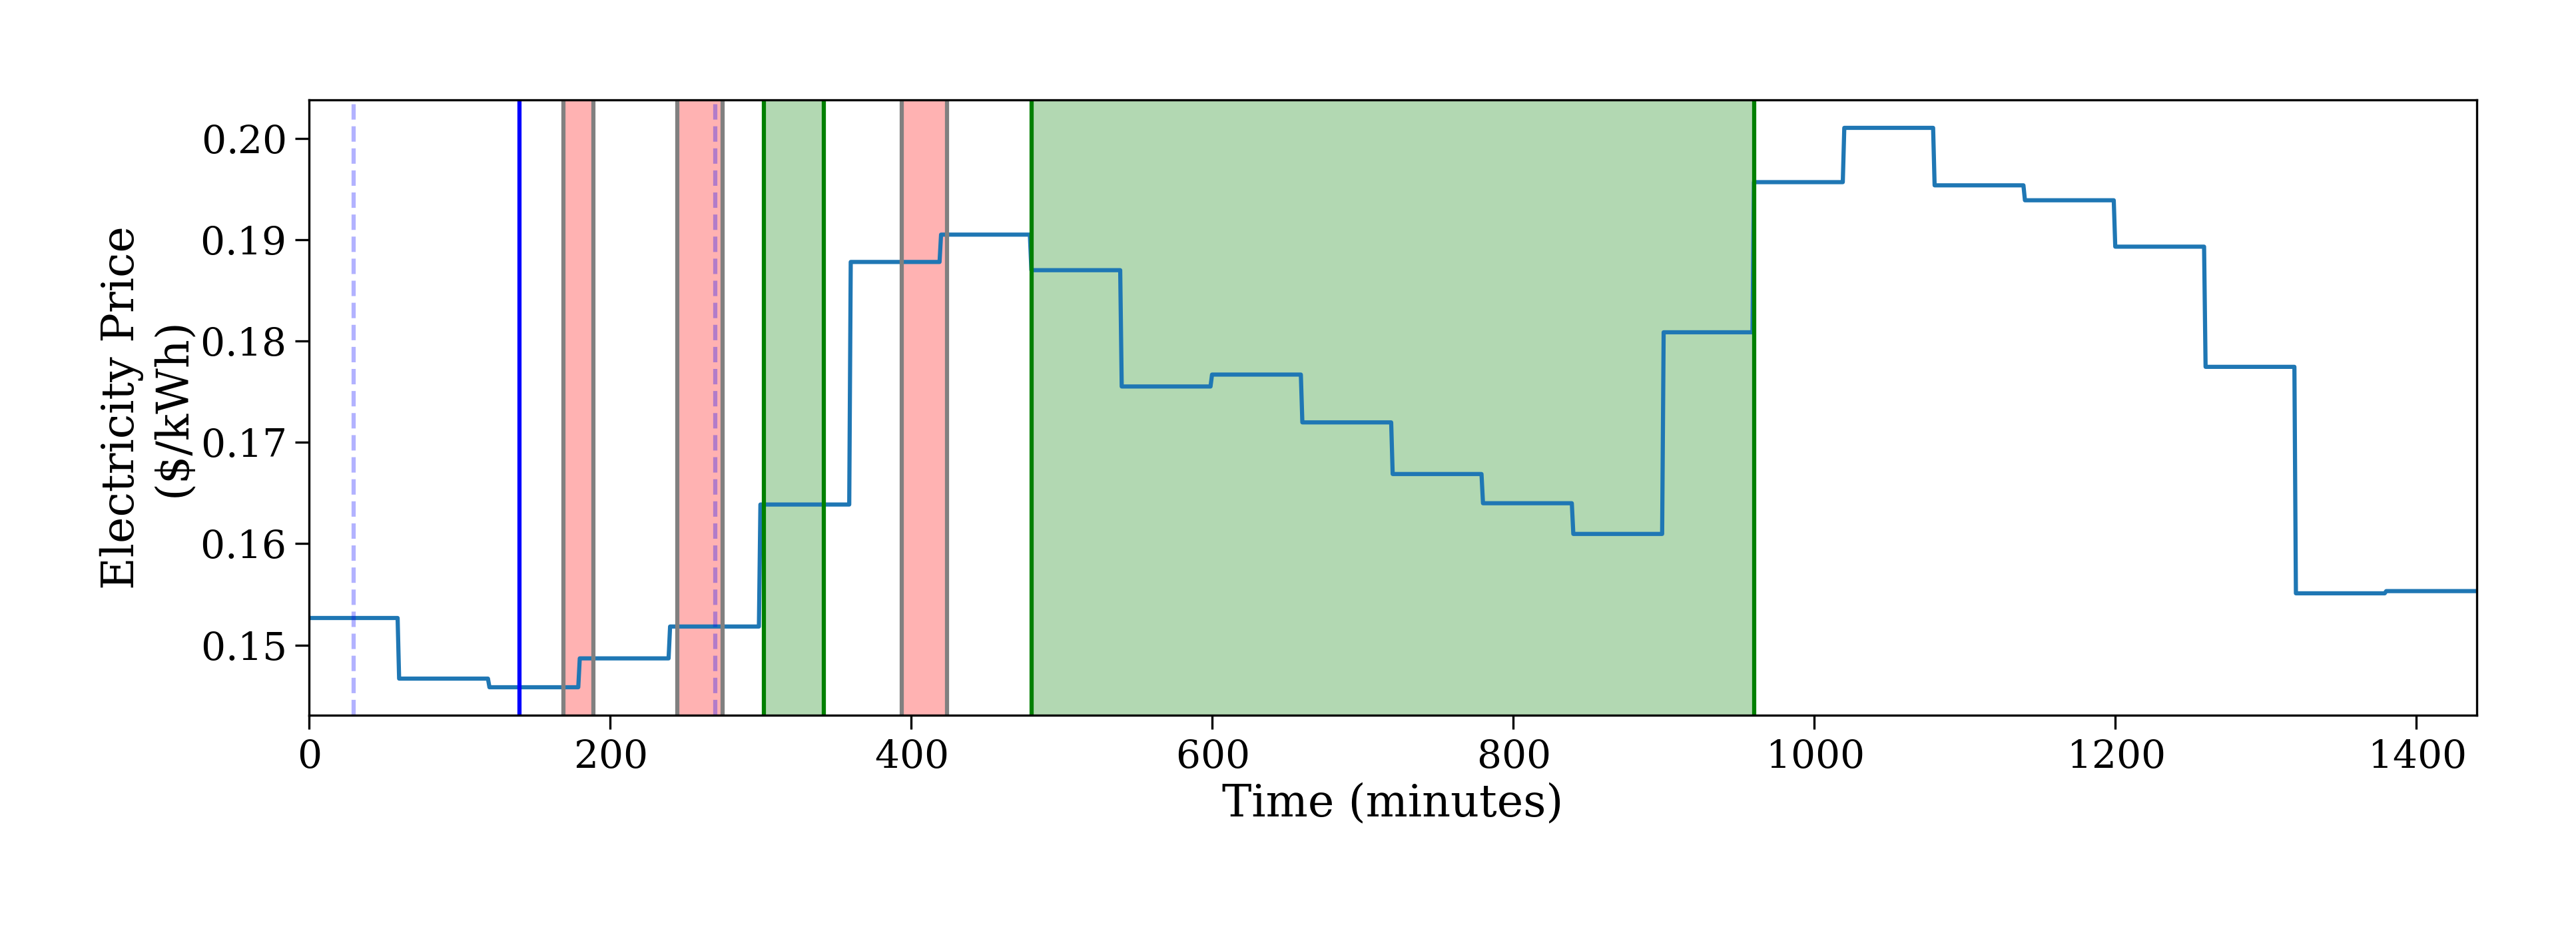

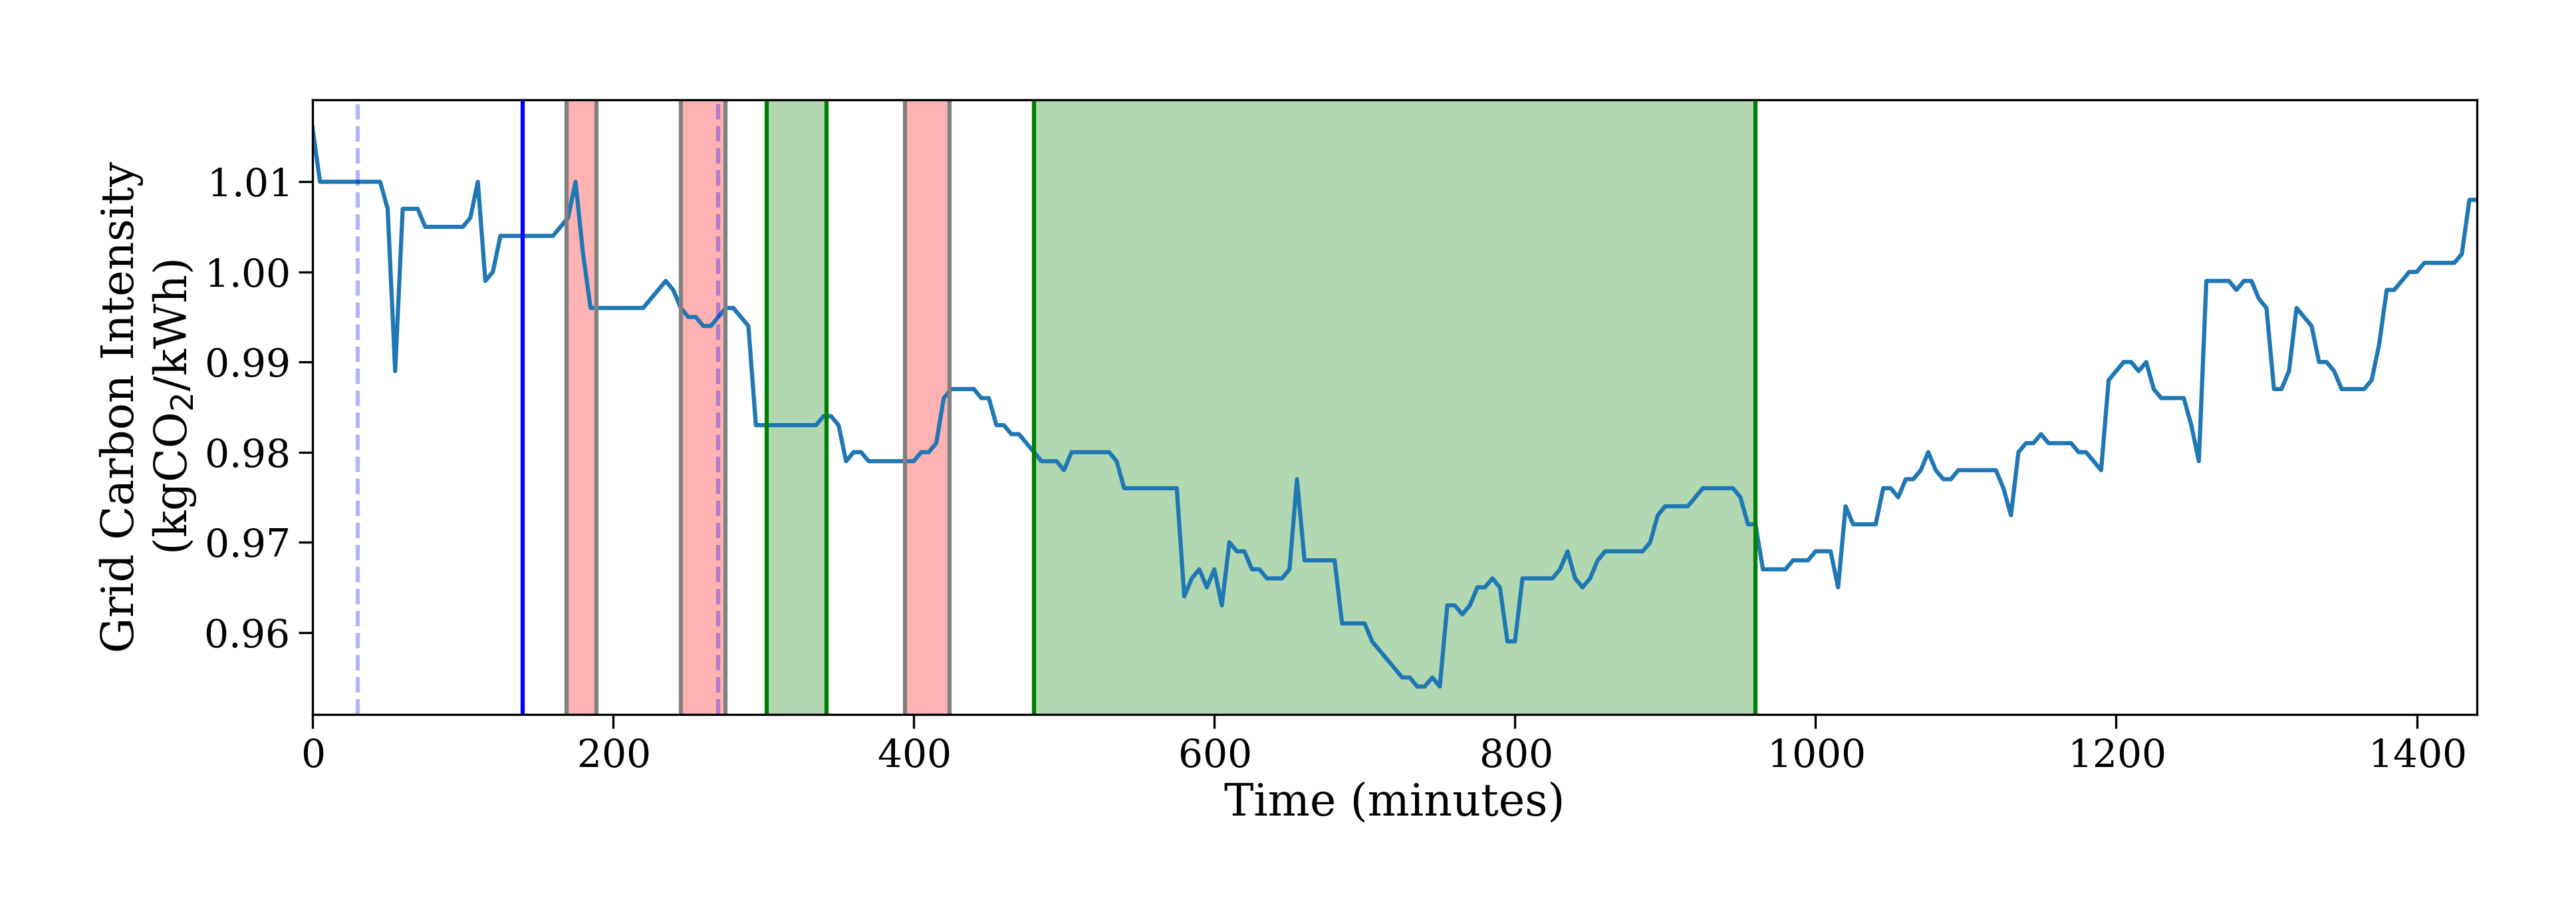

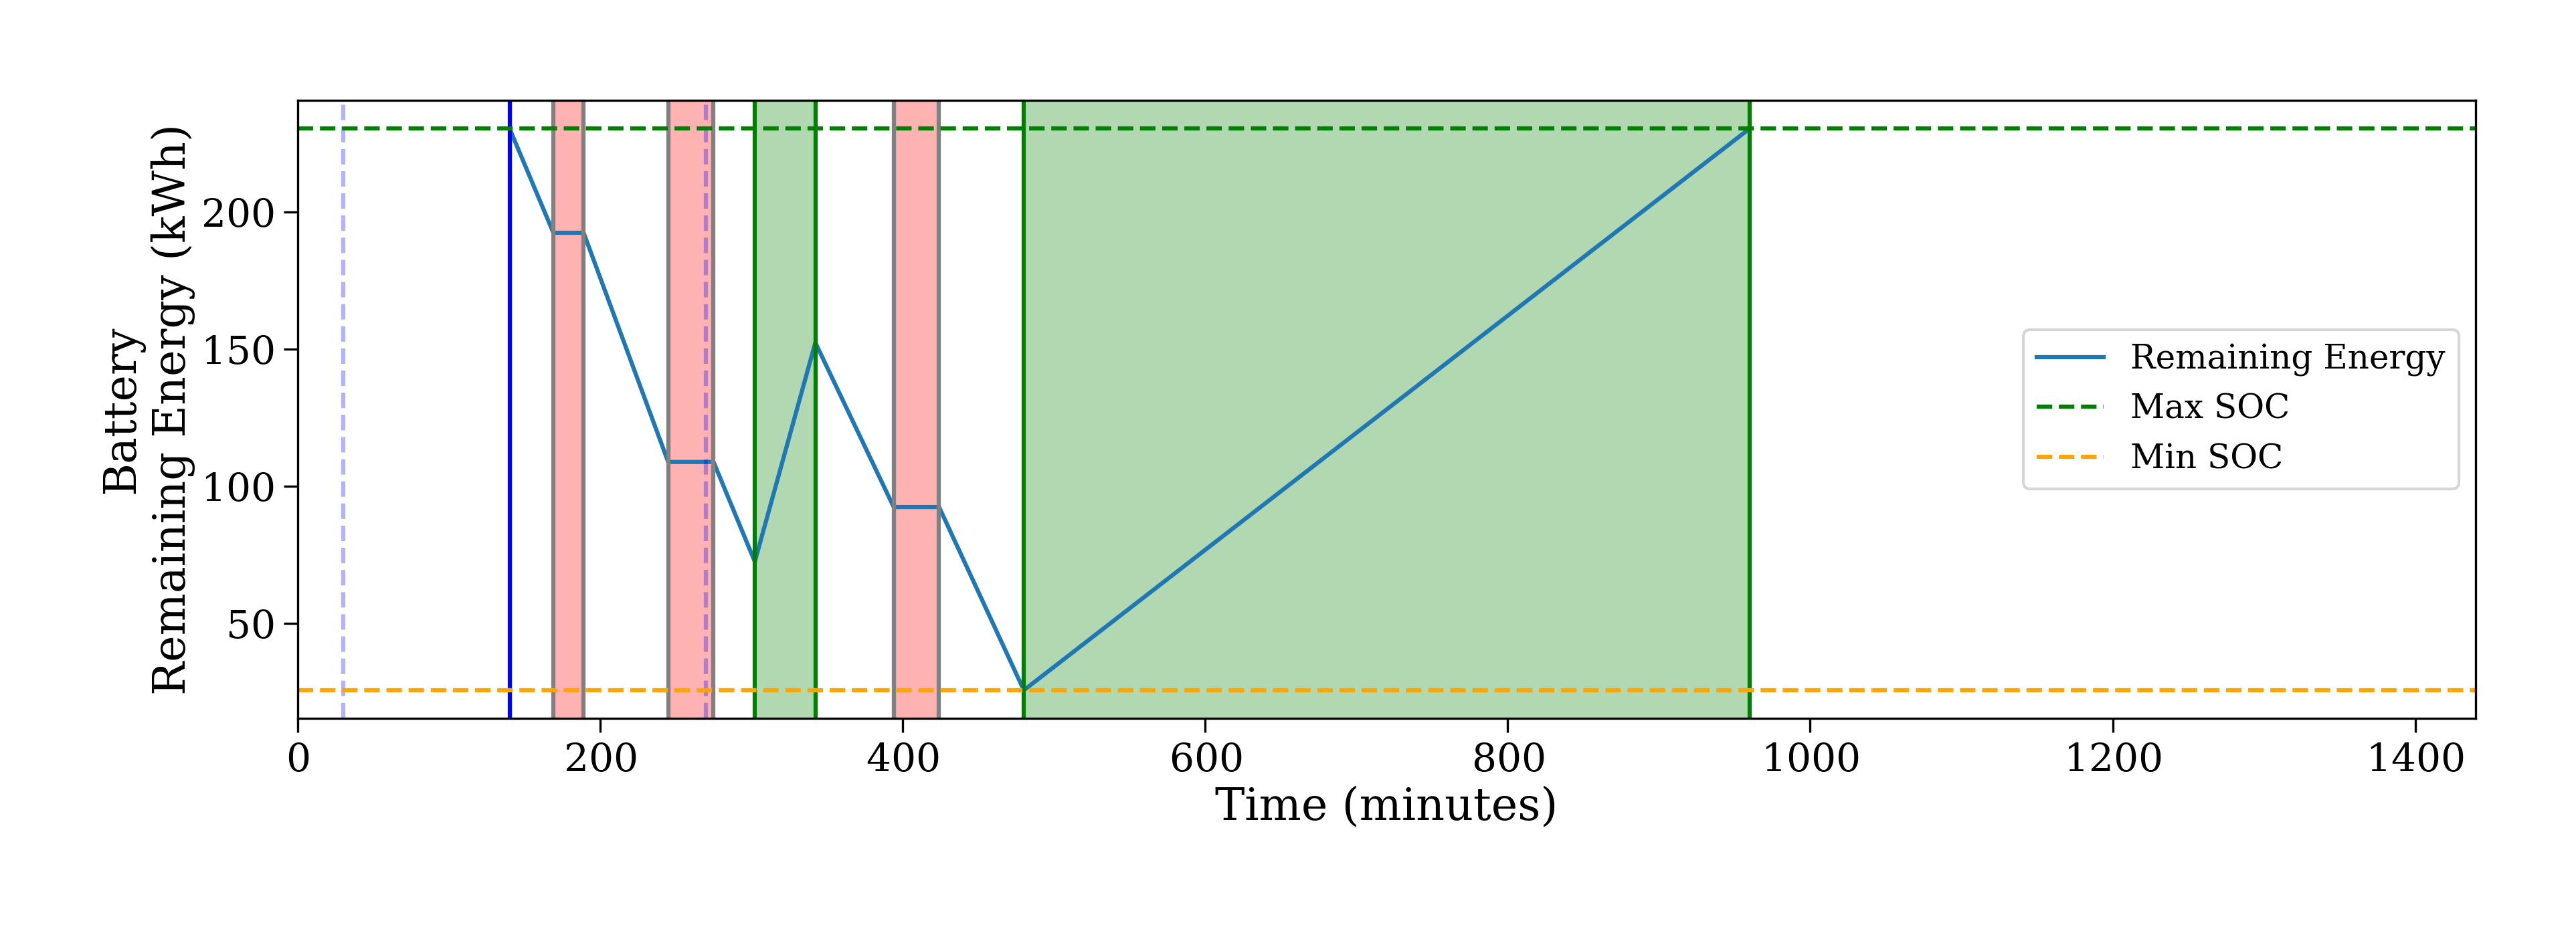

In [12]:
# Plot electricity price
fig1, ax1 = plt.subplots(figsize=(14, 4))
ax1.plot(time_index, electricity_price, label='Electricity Price')

# Mark transition points
for i in range(len(time_list)):
    if time_list[i] == 0:
        ax1.axvline(x=optimized_start_time + time_list[i], color='b', linestyle='-')
    elif can_charge[(i-1) // 2]:
        ax1.axvline(x=optimized_start_time + time_list[i], color='g', linestyle='-')
    else:
        ax1.axvline(x=optimized_start_time + time_list[i], color='grey', linestyle='-')
        if i % 2 == 0:
            ax1.axvspan(optimized_start_time + time_list[i-1], optimized_start_time + time_list[i], facecolor='red', alpha=0.3)
    if time_list[i] != 0 and i % 2 == 0 and can_charge[(i-1) // 2]:
        ax1.axvspan(optimized_start_time + time_list[i-1], optimized_start_time + time_list[i], facecolor='green', alpha=0.3)

# Mark bounds for start time
ax1.axvline(x=start_time_lower_bound, color='b', linestyle='--',alpha=0.3)
ax1.axvline(x=start_time_upper_bound, color='b', linestyle='--',alpha=0.3)

# Set labels
ax1.set_ylabel('Electricity Price\n($/kWh)')
ax1.set_xlabel('Time (minutes)')
ax1.set_xlim(0, 1440)

plt.show()

# Plot grid carbon intensity
fig2, ax2 = plt.subplots(figsize=(14, 4))
ax2.plot(time_index, carbon_intensity, label='Grid Carbon Intensity')

# Mark transition points
for i in range(len(time_list)):
    if time_list[i] == 0:
        ax2.axvline(x=optimized_start_time + time_list[i], color='b', linestyle='-')
    elif can_charge[(i-1) // 2]:
        ax2.axvline(x=optimized_start_time + time_list[i], color='g', linestyle='-')
    else:
        ax2.axvline(x=optimized_start_time + time_list[i], color='grey', linestyle='-')
        if i % 2 == 0:
            ax2.axvspan(optimized_start_time + time_list[i-1], optimized_start_time + time_list[i], facecolor='red', alpha=0.3)
    if time_list[i] != 0 and i % 2 == 0 and can_charge[(i-1) // 2]:
        ax2.axvspan(optimized_start_time + time_list[i-1], optimized_start_time + time_list[i], facecolor='green', alpha=0.3)

# Mark bounds for start time
ax2.axvline(x=start_time_lower_bound, color='b', linestyle='--',alpha=0.3)
ax2.axvline(x=start_time_upper_bound, color='b', linestyle='--',alpha=0.3)

# Set labels
ax2.set_ylabel('Grid Carbon Intensity\n(kgCO$_2$/kWh)')
ax2.set_xlabel('Time (minutes)')
ax2.set_xlim(0, 1440)

plt.show()

# Plot the final results for remaining battery energy
fig3, ax3 = plt.subplots(figsize=(14, 4))
ax3.plot([optimized_start_time + t for t in time_list], remaining_energy_list, label='Remaining Energy')

# Mark transition points and optimized charging windows
for i in range(len(time_list)):
    if time_list[i] == 0:
        ax3.axvline(x=optimized_start_time + time_list[i], color='b', linestyle='-')
    elif can_charge[(i-1) // 2]:
        ax3.axvline(x=optimized_start_time + time_list[i], color='g', linestyle='-')
    else:
        ax3.axvline(x=optimized_start_time + time_list[i], color='grey', linestyle='-')
        if i % 2 == 0:
            ax3.axvspan(optimized_start_time + time_list[i-1], optimized_start_time + time_list[i], facecolor='red', alpha=0.3)
    if time_list[i] != 0 and i % 2 == 0 and can_charge[(i-1) // 2]:
        ax3.axvspan(optimized_start_time + time_list[i-1], optimized_start_time + time_list[i], facecolor='green', alpha=0.3)

# Mark bounds for start time
ax3.axvline(x=start_time_lower_bound, color='b', linestyle='--',alpha=0.3)
ax3.axvline(x=start_time_upper_bound, color='b', linestyle='--',alpha=0.3)

# Plot
ax3.axhline(y=max_soc, color='g', linestyle='--', label='Max SOC')
ax3.axhline(y=min_soc, color='orange', linestyle='--', label='Min SOC')

# Set labels
ax3.set_ylabel('Battery\nRemaining Energy (kWh)')
ax3.set_xlabel('Time (minutes)')
ax3.set_xlim(0, 1440)
ax3.legend()

plt.show()

## Brute Force Check

In [13]:
# Set hyperparameter
lambd = 0.18

# Define the range of possible start times
print('Nominal Start Time:', start_time_nominal)
print('Start Time Lower Bound:', start_time_lower_bound)
print('Start Time Upper Bound:', start_time_upper_bound)

delta_t = 1 # 1-minute intervals
possible_start_times = np.arange(start_time_lower_bound, start_time_upper_bound + 1, delta_t)  # 1-minute intervals
#possible_start_times = [270]

# Interpolate carbon intensity
carbon_intensity_interp = interp1d(time_index, carbon_intensity, kind='linear', fill_value="extrapolate")

# Initialize variables to store the optimal start time and its cost
optimal_start_time = None
optimal_rounded_start_time = None
minimal_cost = float('inf')
minimal_rounded_cost = float('inf')

# Brute-force search over possible start times
for start_time in possible_start_times:
    total_cost = 0
    total_rounded_cost = 0

    for (start, end) in charge_windows:
        start_time_adjusted = start_time + start
        end_time_adjusted = start_time + end
        start_time_rounded = round(start_time) + round(start)   # NOTE: count cost from first minute (change with -0.001?)
        end_time_rounded = round(start_time) + round(end) # NOTE: do not count cost from extra minute (change with +/-0.001?)

        # Ensure we are within the bounds of the time_index
        if start_time_adjusted >= time_index[-1] or end_time_adjusted <= time_index[0]:
            continue

        # Calculate the cost within the charging window
        while start_time_adjusted < end_time_adjusted:
            next_interval = start_time_adjusted + delta_t # 1-minute intervals
            if next_interval > end_time_adjusted:
                next_interval = end_time_adjusted

            # Electricity price is constant within each hour
            current_price_interval = int(start_time_adjusted // delta_t) # 1-minute intervals
            price = electricity_price[current_price_interval]

            # Carbon intensity (interpolated)
            carbon_start = carbon_intensity_interp(start_time_adjusted)
            carbon_end = carbon_intensity_interp(next_interval)
            avg_carbon = (carbon_start + carbon_end) / 2

            # Duration of this segment
            duration = (next_interval - start_time_adjusted) / 60  # converting to hours

            # Incremental cost
            total_cost += (price + lambd * avg_carbon) * duration

            start_time_adjusted = next_interval

        # Calculate the cost within the rounded charging window
        while start_time_rounded < end_time_rounded:
            next_interval = start_time_rounded + delta_t # 1-minute intervals
            if next_interval >= end_time_rounded:
                next_interval = end_time_rounded

            # Electricity price is constant within each hour
            current_price_interval = int(start_time_rounded // delta_t) # 1-minute intervals
            price = electricity_price[current_price_interval]

            # Carbon intensity (interpolated)
            carbon_start = carbon_intensity_interp(start_time_rounded)
            carbon_end = carbon_intensity_interp(next_interval)
            avg_carbon = (carbon_start + carbon_end) / 2

            # Duration of this segment
            duration = (next_interval - start_time_rounded) / 60  # converting to hours

            # Incremental cost
            #print(f"Cost at {start_time_rounded}:",(price + lambd * avg_carbon) * duration)
            total_rounded_cost += (price + lambd * avg_carbon) * duration

            start_time_rounded = next_interval

    # Update the optimal start time if the current total cost is lower
    if total_cost < minimal_cost:
        minimal_cost = total_cost
        optimal_start_time = start_time
    if total_rounded_cost < minimal_rounded_cost:
        minimal_rounded_cost = total_rounded_cost
        optimal_rounded_start_time = start_time

# Optimal charge windows
optimal_charge_windows = []
optimal_rounded_charge_windows = []
for i,(start, end) in enumerate(charge_windows):
    start_time_adjusted = optimal_start_time + start
    end_time_adjusted = optimal_start_time + end
    optimal_charge_windows.append((start_time_adjusted,end_time_adjusted))

    start_time_rounded = optimal_rounded_start_time + round(start)
    end_time_rounded = optimal_rounded_start_time + round(end)
    optimal_rounded_charge_windows.append((start_time_rounded,end_time_rounded))

print("\nLambda:", lambd)
print("\nOptimal Start Time:", optimal_start_time)
print("Optimal Charge Windows:", optimal_charge_windows)
print("Minimal Cost:", minimal_cost)
print("\nOptimal Rounded-Cost Start Time:",optimal_rounded_start_time)
print("Optimal Rounded Charge Windows:", optimal_rounded_charge_windows)
print("Minimal Rounded Cost:", minimal_rounded_cost)

Nominal Start Time: 150.0
Start Time Lower Bound: 30.0
Start Time Upper Bound: 270.0

Lambda: 0.18

Optimal Start Time: 140.0
Optimal Charge Windows: [(302.1997676, 342.1997676), (480.0661595, 960.0661595)]
Minimal Cost: 3.005999472083405

Optimal Rounded-Cost Start Time: 140.0
Optimal Rounded Charge Windows: [(302.0, 342.0), (480.0, 960.0)]
Minimal Rounded Cost: 3.006000540000004


In [14]:
charge_flag_brute = [0]*1440
decharge_flag_brute = [0]*1440
for i in range(len(charge_flag_brute)):
    for (a,b) in optimal_rounded_charge_windows:
        if i > a and i < b:
            charge_flag_brute[i] = 1

baselien_d_t = [0]*1440
baselien_c_t = [0]*1440
for i in range(len(baselien_c_t)):
    for (a,b) in charge_windows:
        if i > a and i < b:
            baselien_c_t[i] = 1

# Define parameters
eta_c = 0.9  # charging efficiency
eta_d = 0.5  # discharging efficiency
lambd = 0.18  # weight for carbon intensity
C_deg = 0.01  # degradation cost coefficient
SOC_min = 0.1 * battery_capacity  # minimum SOC
SOC_max = 0.9 * battery_capacity  # maximum SOC
max_charge_power = 50  # kW, maximum charging power
max_discharge_power = 50  # kW, maximum discharging power
C_c_max = 1000  # kVA, maximum capacity of the transformer
delta_t = 1  # minutes, time step size

p_t = electricity_price  # electricity price at each time step
print(p_t)
g_t = carbon_intensity  # grid carbon intensity at each time step

def calculate_electricity_cost(c_t, d_t, p_t, g_t, eta_c, eta_d, lambd, C_deg, delta_t):
    electricity_cost = []
    total_cost = 0
    for t in range(1440):
        cost_at_t = (p_t[t] * (50 * c_t[t] * eta_c - 50 *d_t[t] * eta_d)) * (delta_t / 60)
        cost_at_t += C_deg * d_t[t]
        total_cost += cost_at_t
        electricity_cost.append(total_cost)
    return  electricity_cost

brute_day_long_elec = calculate_electricity_cost(charge_flag_brute, decharge_flag_brute , p_t, g_t, eta_c, eta_d, lambd, C_deg, delta_t)
mlp_day_long_elec = calculate_electricity_cost(charge_flag, decharge_flag_brute , p_t, g_t, eta_c, eta_d, lambd, C_deg, delta_t)
base_day_long_elec = calculate_electricity_cost(baselien_c_t, baselien_d_t , p_t, g_t, eta_c, eta_d, lambd, C_deg, delta_t)


len(brute_day_long_elec)

[0.1526668  0.1526668  0.1526668  ... 0.15532239 0.15532239 0.15532239]


1440

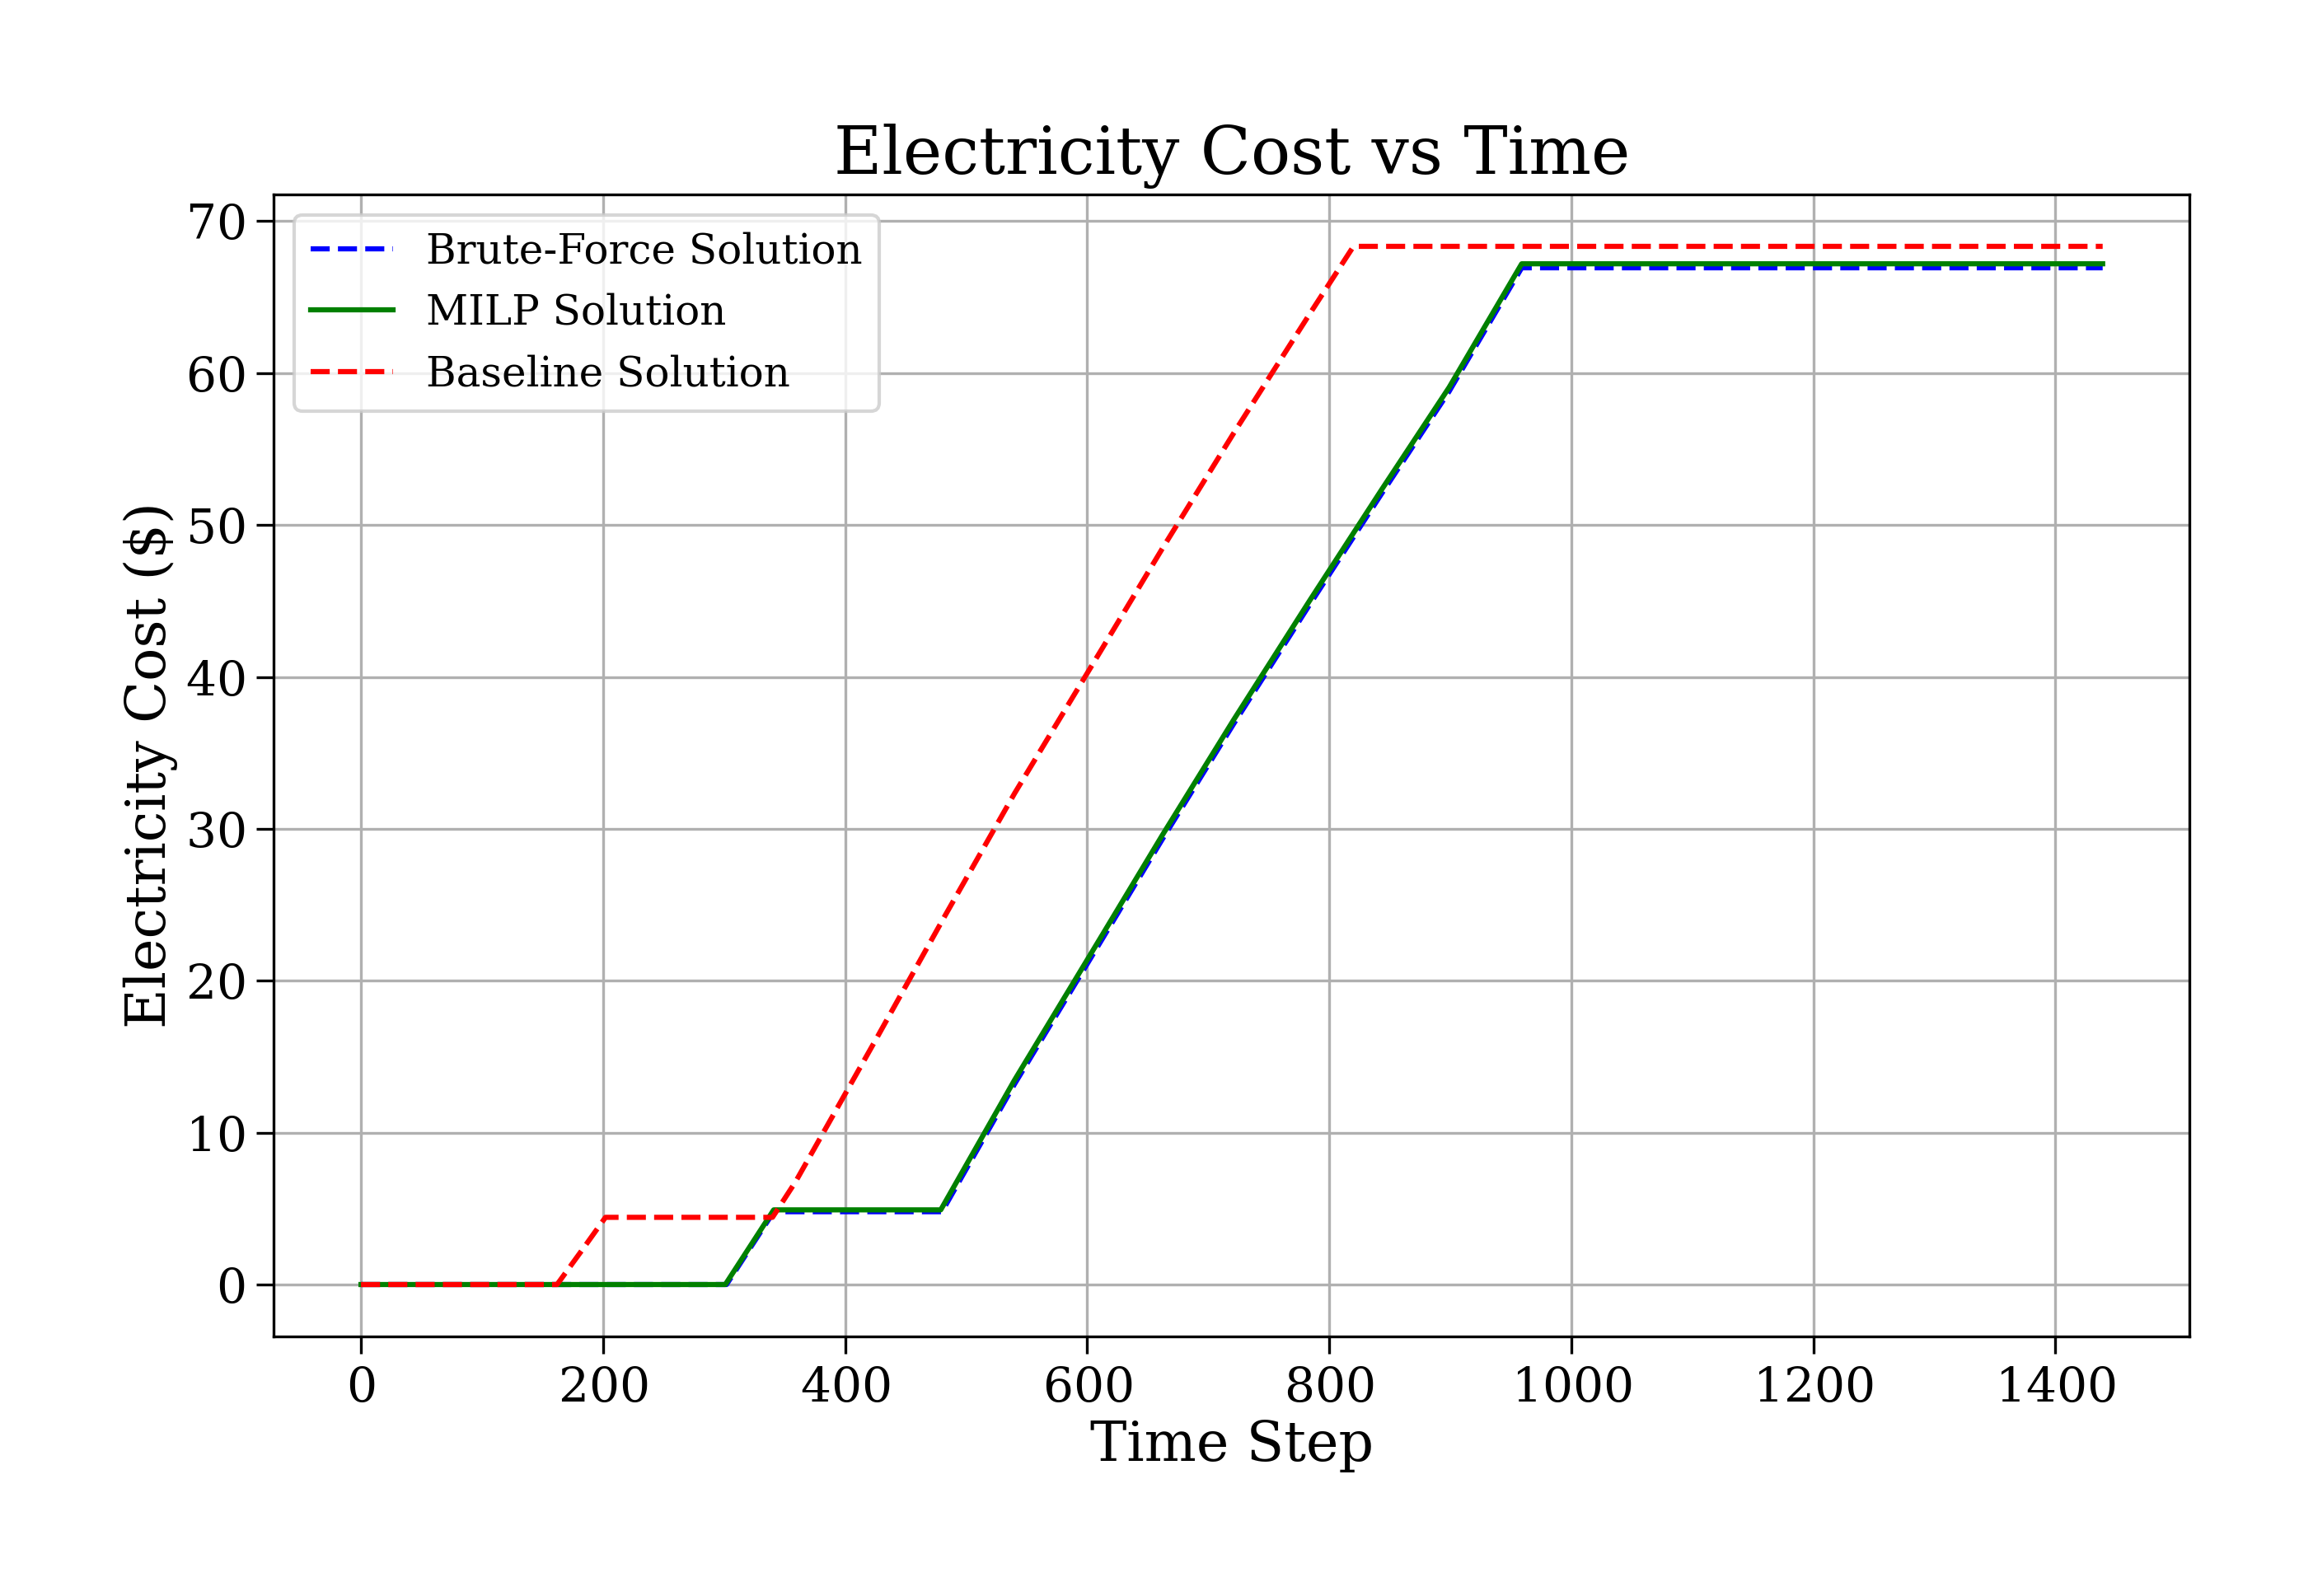

range(0, 1441)


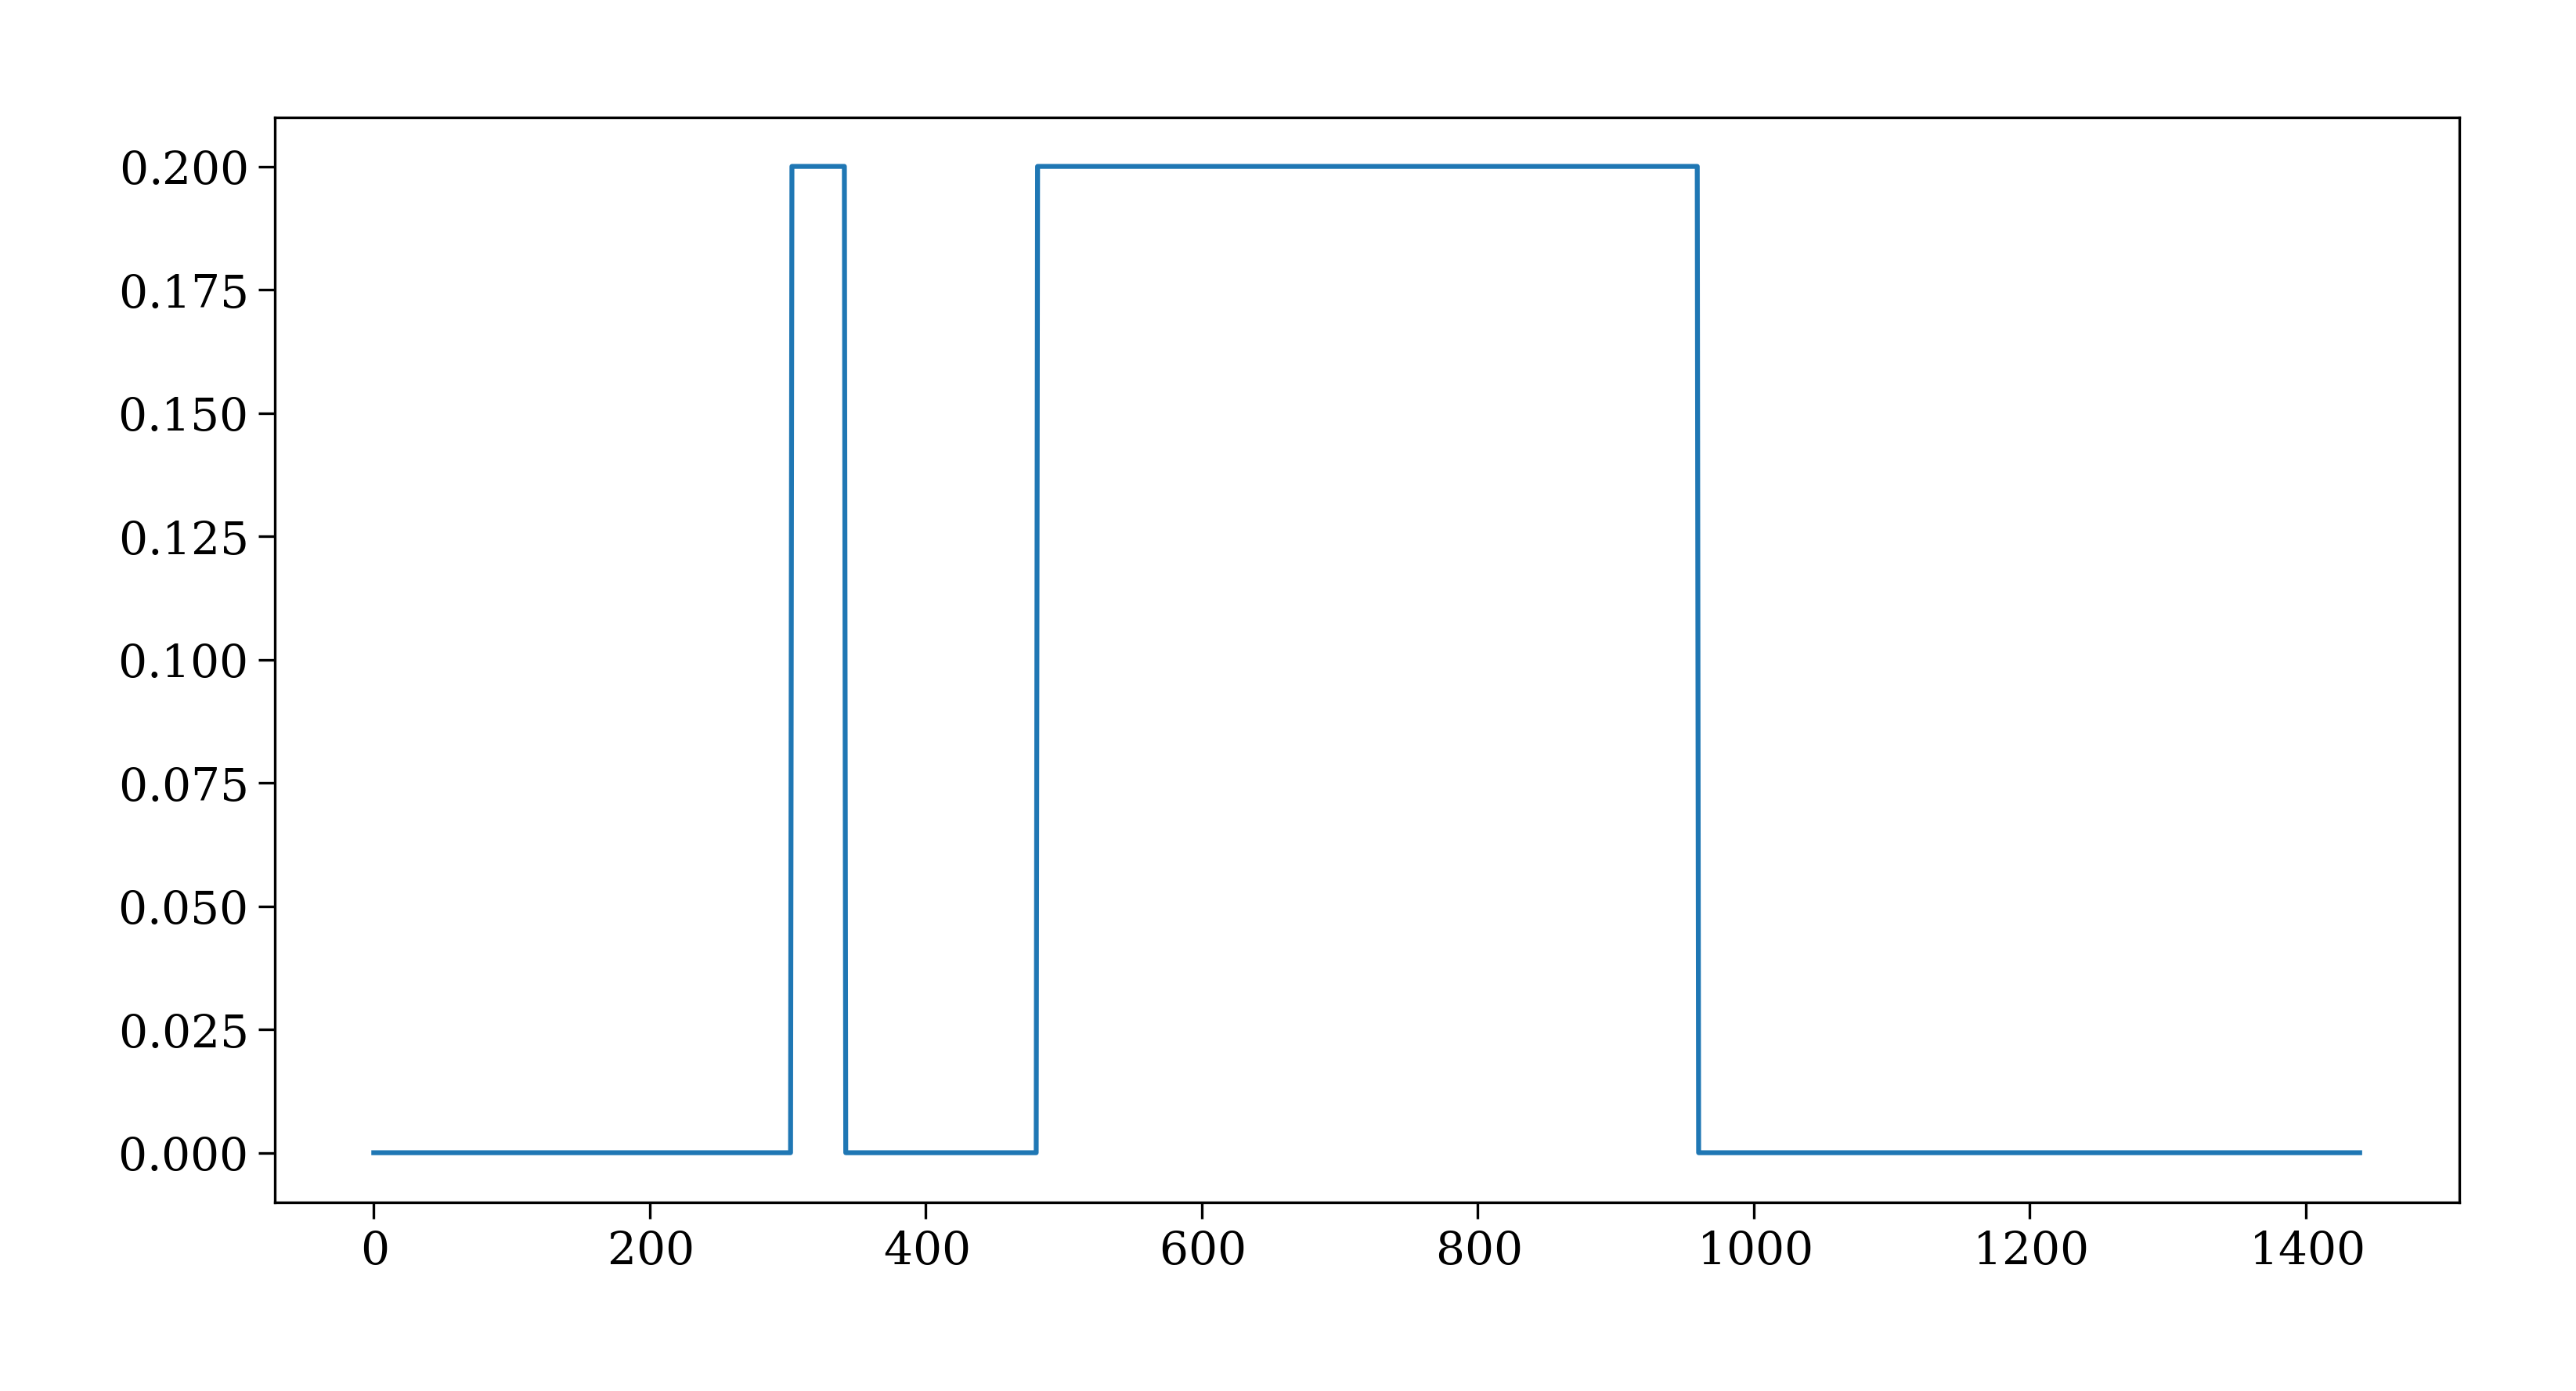

In [15]:
time_steps = list(range(1440))




plt.figure(figsize=(10, 6))
plt.plot(time_steps, brute_day_long_elec, label='Brute-Force Solution', color='blue', linestyle='--')
plt.plot(time_steps, mlp_day_long_elec, label='MILP Solution', color='green', linestyle='-')
plt.plot(time_steps,base_day_long_elec , label='Baseline Solution', color='red', linestyle='--')

plt.xlabel('Time Step')
plt.ylabel('Electricity Cost ($)')
plt.title('Electricity Cost vs Time')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

print(range(len(time_index)))
plt.plot(range(len(charge_flag_brute)),[charge_flag_brute[t]*0.2 for t in range(len(charge_flag_brute))],label='charge_window')
plt.show()

## Brute Force Plots

Nominal Start Time: 150.0
Start Time Lower Bound: 30.0
Start Time Upper Bound: 270.0

Lambda: 0.18
Optimal Start Time: 140.0
Minimal Cost: 3.0059994720833974


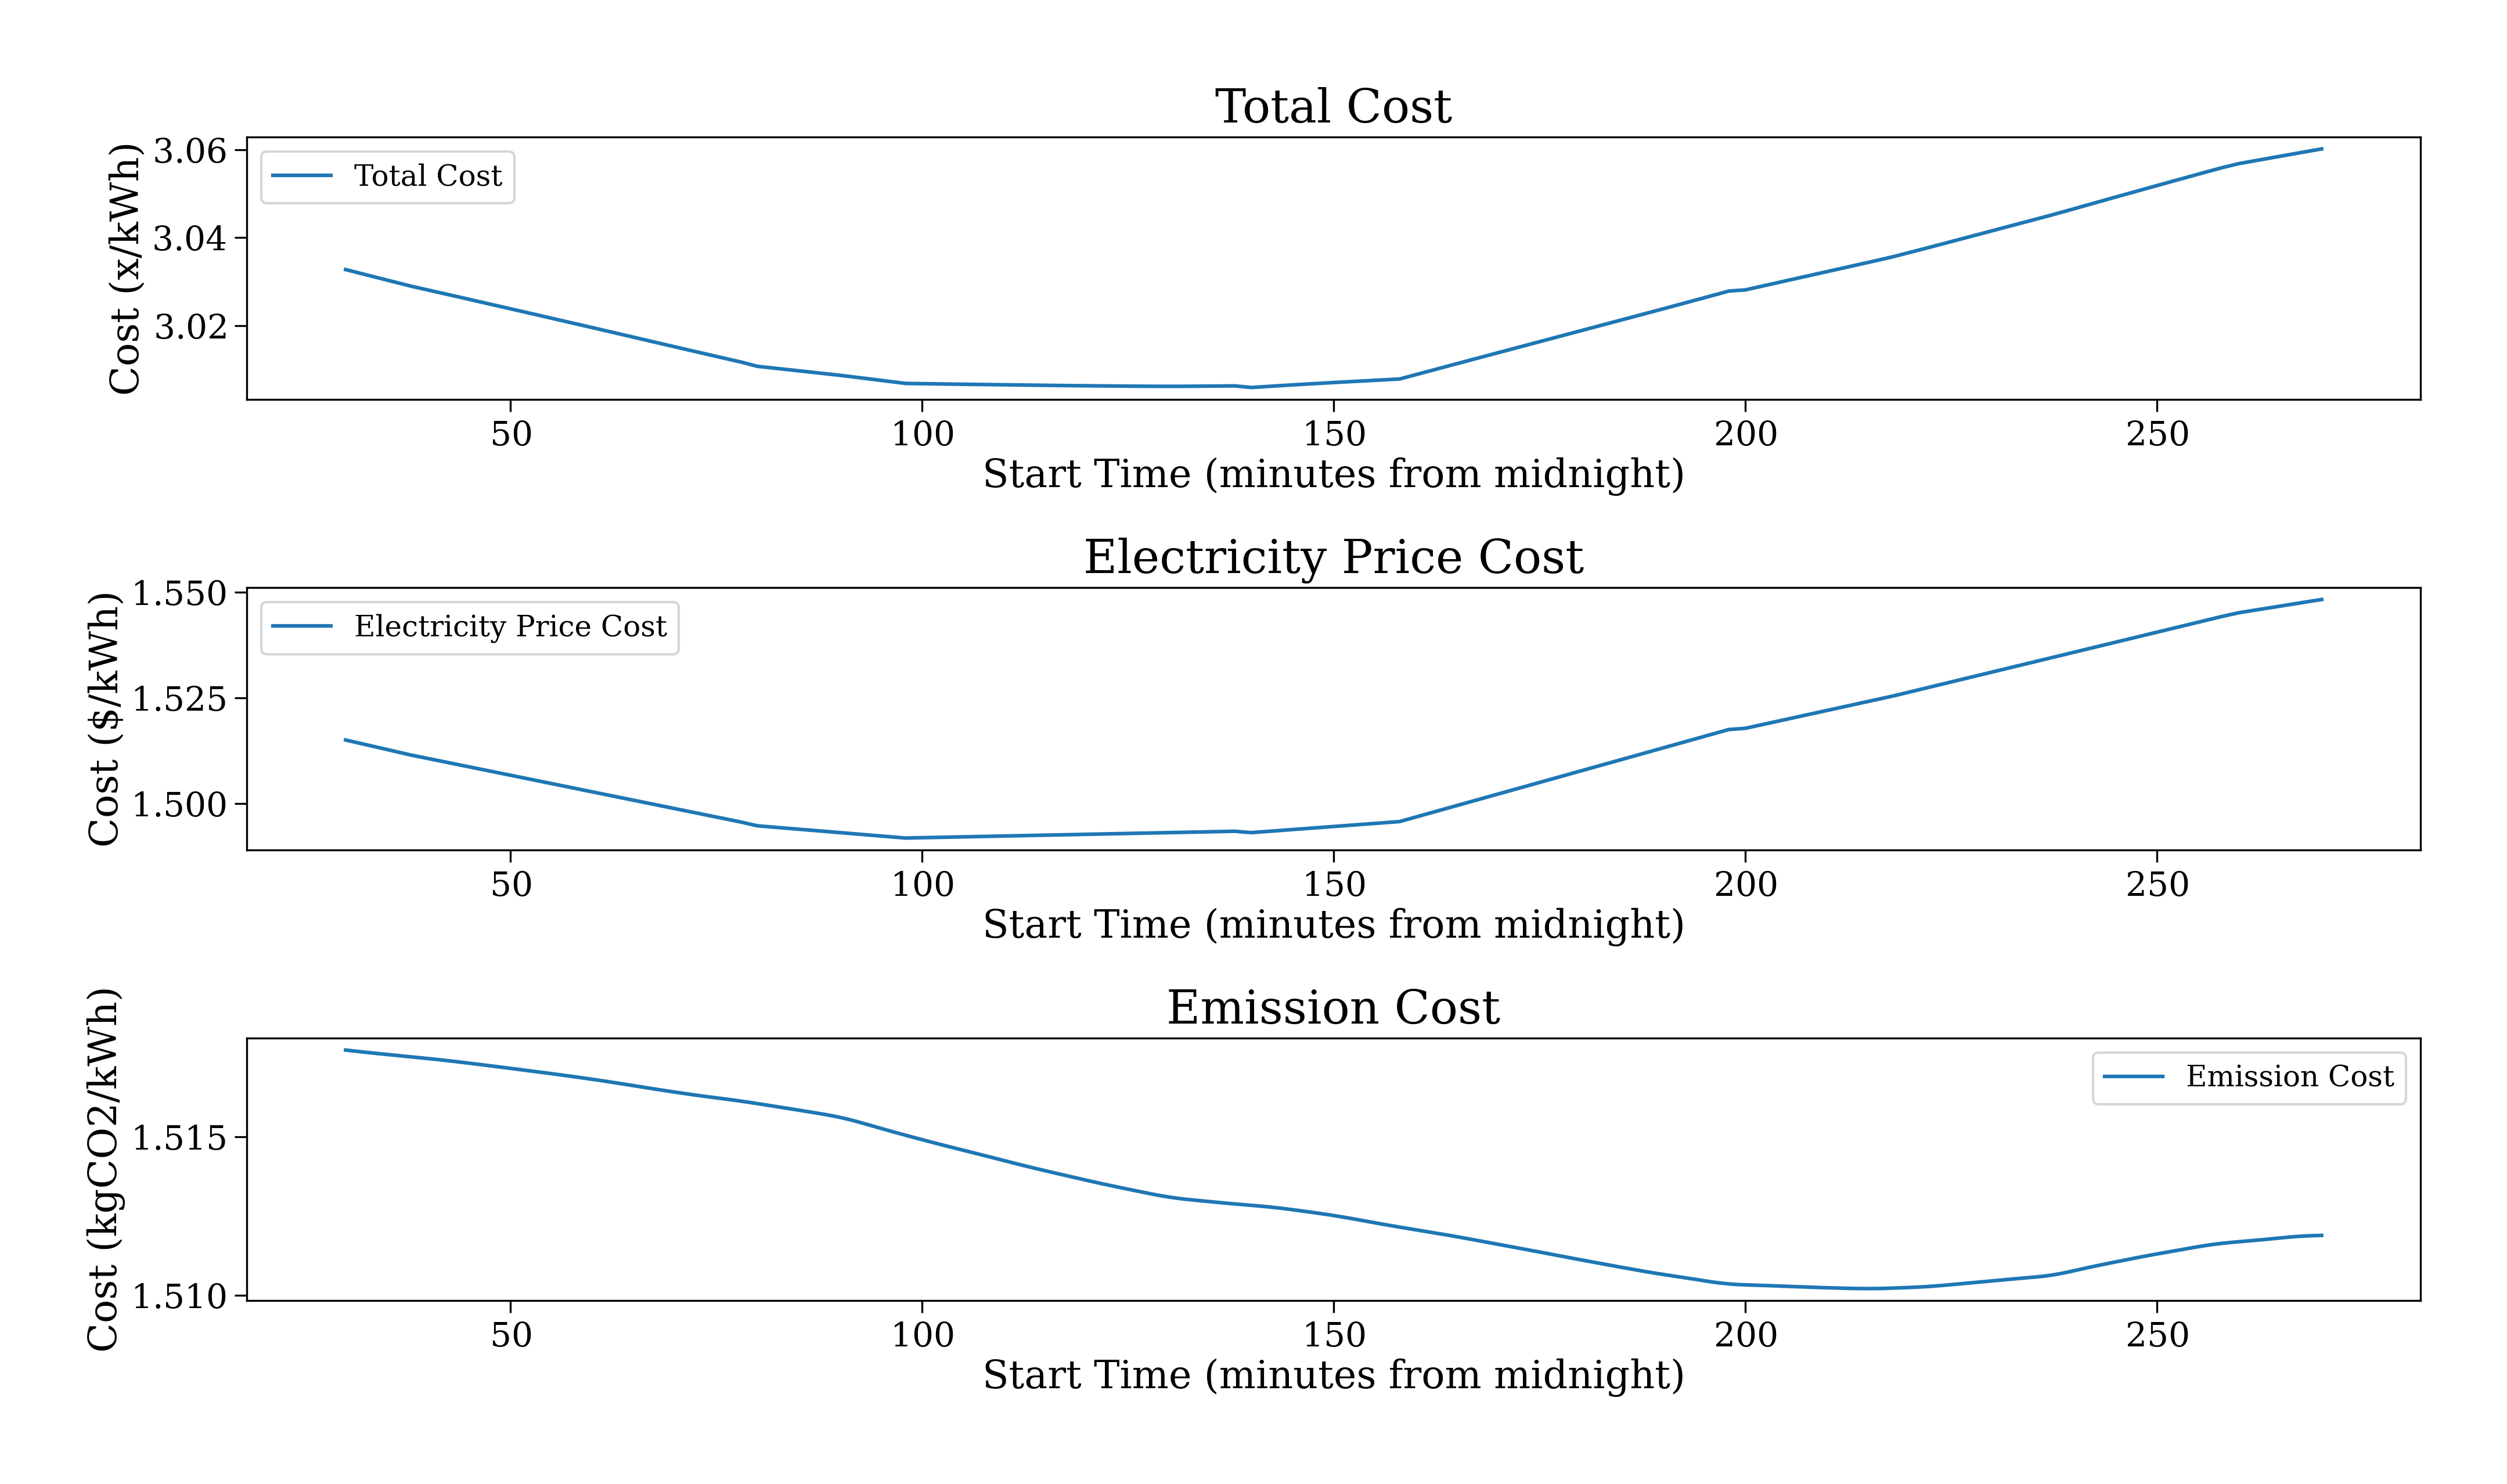

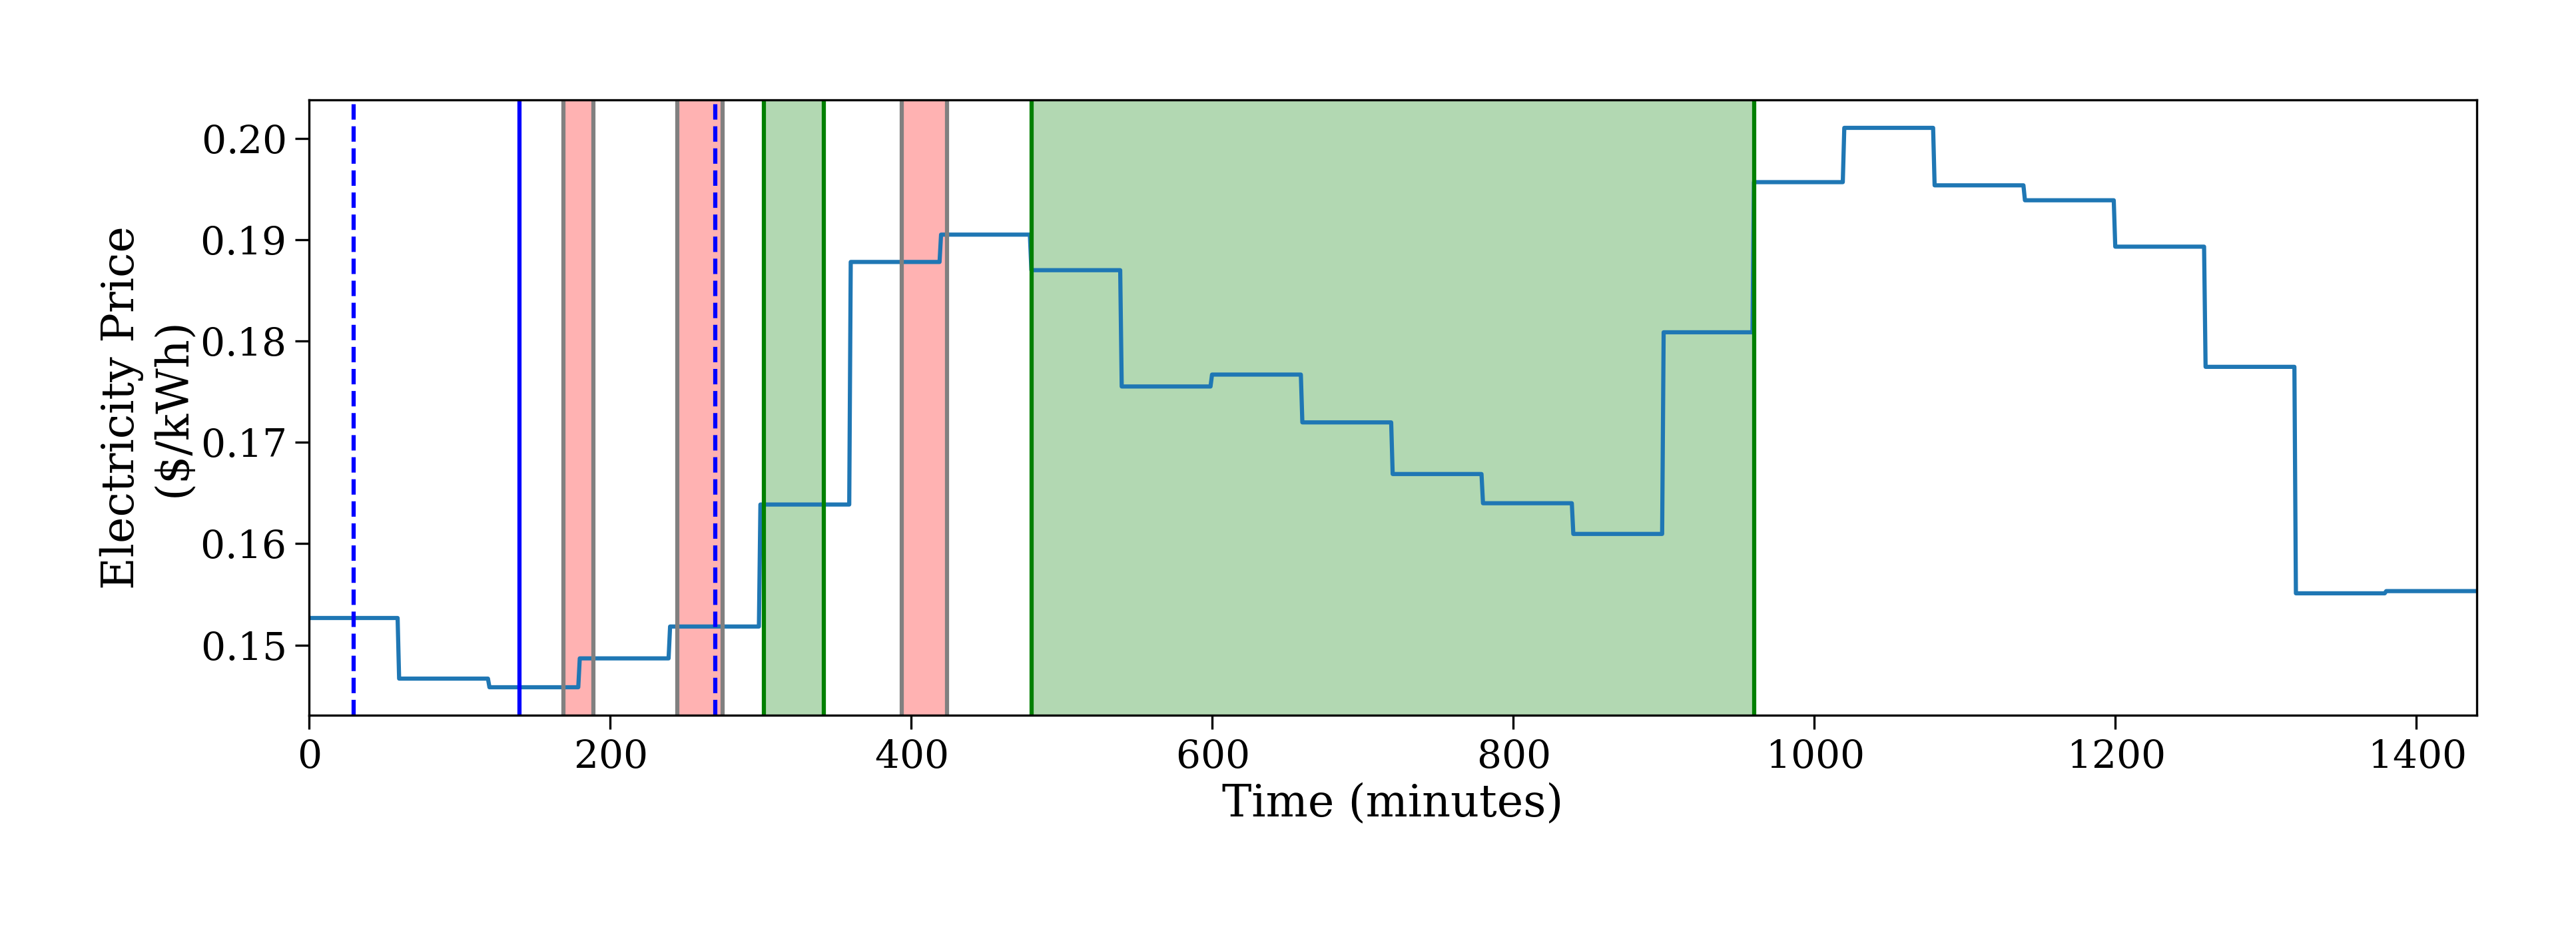

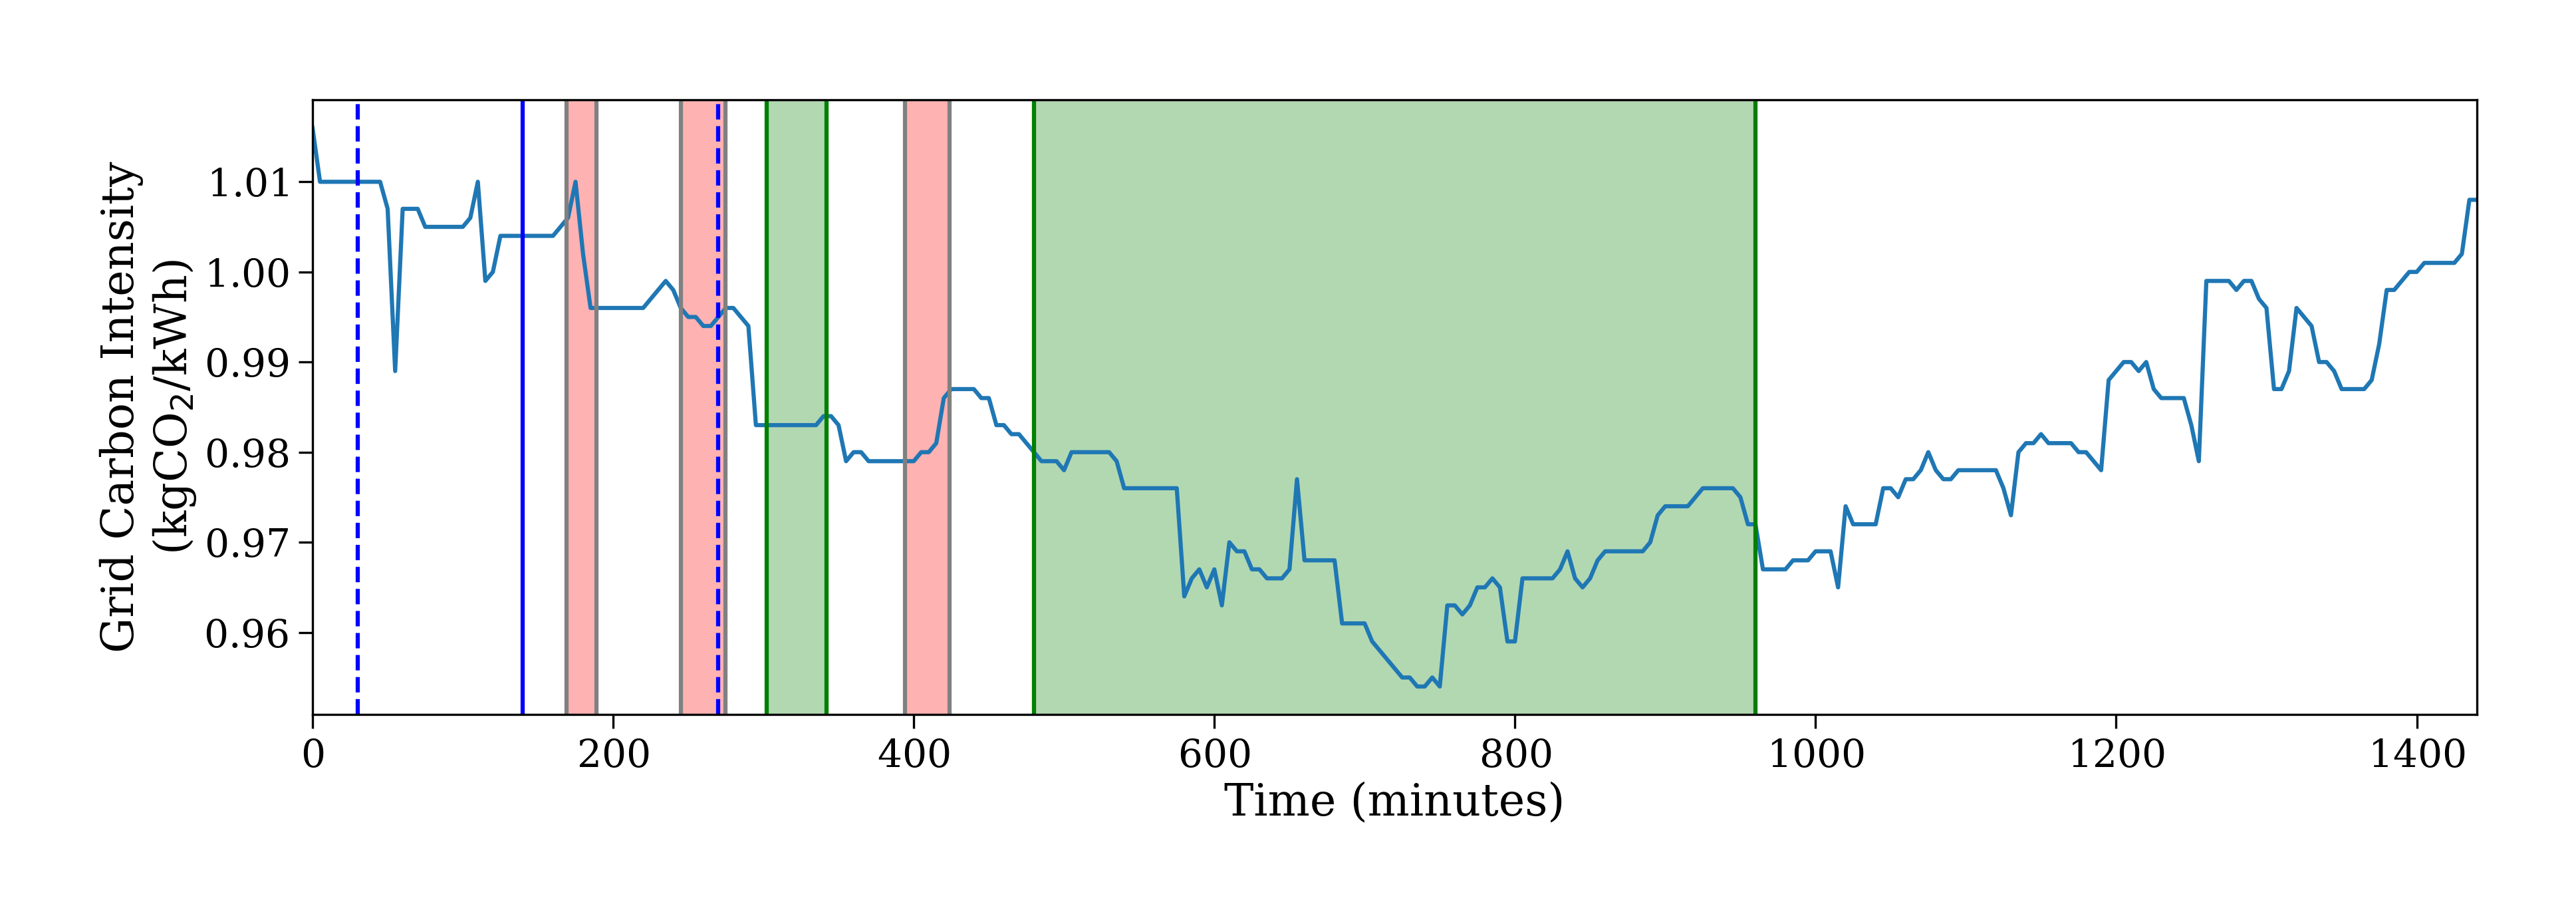

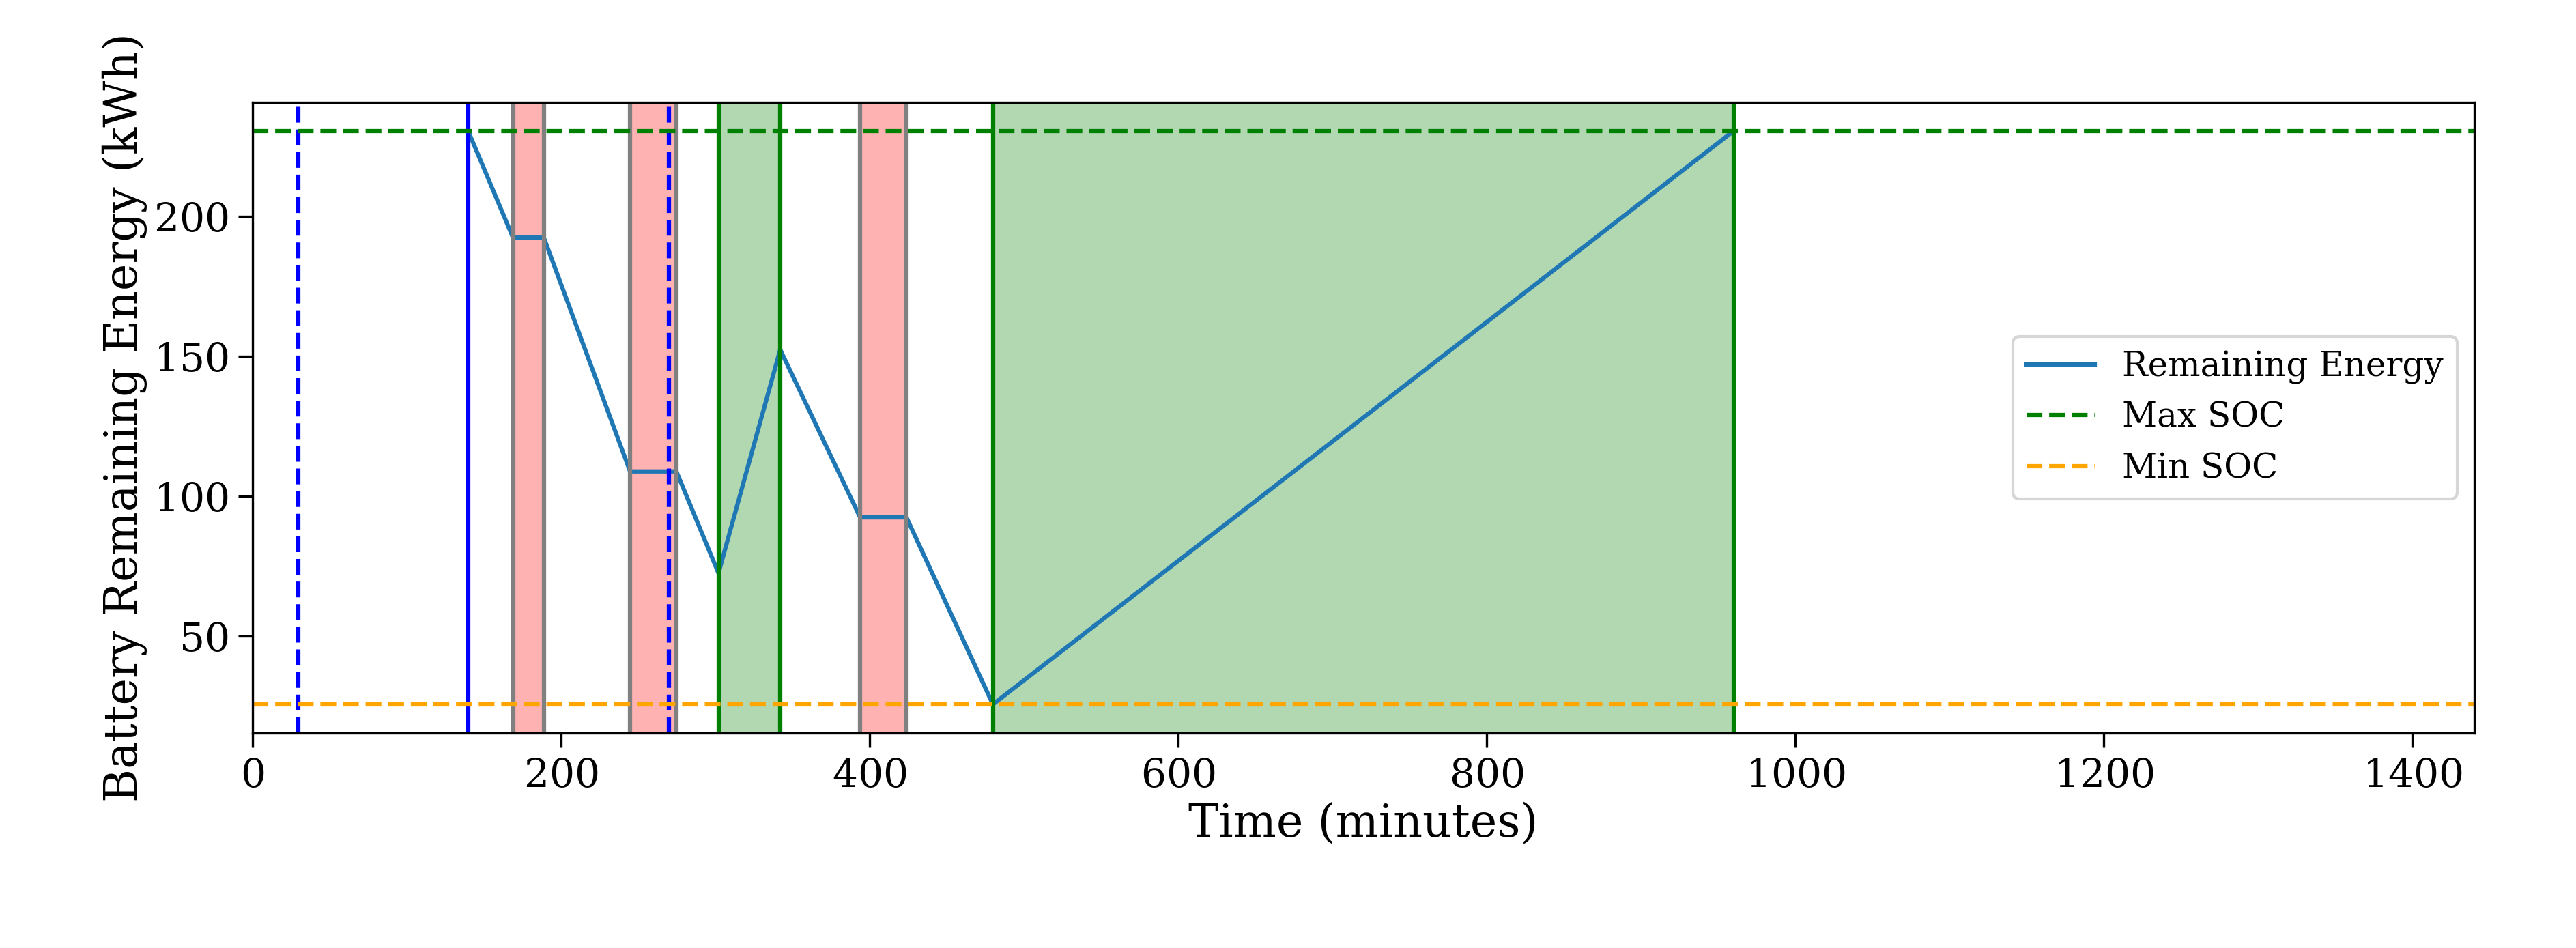

In [16]:
# Set hyperparameter
lambd = 0.18

# Define the range of possible start times
print('Nominal Start Time:', start_time_nominal)
print('Start Time Lower Bound:', start_time_lower_bound)
print('Start Time Upper Bound:', start_time_upper_bound)
possible_start_times = np.arange(start_time_lower_bound, start_time_upper_bound + 1, delta_t)  # 1-minute intervals

# Interpolate carbon intensity
carbon_intensity_interp = interp1d(time_index, carbon_intensity, kind='linear', fill_value="extrapolate")

# Initialize variables to store the optimal start time and its cost
optimal_start_time = None
minimal_cost = float('inf')

# Initialize lists to store the costs
start_times = []
total_costs = []
price_costs = []
emission_costs = []

# Brute-force search over possible start times
for start_time in possible_start_times:
    total_cost = 0
    price_cost = 0
    emission_cost = 0

    for (start, end) in charge_windows:
        start_time_adjusted = start_time + start
        end_time_adjusted = start_time + end

        while start_time_adjusted < end_time_adjusted:
            next_interval = start_time_adjusted + delta_t
            if next_interval > end_time_adjusted:
                next_interval = end_time_adjusted

            current_price_interval = int(start_time_adjusted // delta_t)
            price = electricity_price[current_price_interval]

            carbon_start = carbon_intensity_interp(start_time_adjusted)
            carbon_end = carbon_intensity_interp(next_interval)
            avg_carbon = (carbon_start + carbon_end) / 2

            duration = (next_interval - start_time_adjusted) / 60  # converting to hours

            price_cost += price * duration
            emission_cost += lambd * avg_carbon * duration

            start_time_adjusted = next_interval

    total_cost = price_cost + emission_cost
    start_times.append(start_time)
    total_costs.append(total_cost)
    price_costs.append(price_cost)
    emission_costs.append(emission_cost)

    # Update the optimal start time if the current total cost is lower
    if total_cost < minimal_cost:
        minimal_cost = total_cost
        optimal_start_time = start_time

print("\nLambda:", lambd)
print("Optimal Start Time:", optimal_start_time)
print("Minimal Cost:", minimal_cost)

# Plotting the costs
plt.figure(figsize=(14, 8))

plt.subplot(3, 1, 1)
plt.plot(start_times, total_costs, label='Total Cost')
plt.xlabel('Start Time (minutes from midnight)')
plt.ylabel('Cost (x/kWh)')
plt.title('Total Cost')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(start_times, price_costs, label='Electricity Price Cost')
plt.xlabel('Start Time (minutes from midnight)')
plt.ylabel('Cost ($/kWh)')
plt.title('Electricity Price Cost')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(start_times, emission_costs, label='Emission Cost')
plt.xlabel('Start Time (minutes from midnight)')
plt.ylabel('Cost (kgCO2/kWh)')
plt.title('Emission Cost')
plt.legend()

plt.tight_layout()
plt.show()

# Plot electricity price
fig1, ax1 = plt.subplots(figsize=(14, 4))
ax1.plot(time_index, electricity_price, label='Electricity Price')

# Mark transition points
for i in range(len(time_list)):
    if time_list[i] == 0:
        ax1.axvline(x=optimal_start_time + time_list[i], color='b', linestyle='-')
    elif can_charge[(i-1) // 2]:
        ax1.axvline(x=optimal_start_time + time_list[i], color='g', linestyle='-')
    else:
        ax1.axvline(x=optimal_start_time + time_list[i], color='grey', linestyle='-')
        if i % 2 == 0:
            ax1.axvspan(optimal_start_time + time_list[i-1], optimal_start_time + time_list[i], facecolor='red', alpha=0.3)
    if time_list[i] != 0 and i % 2 == 0 and can_charge[(i-1) // 2]:
        ax1.axvspan(optimal_start_time + time_list[i-1], optimal_start_time + time_list[i], facecolor='green', alpha=0.3)

# Mark bounds for start time
ax1.axvline(x=start_time_lower_bound, color='b', linestyle='--')
ax1.axvline(x=start_time_upper_bound, color='b', linestyle='--')

# Set labels
ax1.set_ylabel('Electricity Price\n($/kWh)')
ax1.set_xlabel('Time (minutes)')
ax1.set_xlim(0, 1440)

plt.show()

# Plot grid carbon intensity
fig2, ax2 = plt.subplots(figsize=(14, 4))
ax2.plot(time_index, carbon_intensity, label='Grid Carbon Intensity')

# Mark transition points
for i in range(len(time_list)):
    if time_list[i] == 0:
        ax2.axvline(x=optimal_start_time + time_list[i], color='b', linestyle='-')
    elif can_charge[(i-1) // 2]:
        ax2.axvline(x=optimal_start_time + time_list[i], color='g', linestyle='-')
    else:
        ax2.axvline(x=optimal_start_time + time_list[i], color='grey', linestyle='-')
        if i % 2 == 0:
            ax2.axvspan(optimal_start_time + time_list[i-1], optimal_start_time + time_list[i], facecolor='red', alpha=0.3)
    if time_list[i] != 0 and i % 2 == 0 and can_charge[(i-1) // 2]:
        ax2.axvspan(optimal_start_time + time_list[i-1], optimal_start_time + time_list[i], facecolor='green', alpha=0.3)

# Mark bounds for start time
ax2.axvline(x=start_time_lower_bound, color='b', linestyle='--')
ax2.axvline(x=start_time_upper_bound, color='b', linestyle='--')

# Set labels
ax2.set_ylabel('Grid Carbon Intensity\n(kgCO$_2$/kWh)')
ax2.set_xlabel('Time (minutes)')
ax2.set_xlim(0, 1440)

plt.show()

# Plot the final results for remaining battery energy
fig3, ax3 = plt.subplots(figsize=(14, 4))
ax3.plot([optimal_start_time + t for t in time_list], remaining_energy_list, label='Remaining Energy')

# Mark transition points and optimized charging windows
for i in range(len(time_list)):
    if time_list[i] == 0:
        ax3.axvline(x=optimal_start_time + time_list[i], color='b', linestyle='-')
    elif can_charge[(i-1) // 2]:
        ax3.axvline(x=optimal_start_time + time_list[i], color='g', linestyle='-')
    else:
        ax3.axvline(x=optimal_start_time + time_list[i], color='grey', linestyle='-')
        if i % 2 == 0:
            ax3.axvspan(optimal_start_time + time_list[i-1], optimal_start_time + time_list[i], facecolor='red', alpha=0.3)
    if time_list[i] != 0 and i % 2 == 0 and can_charge[(i-1) // 2]:
        ax3.axvspan(optimal_start_time + time_list[i-1], optimal_start_time + time_list[i], facecolor='green', alpha=0.3)

# Mark bounds for start time
ax3.axvline(x=start_time_lower_bound, color='b', linestyle='--')
ax3.axvline(x=start_time_upper_bound, color='b', linestyle='--')

# Plot
ax3.axhline(y=max_soc, color='g', linestyle='--', label='Max SOC')
ax3.axhline(y=min_soc, color='orange', linestyle='--', label='Min SOC')

# Set labels
ax3.set_ylabel('Battery Remaining Energy (kWh)')
ax3.set_xlabel('Time (minutes)')
ax3.set_xlim(0, 1440)
ax3.legend()

plt.show()

## Baseline

## Final Charge Window

In [17]:
# Define parameters
eta_c = 0.9  # charging efficiency
eta_d = 0.5  # discharging efficiency
lambd = 0.18  # weight for carbon intensity
C_deg = 0.01  # degradation cost coefficient
SOC_min = 0.1 * battery_capacity  # minimum SOC
SOC_max = 0.9 * battery_capacity  # maximum SOC
max_charge_power = 50  # kW, maximum charging power
max_discharge_power = 50  # kW, maximum discharging power
C_c_max = 1000  # kVA, maximum capacity of the transformer
delta_t = 1  # minutes, time step size

# Charging window details
# optimized_start_time = optimal_start_time
# optimized_start_time = 270.0
print(charge_windows)
charging_window = charge_windows[1]
print(charging_window)
charge_window_start = optimized_start_time + charging_window[0]  # start time of the charging window
charge_window_end = min(1440,optimized_start_time + charging_window[1])  # end time of the charging window
start_idx = int(charge_window_start // delta_t)
end_idx = int(charge_window_end // delta_t)
T = end_idx - start_idx  # number of time steps

# Assume these are given or calculated previously
L_net = np.zeros(T)  # net load at each time step
SOC_togo = 0  # kWh, required SOC to complete the route
p_t = electricity_price[start_idx:end_idx+1]  # electricity price at each time step
g_t = carbon_intensity[start_idx:end_idx+1]  # grid carbon intensity at each time step

# Define the optimization problem
prob = pulp.LpProblem("LowLevelChargeScheduler", pulp.LpMinimize)

# Define decision variables
c_t = pulp.LpVariable.dicts("c_t", range(T), lowBound=0, upBound=max_charge_power)
d_t = pulp.LpVariable.dicts("d_t", range(T), lowBound=0, upBound=max_discharge_power)
omega_t = pulp.LpVariable.dicts("omega_t", range(T), cat='Binary')

# Define SOC variable and initial SOC
SOC = [pulp.LpVariable(f"SOC_{t}", lowBound=SOC_min, upBound=SOC_max) for t in range(T + 1)]
SOC[0] = SOC_min

# Objective function
objective = pulp.lpSum([
    (p_t[t] * (c_t[t] * eta_c - d_t[t] * eta_d) + lambd * g_t[t] * (c_t[t] * eta_c - d_t[t] * eta_d)) * (delta_t / 60) + C_deg * d_t[t]
    for t in range(T)
])
prob += objective

# SOC dynamics and constraints
for t in range(T):
    prob += SOC[t + 1] == SOC[t] + (c_t[t] * eta_c - d_t[t] * eta_d) * (delta_t / 60)
    prob += c_t[t] <= max_charge_power * omega_t[t]
    prob += d_t[t] <= max_discharge_power * (1 - omega_t[t])

# Net load constraint
for t in range(T):
    prob += L_net[t] + c_t[t] * eta_c - d_t[t] * eta_d <= C_c_max

# Window SOC constraint
prob += SOC[T] >= SOC_max

# Solve the problem
prob.solve()

# Retrieve the optimized schedules
optimized_c_t = [pulp.value(c_t[t]) for t in range(T)]
optimized_d_t = [pulp.value(d_t[t]) for t in range(T)]
optimized_SOC = [pulp.value(SOC[t]) for t in range(T + 1)]

print("Optimized Charging Schedule:", optimized_c_t)
print("Optimized Discharging Schedule:", optimized_d_t)
print("Optimized SOC:", optimized_SOC)

[(162.1997676, 202.1997676), (340.0661595, 820.0661595)]
(340.0661595, 820.0661595)
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/l_/9_zfnc1528j4t0x96tq52wdh0000gn/T/268608a21bc6479ba26d41a83e9dac14-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/l_/9_zfnc1528j4t0x96tq52wdh0000gn/T/268608a21bc6479ba26d41a83e9dac14-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1926 COLUMNS
At line 8647 RHS
At line 10569 BOUNDS
At line 12970 ENDATA
Problem MODEL has 1921 rows, 1920 columns and 4800 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 69.7718 - 0.01 seconds
Cgl0004I processed model has 1440 rows, 1919 columns (480 integer (480 of which binary)) and 3838 elements
Cbc0038I Initial state - 1 integers unsatisfied sum - 0.0666667


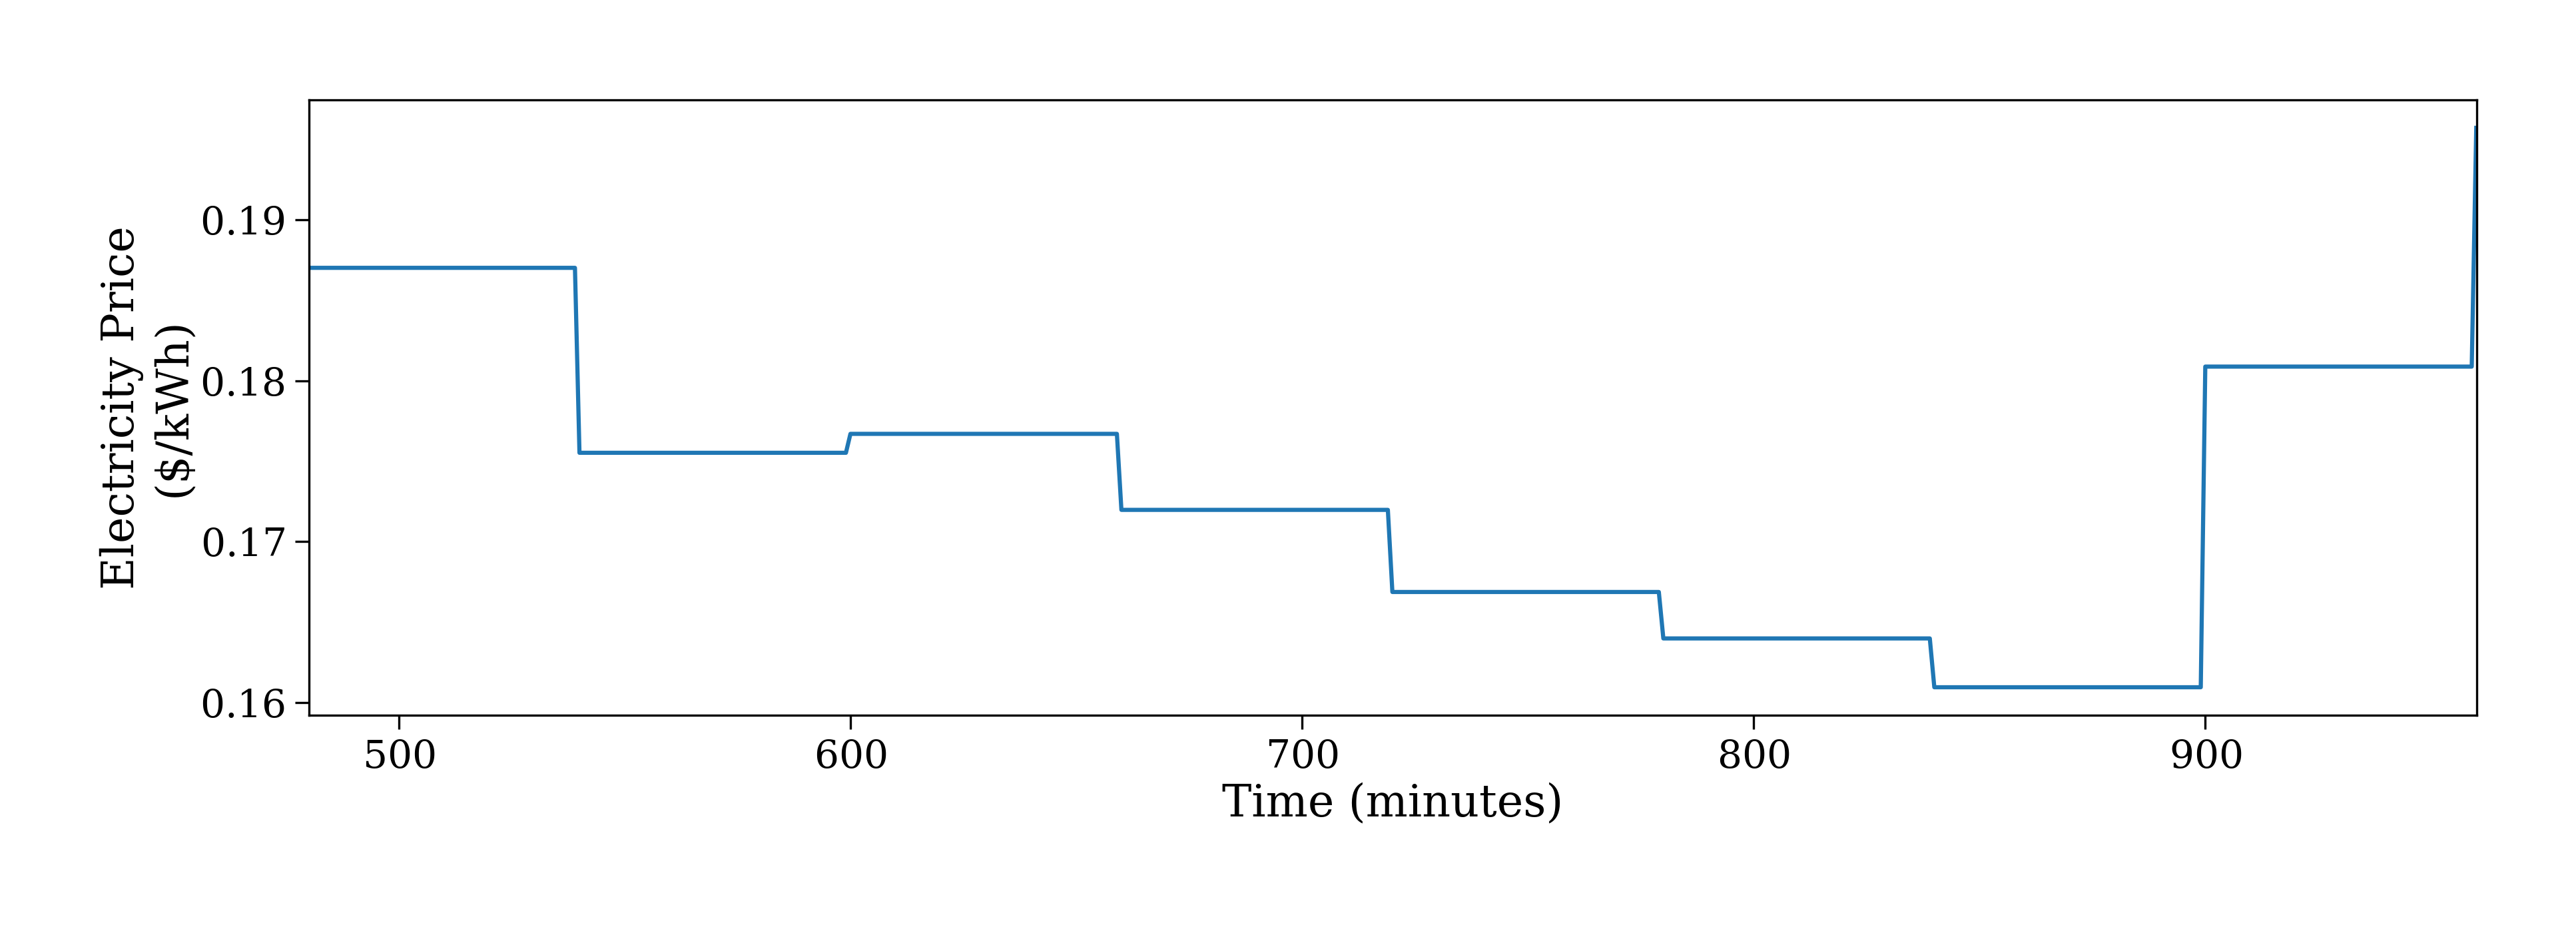

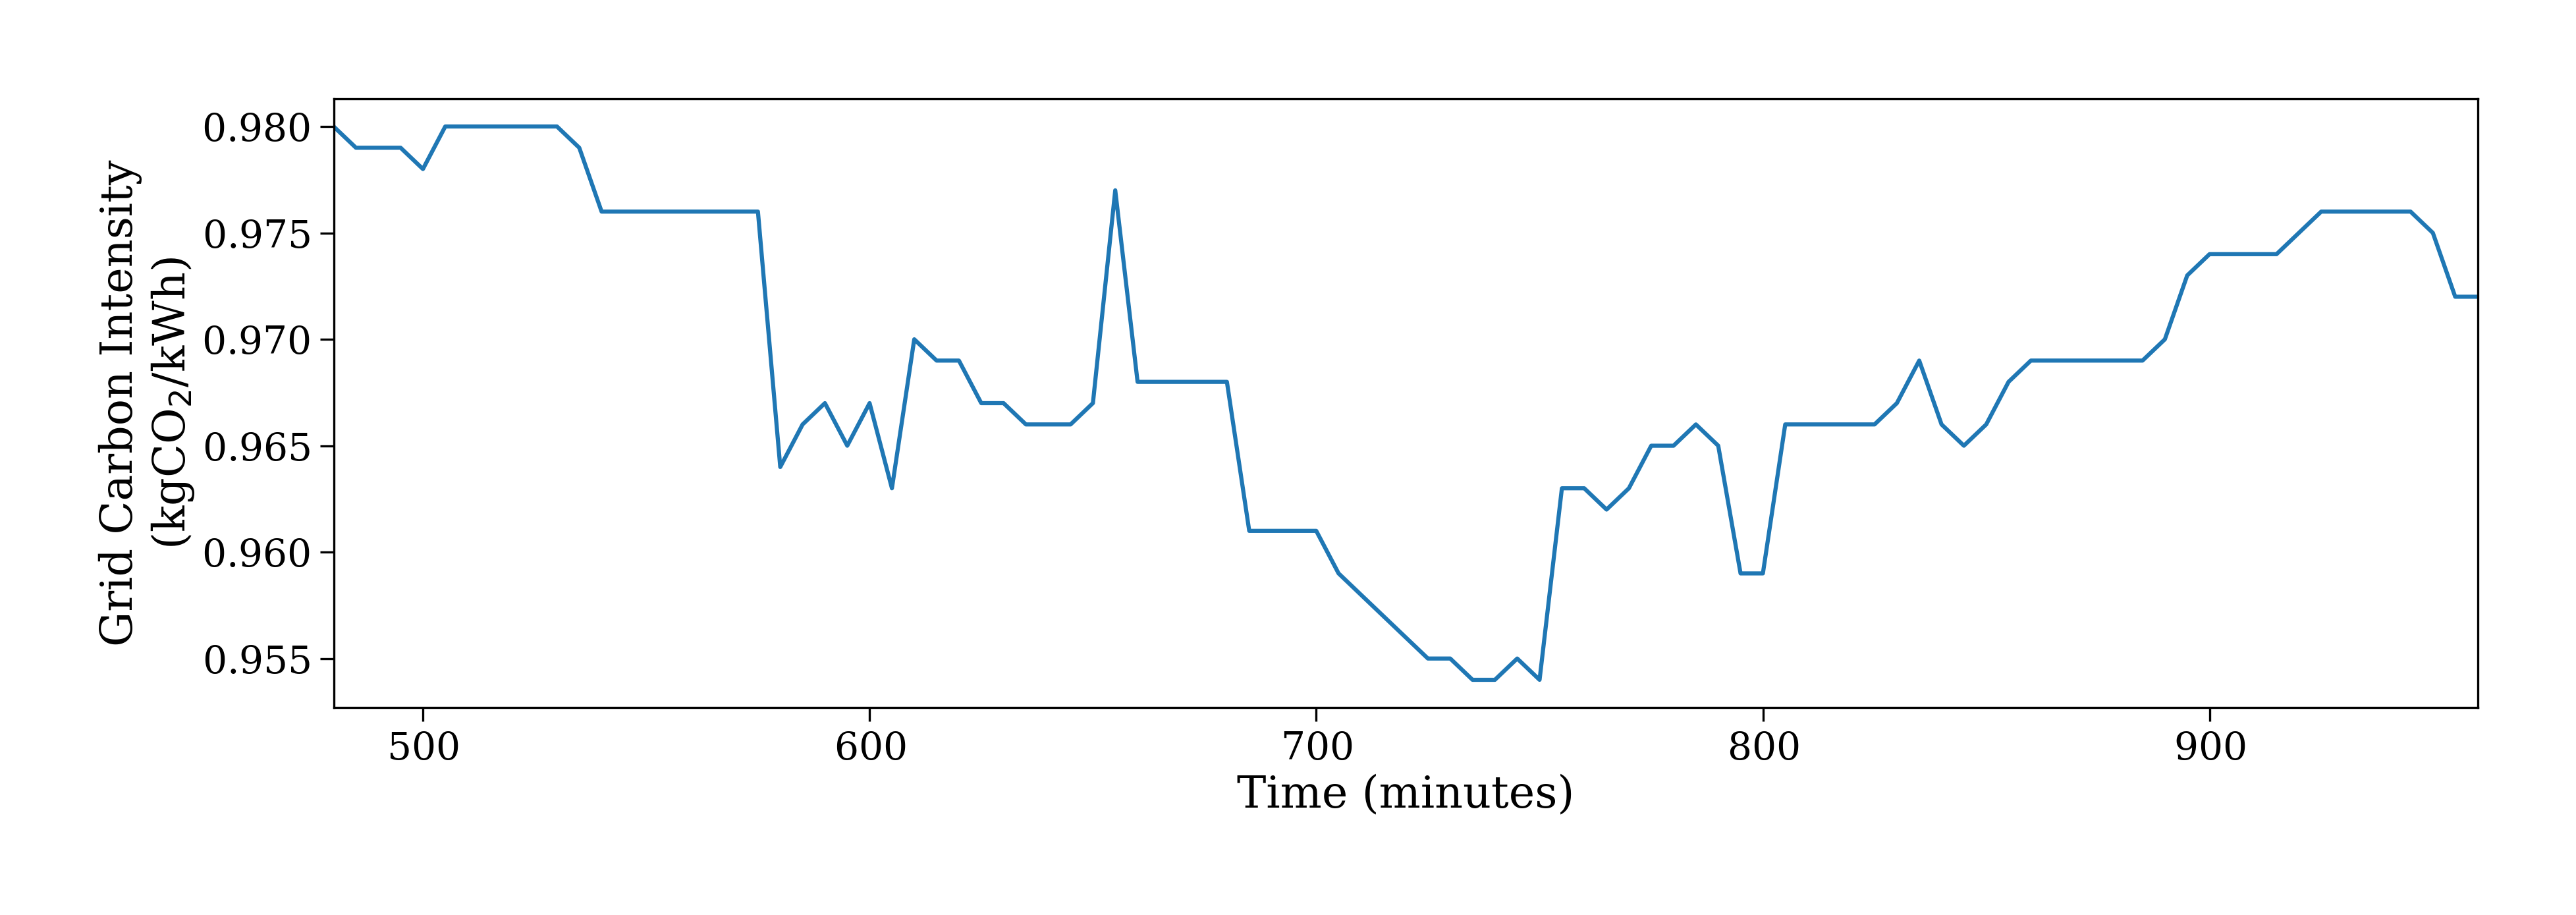

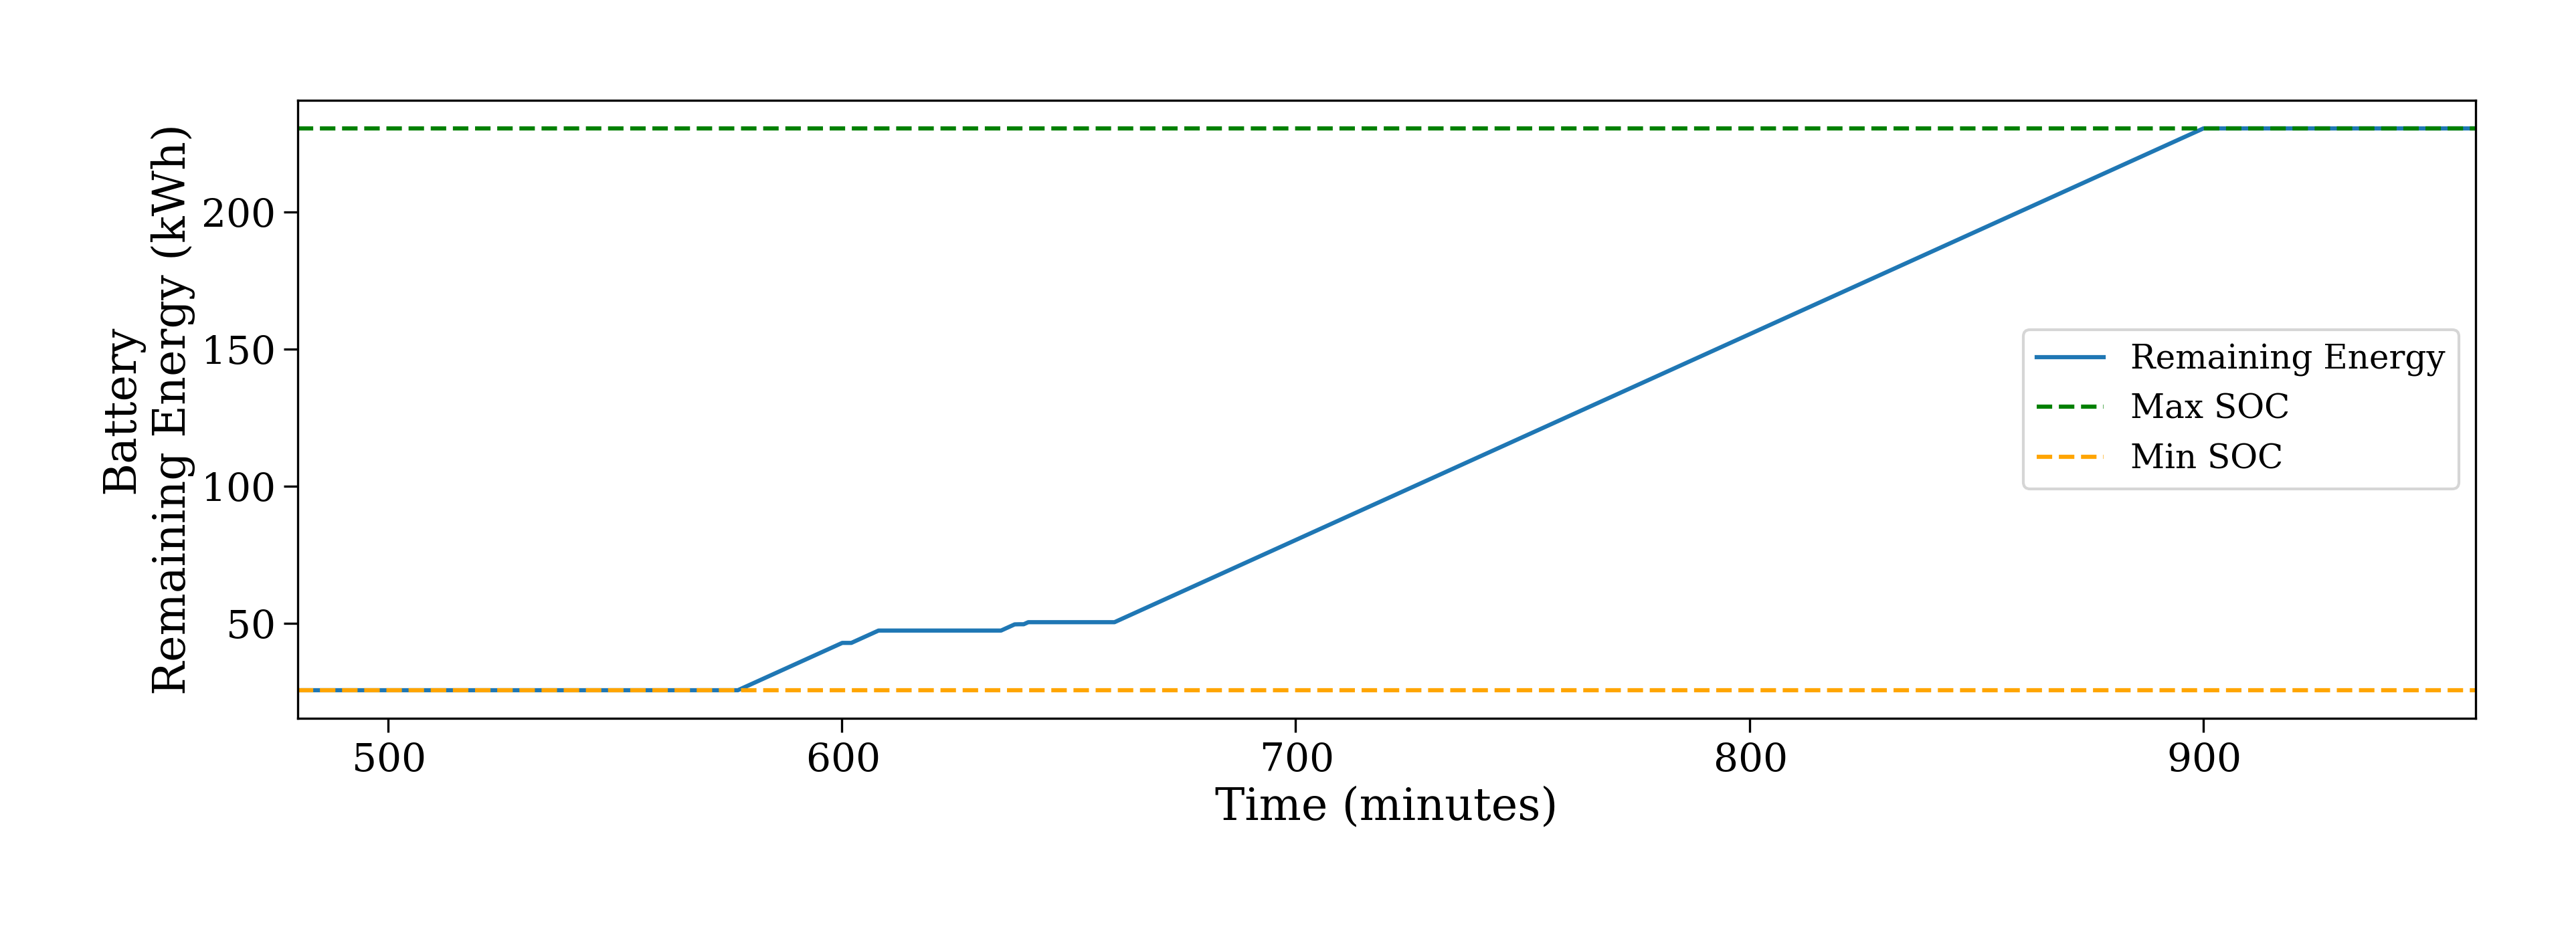

In [18]:
# Electricity Price
fig1, ax1 = plt.subplots(figsize=(14, 4))
ax1.plot(time_index[start_idx:end_idx+1], electricity_price[start_idx:end_idx+1], label='Electricity Price')
ax1.set_xlim(charge_window_start, charge_window_end)
ax1.set_ylabel('Electricity Price\n($/kWh)')
ax1.set_xlabel('Time (minutes)')
plt.show()

# Grid Carbon Intensity
fig2, ax2 = plt.subplots(figsize=(14, 4))
ax2.plot(time_index[start_idx:end_idx+1], carbon_intensity[start_idx:end_idx+1], label='Grid Carbon Intensity')
ax2.set_xlim(charge_window_start, charge_window_end)
ax2.set_ylabel('Grid Carbon Intensity\n(kgCO$_2$/kWh)')
ax2.set_xlabel('Time (minutes)')
plt.show()

# Battery Remaining Energy
fig3, ax3 = plt.subplots(figsize=(14, 4))
ax3.plot([charge_window_start + t * delta_t for t in range(T + 1)], optimized_SOC, label='Remaining Energy')
ax3.axhline(y=SOC_max, color='g', linestyle='--', label='Max SOC')
ax3.axhline(y=SOC_min, color='orange', linestyle='--', label='Min SOC')
ax3.set_xlim(charge_window_start, charge_window_end)
ax3.set_ylabel('Battery\nRemaining Energy (kWh)')
ax3.set_xlabel('Time (minutes)')
ax3.legend()
plt.show()

## Brute Force Check

In [19]:
# Define parameters
eta_c = 0.9  # charging efficiency
eta_d = 0.5  # discharging efficiency
lambd = 0.18  # weight for carbon intensity
C_deg = 0.01  # degradation cost coefficient
SOC_min = 0.1 * battery_capacity  # minimum SOC
SOC_max = 0.9 * battery_capacity  # maximum SOC
max_charge_power = 50  # kW, maximum charging power
max_discharge_power = 0  # kW, maximum discharging power
C_c_max = 1000 # kVA, maximum capacity of the transformer
delta_t = 1 # minutes, time step size

# Charging window details
# optimized_start_time = optimal_start_time
# optimized_start_time = 270.0
charging_window = charge_windows[1]
charge_window_start = optimized_start_time + charging_window[0]  # start time of the charging window
charge_window_end = min(1440,optimized_start_time + charging_window[1])  # end time of the charging window
start_idx = int(charge_window_start // delta_t)
end_idx = int(charge_window_end // delta_t)
T = end_idx - start_idx  # number of time steps

# Assume these are given or calculated previously
L_net = np.zeros(T)  # net load at each time step
SOC_togo = 0  # kWh, required SOC to complete the route
p_t = electricity_price  # electricity price at each time step
g_t = carbon_intensity  # grid carbon intensity at each time step

# Required charging (given by route scheduler)
SOC_init = SOC_min
SOC_target = SOC_max

# Determine minimum charging steps
min_target_charging = SOC_target - SOC_init
min_charging_steps = math.floor(min_target_charging/max_charge_power/(delta_t/60))

Optimal path to minimize cost: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 0, 50, 50, 50, 50, 50, 50, 50, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 

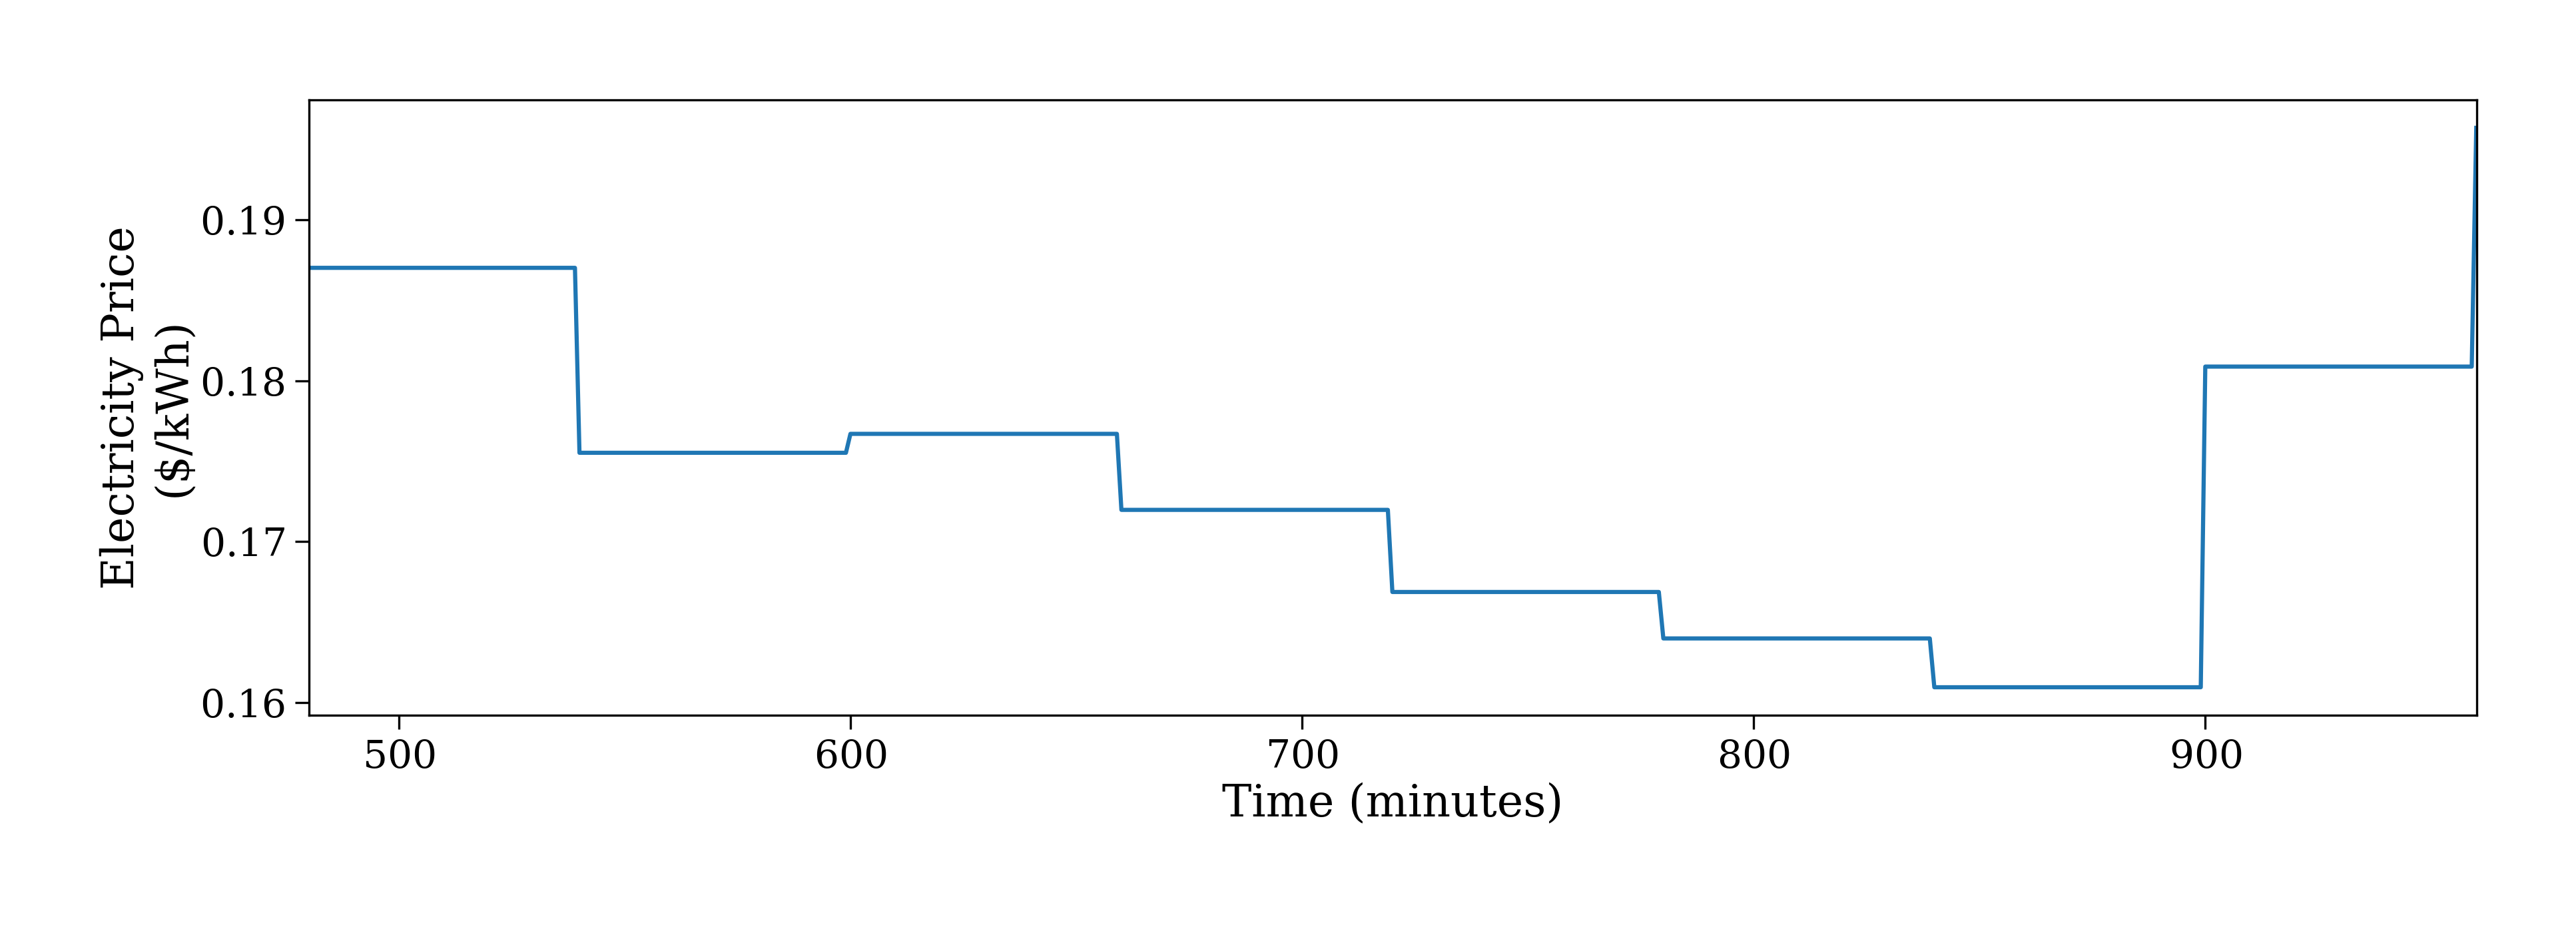

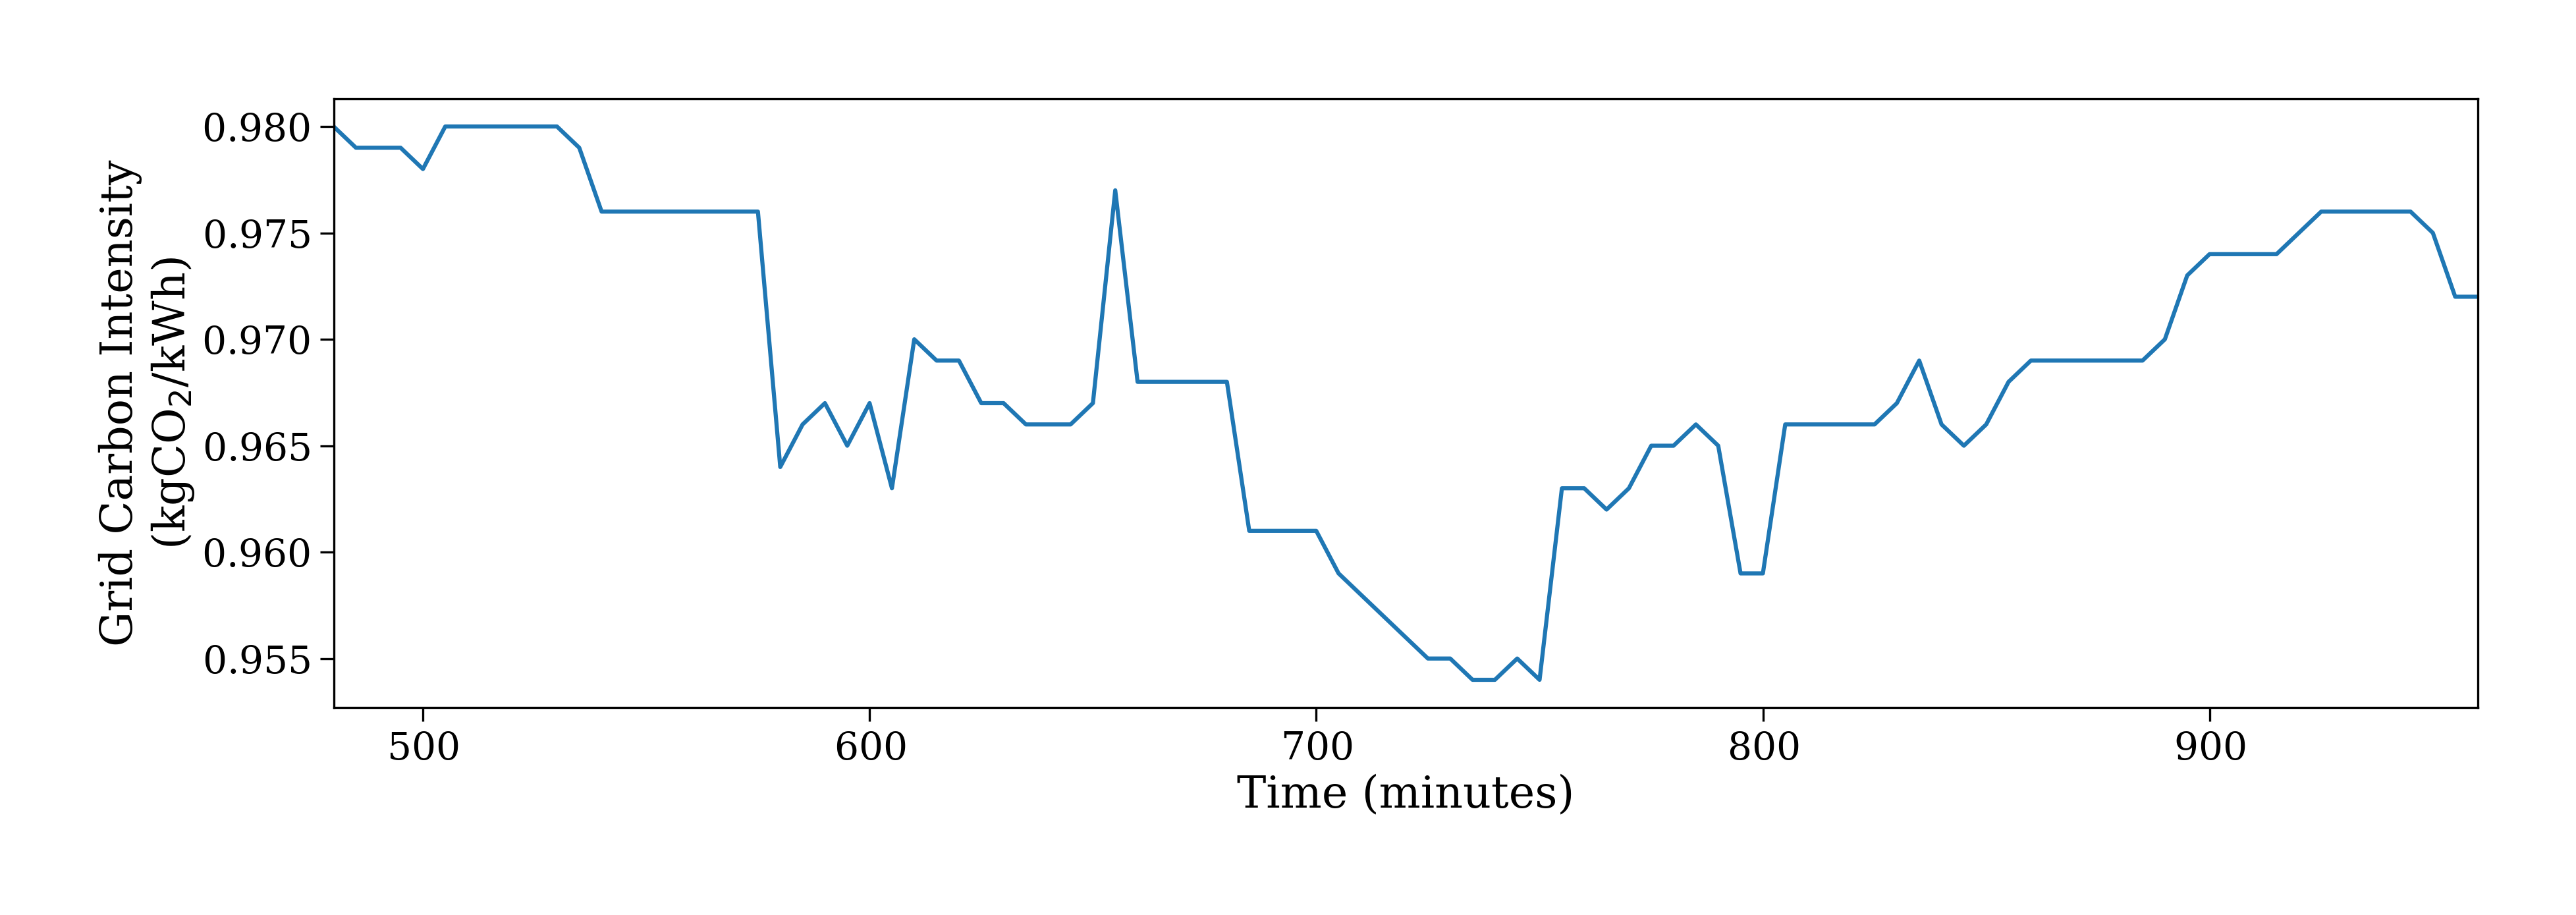

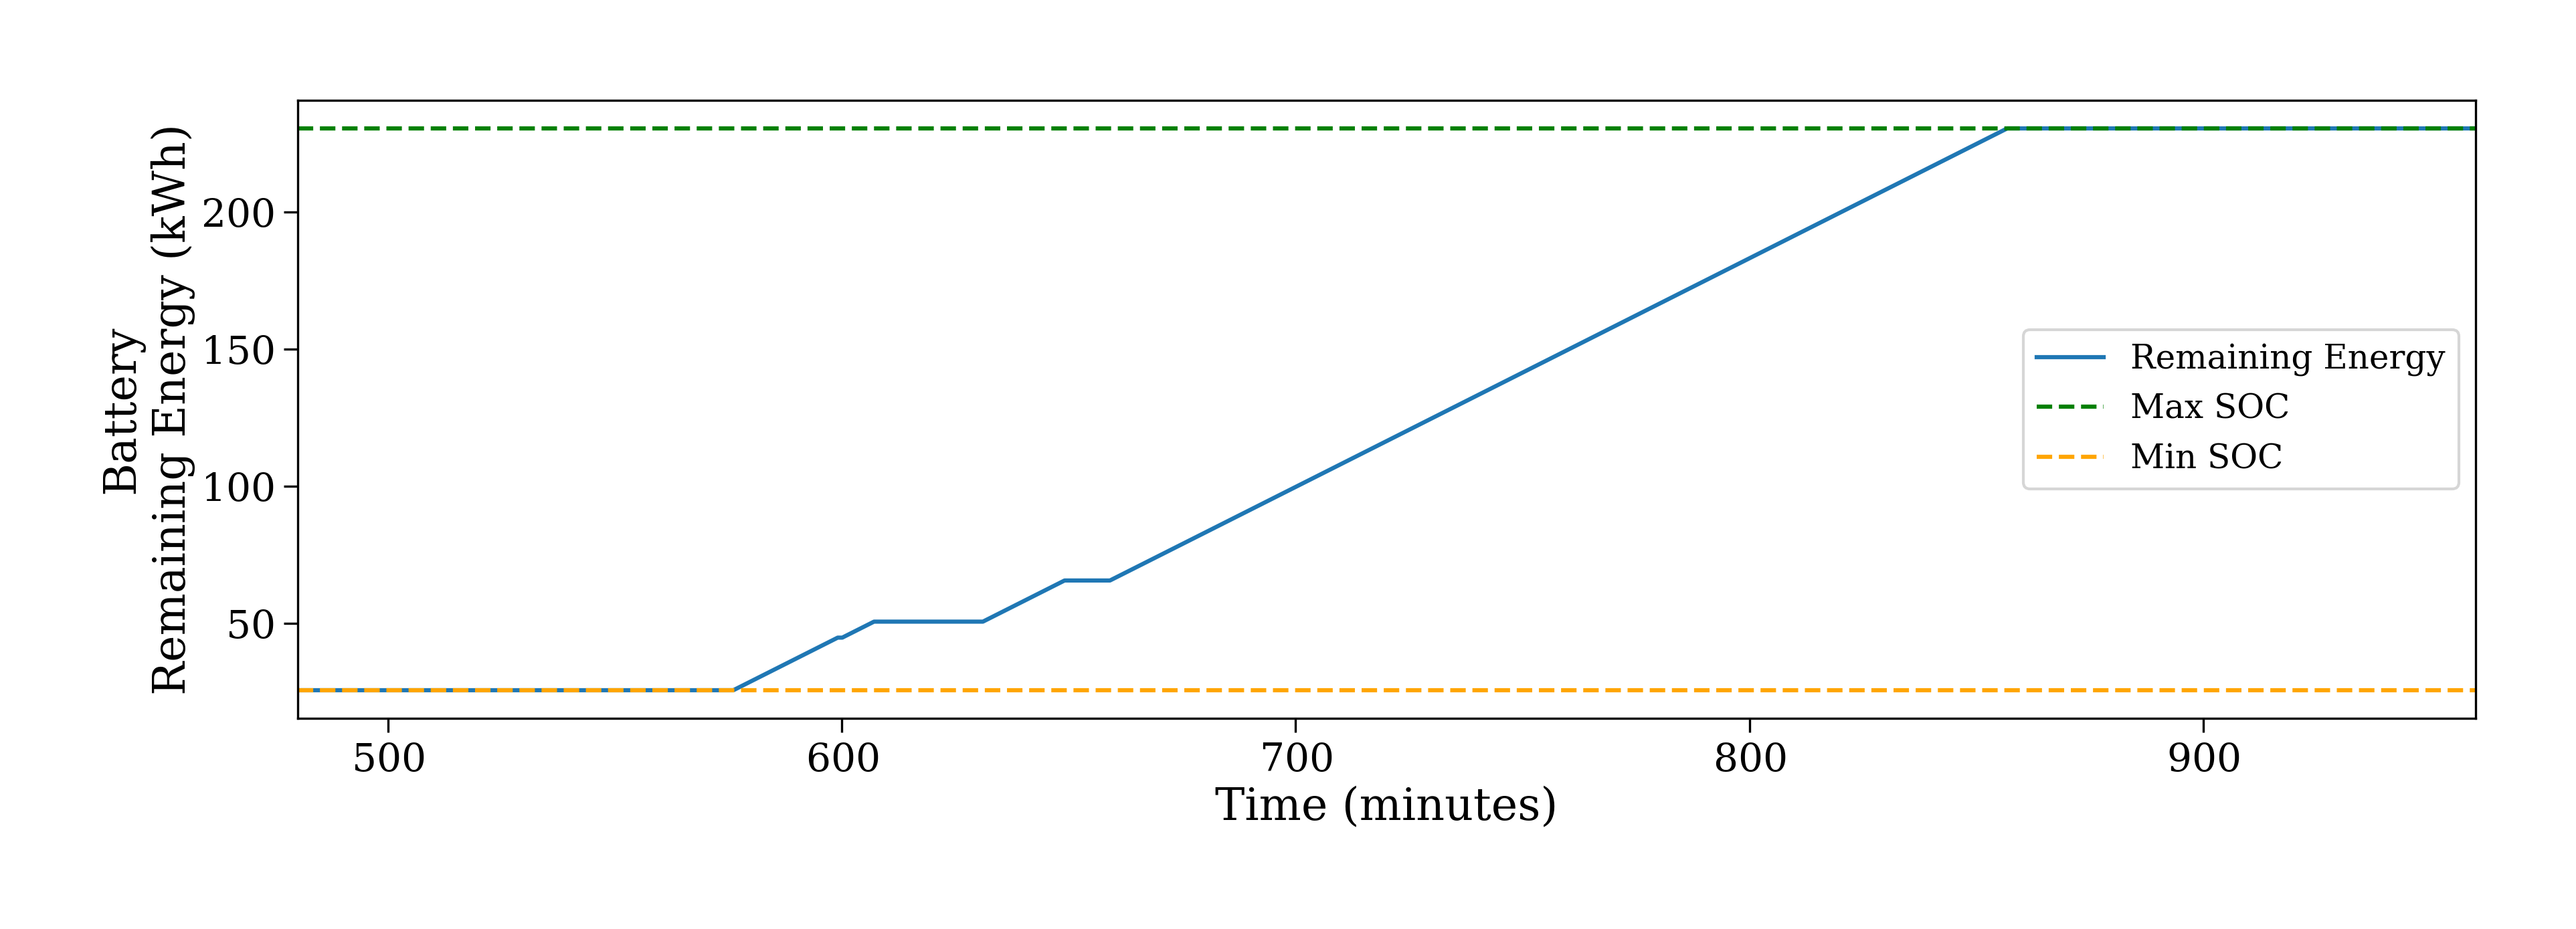

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 0, 50, 50, 50, 50, 50, 50, 50, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,

In [22]:
# Define parameters
eta_c = 0.9  # charging efficiency
eta_d = 0.5  # discharging efficiency
lambd = 0.18  # weight for carbon intensity
C_deg = 0.01  # degradation cost coefficient
SOC_min = 0.1 * battery_capacity  # minimum SOC
SOC_max = 0.9 * battery_capacity  # maximum SOC
max_charge_power = 50  # kW, maximum charging power
max_discharge_power = 50  # kW, maximum discharging power
C_c_max = 1000  # kVA, maximum capacity of the transformer
delta_t = 1  # minutes, time step size


n = T
def min_cost_path_with_bounds(combined_price):
    target = SOC_target
    max_sum_allowed = SOC_target
    min_sum_allowed = 0
    dp = {0: (0, [])}
    cumulative_costs = [0] * n  # Track cumulative costs

    for i in range(len(combined_price)):
        price = combined_price[i]
        new_dp = {}
        for current_sum, (cost, path) in dp.items():
#             for action in np.arange(-max_discharge_power,max_charge_power+1):
            for action in [-50,0,50]:
                new_sum = round(current_sum + action/60,1)
                if not (min_sum_allowed <= new_sum <= max_sum_allowed):
                    continue
                if action >= 0:
                    new_cost = cost + action * price * eta_c
                elif action < 0:
                    new_cost = cost + action * price * eta_d

                new_path = path + [action]
                if new_sum not in new_dp or new_dp[new_sum][0] > new_cost:
                    new_dp[new_sum] = (new_cost, new_path)
                    if i < n:
                        cumulative_costs[i] = new_cost  # Update cumulative cost for this timestep
        dp = new_dp
#     print(list(dp.keys()))
    return dp[target][1] if target in dp else None, cumulative_costs


# Example usage with random prices (replace this with actual prices)
total_cost_delta = p_t[start_idx:end_idx + 1] + lambd*g_t[start_idx:end_idx + 1]

optimal_path, cumulative_costs = min_cost_path_with_bounds(total_cost_delta)
print("Optimal path to minimize cost:", optimal_path)


print("Sum of all actions:", sum(optimal_path))

print('Cumulative Cost:', cumulative_costs[-1])

SOC_scheduled = [SOC_min + sum(optimal_path[:i+1])*1/60 for i in range(len(optimal_path))]
time_array = [charge_window_start + t * delta_t for t in range(T + 1)]
for i in range(len(SOC_scheduled)):

    if SOC_scheduled[i]>SOC_max:
        remaining_charge = SOC_max - SOC_scheduled[i-1]
        remaining_charge_time = 60 * remaining_charge/max_charge_power
        if remaining_charge_time!=0:
            time_array.insert(i,time_array[i-1] + remaining_charge_time)
            SOC_scheduled.insert(i,SOC_scheduled[i-1] + max_charge_power*remaining_charge_time/60)
        else:
            SOC_scheduled[i] = SOC_scheduled[i-1]
SOC_scheduled[-1] = SOC_scheduled[-2]

print(len(SOC_scheduled))
print(len(time_array))

# Plotting and saving figures
def save_plot(fig, filename):
    fig.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close(fig)

# Electricity Price
fig1, ax1 = plt.subplots(figsize=(14, 4))
ax1.plot(time_index[start_idx:end_idx+1], electricity_price[start_idx:end_idx+1], label='Electricity Price')
ax1.set_xlim(charge_window_start, charge_window_end)
ax1.set_ylabel('Electricity Price\n($/kWh)')
ax1.set_xlabel('Time (minutes)')
plt.show()

# Grid Carbon Intensity
fig2, ax2 = plt.subplots(figsize=(14, 4))
ax2.plot(time_index[start_idx:end_idx+1], carbon_intensity[start_idx:end_idx+1], label='Grid Carbon Intensity')
ax2.set_xlim(charge_window_start, charge_window_end)
ax2.set_ylabel('Grid Carbon Intensity\n(kgCO$_2$/kWh)')
ax2.set_xlabel('Time (minutes)')
plt.show()

# Battery Remaining Energy
fig3, ax3 = plt.subplots(figsize=(14, 4))
ax3.plot(time_array, SOC_scheduled, label='Remaining Energy')
ax3.axhline(y=SOC_max, color='g', linestyle='--', label='Max SOC')
ax3.axhline(y=SOC_min, color='orange', linestyle='--', label='Min SOC')
ax3.set_xlim(charge_window_start, charge_window_end)
ax3.set_ylabel('Battery\nRemaining Energy (kWh)')
ax3.set_xlabel('Time (minutes)')
ax3.legend()
plt.show()
save_plot(fig3, 'charge_scheduling_window_2_soc.png')

# # Plot cumulative cost
# plt.figure(figsize=(14, 4))
# plt.plot(cumulative_costs, label='Cumulative Cost', color='blue')
# plt.title('Cumulative Cost Over Time')
# plt.ylabel('Cumulative Cost')
# plt.xlabel('Time Step')
# plt.legend()
# plt.grid(True)
# plt.show()

print(optimal_path)

In [23]:
print("Time List:\n", time_list)
print("Augmented Energy List:\n", augmented_energy_list)
print("Remaining Energy List:\n", remaining_energy_list)
print("Charge Windows:\n",charge_windows)

Time List:
 [0, 28.9982971, 48.9982971, 104.91509930000001, 134.9150993, 162.1997676, 202.1997676, 254.01490330000001, 284.0149033, 340.0661595, 820.0661595]
Augmented Energy List:
 [0.0, 38.0523265, 38.0523265, 121.601733, 121.601733, 157.93771859999998, 78.09409849999997, 138.01603179999998, 138.01603179999998, 204.8, 0]
Remaining Energy List:
 [230.4, 192.3476735, 192.3476735, 108.79826700000001, 108.79826700000001, 72.46228140000002, 152.30590150000003, 92.38396820000003, 92.38396820000003, 25.599999999999994, 230.4]
Charge Windows:
 [(162.1997676, 202.1997676), (340.0661595, 820.0661595)]


In [18]:
baselien_d_t = [0]*T
baselien_c_t = [0]*T
for i in range(len(baselien_c_t)):
    for (a,b) in charge_windows:
        if i > a and i < b:
            baselien_c_t[i] = 50



In [26]:
len(brute_force_c_t)

480

Total Cost from Brute Force Solution: 73.1406676350001
Total Cost from MILP Solution: 69.48251757883682
MILP solution has a lower or equal cost compared to the brute-force solution.


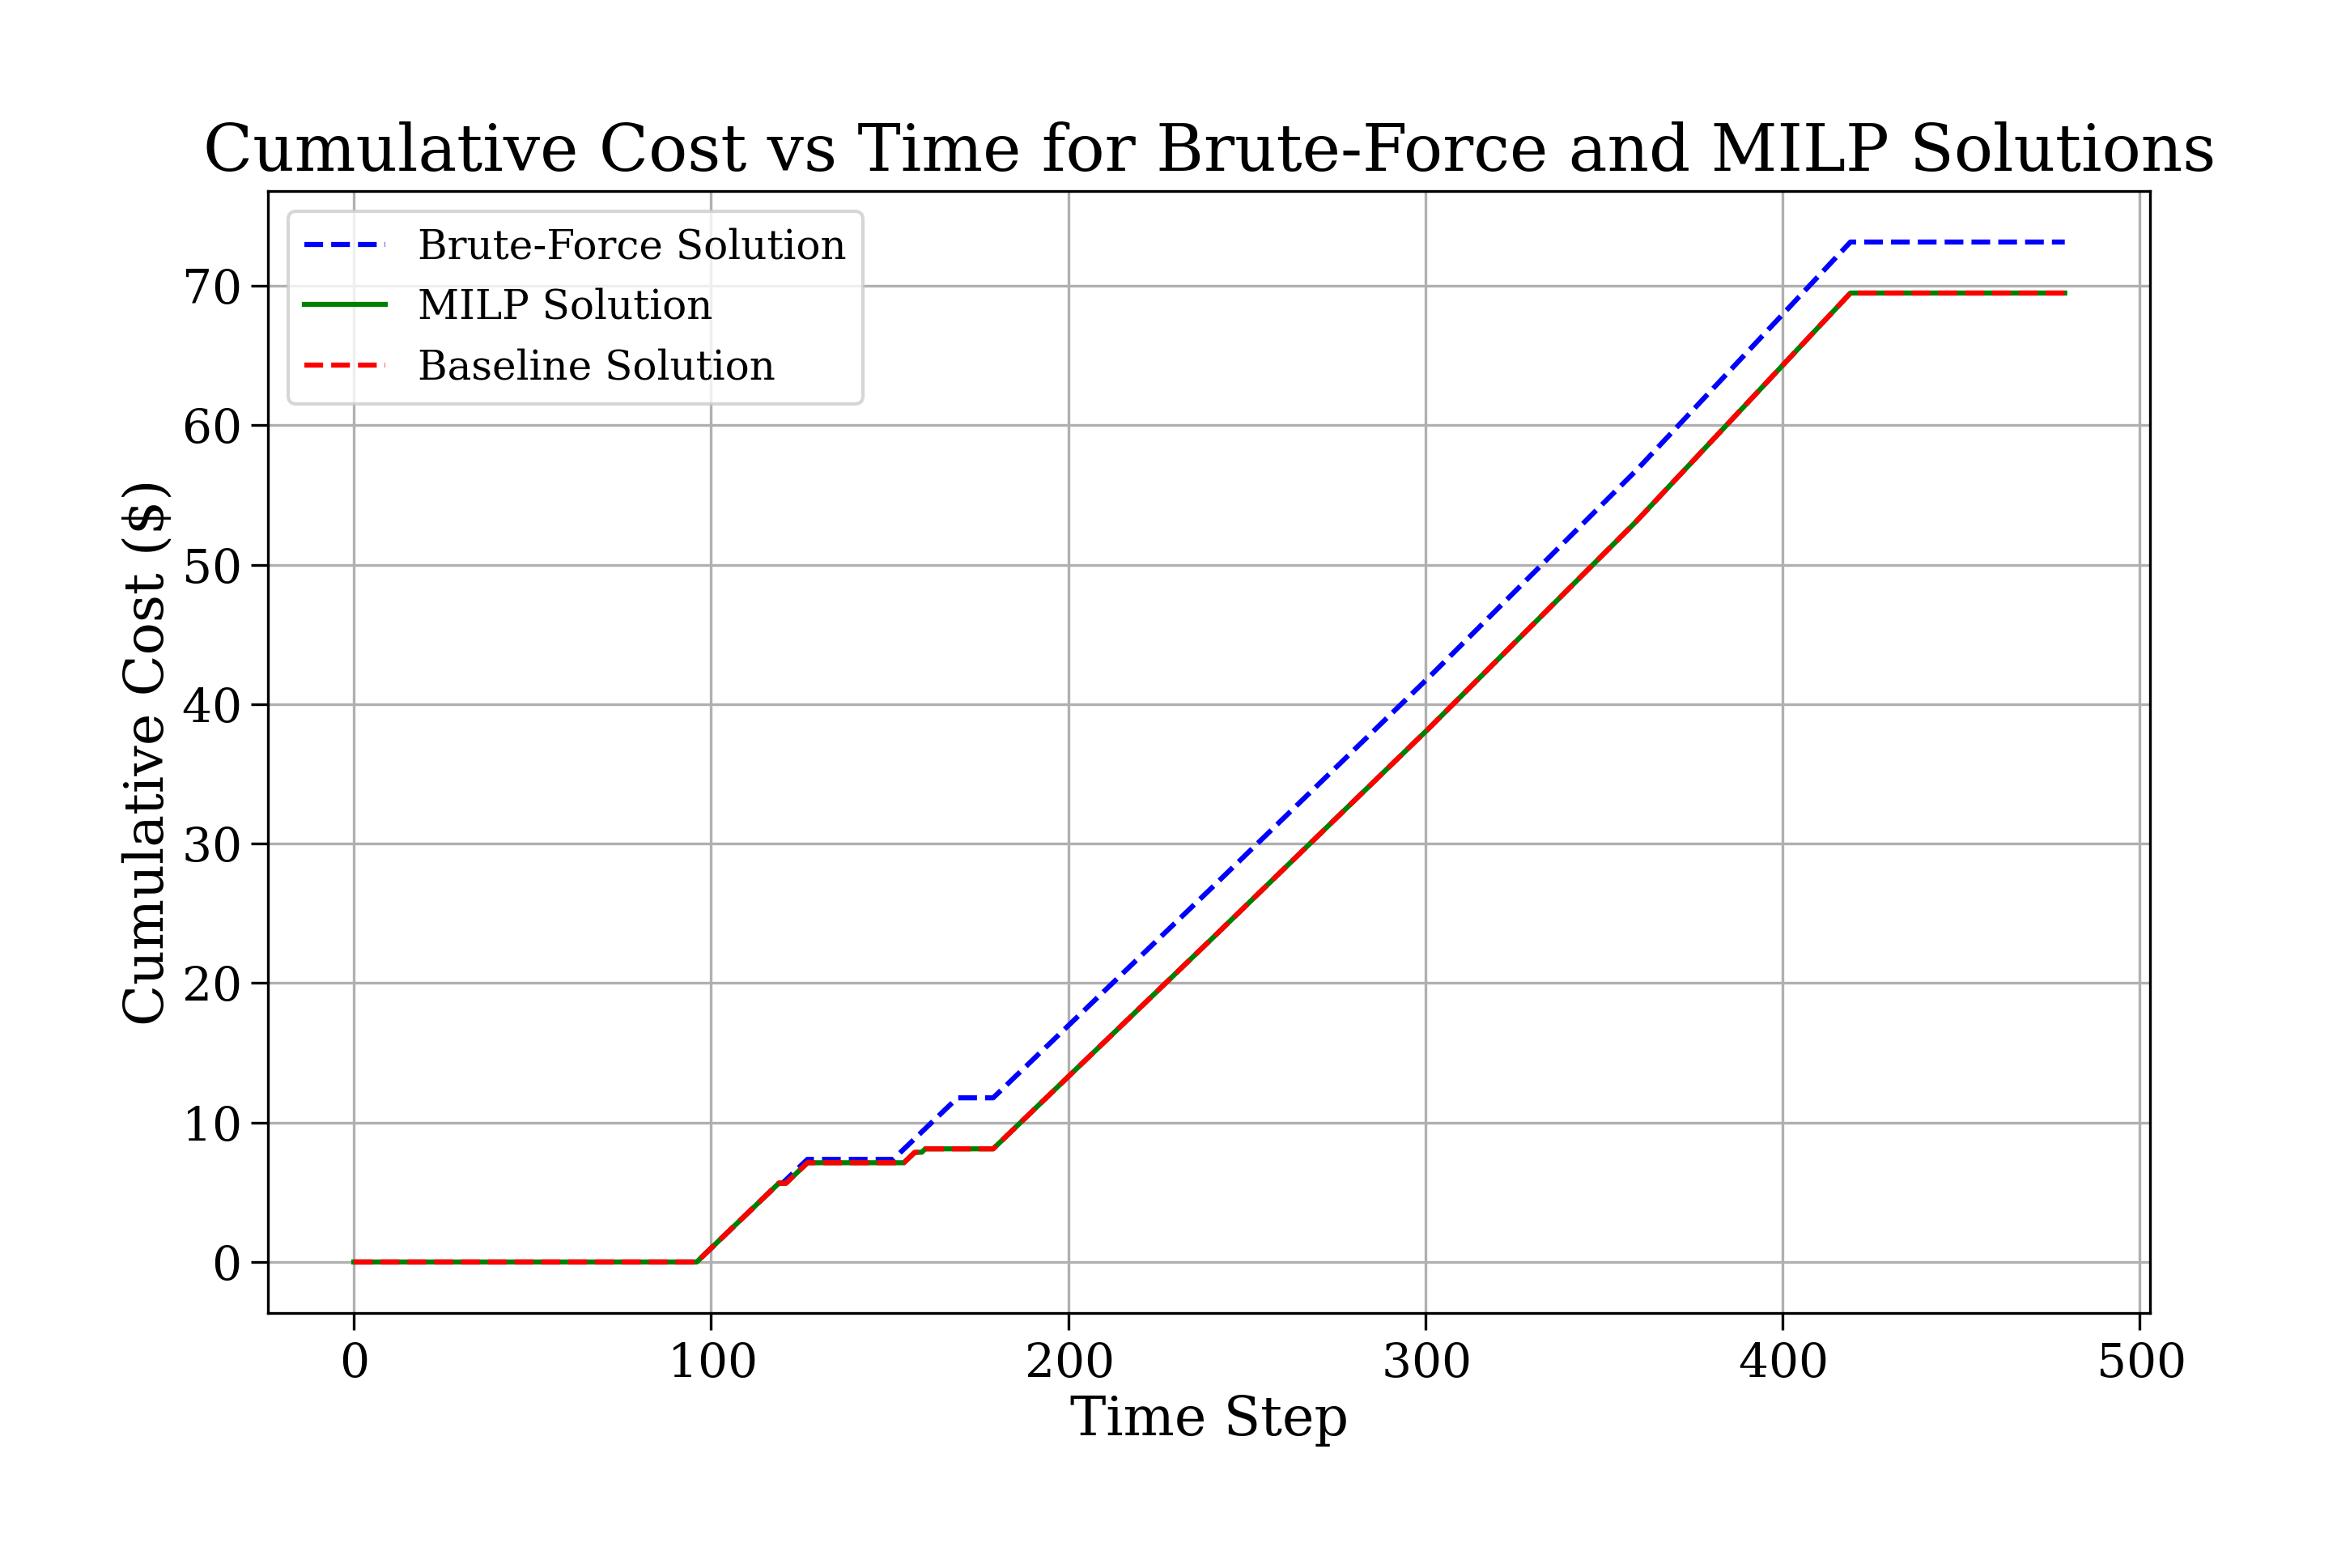

In [24]:
# Assume these are the charging/discharging profiles from the brute-force method
brute_force_c_t = optimal_path[:-1]  # Plug in your brute-force charging profile
brute_force_d_t = [0]*T  # Plug in your brute-force discharging profile

# Ensure that the length of the brute-force profile matches T
assert len(brute_force_c_t) == T
assert len(brute_force_d_t) == T

# Objective function to calculate the cost based on the given profiles
def calculate_total_cost(c_t, d_t, p_t, g_t, eta_c, eta_d, lambd, C_deg, delta_t):
    total_cost = sum([
        (p_t[t] * (c_t[t] * eta_c - d_t[t] * eta_d) + lambd * g_t[t] * (c_t[t] * eta_c - d_t[t] * eta_d)) * (delta_t / 60)
        + C_deg * d_t[t]
        for t in range(T)
    ])
    return total_cost

# Calculate the total cost for the brute-force solution
brute_force_cost = calculate_total_cost(brute_force_c_t, brute_force_d_t, p_t, g_t, eta_c, eta_d, lambd, C_deg, delta_t)

# Calculate the total cost for the MILP solution (already computed)
milp_cost = calculate_total_cost(optimized_c_t, optimized_d_t, p_t, g_t, eta_c, eta_d, lambd, C_deg, delta_t)

baseline_cost = calculate_total_cost(baselien_c_t, baselien_d_t, p_t, g_t, eta_c, eta_d, lambd, C_deg, delta_t)

# Output the costs for comparison
print(f"Total Cost from Brute Force Solution: {brute_force_cost}")
print(f"Total Cost from MILP Solution: {milp_cost}")

# Compare the two
if brute_force_cost < milp_cost:
    print("Brute-force solution has a lower cost than the MILP solution.")
else:
    print("MILP solution has a lower or equal cost compared to the brute-force solution.")

import matplotlib.pyplot as plt

# Function to calculate cumulative cost at each time step
def calculate_cumulative_cost(c_t, d_t, p_t, g_t, eta_c, eta_d, lambd, C_deg, delta_t):
    cumulative_cost = []
    total_cost = 0
    for t in range(T):
        cost_at_t = (p_t[t] * (c_t[t] * eta_c - d_t[t] * eta_d) + lambd * g_t[t] * (c_t[t] * eta_c - d_t[t] * eta_d)) * (delta_t / 60)
        cost_at_t += C_deg * d_t[t]
        total_cost += cost_at_t
        cumulative_cost.append(total_cost)
    return cumulative_cost


def calculate_electricity_cost(c_t, d_t, p_t, g_t, eta_c, eta_d, lambd, C_deg, delta_t):
    electricity_cost = []
    total_cost = 0
    for t in range(T):
        cost_at_t = (p_t[t] * (c_t[t] * eta_c - d_t[t] * eta_d)) * (delta_t / 60)
        cost_at_t += C_deg * d_t[t]
        total_cost += cost_at_t
        electricity_cost.append(total_cost)
    return electricity_cost

# Calculate cumulative costs for brute-force and MILP solutions
brute_force_cumulative_cost = calculate_cumulative_cost(brute_force_c_t, brute_force_d_t, p_t, g_t, eta_c, eta_d, lambd, C_deg, delta_t)
milp_cumulative_cost = calculate_cumulative_cost(optimized_c_t, optimized_d_t, p_t, g_t, eta_c, eta_d, lambd, C_deg, delta_t)
baseline_cumulative_cost = calculate_cumulative_cost(optimized_c_t, optimized_d_t, p_t, g_t, eta_c, eta_d, lambd, C_deg, delta_t)

brute_force_electricity_cost = calculate_electricity_cost(brute_force_c_t, brute_force_d_t, p_t, g_t, eta_c, eta_d, lambd, C_deg, delta_t)
milp_electricity_cost = calculate_electricity_cost(optimized_c_t, optimized_d_t, p_t, g_t, eta_c, eta_d, lambd, C_deg, delta_t)
baseline_electricity_cost = calculate_electricity_cost(baselien_c_t, baselien_d_t, p_t, g_t, eta_c, eta_d, lambd, C_deg, delta_t)

# Plot the cumulative cost vs time
time_steps = list(range(T))

plt.figure(figsize=(10, 6))
plt.plot(time_steps, brute_force_cumulative_cost, label='Brute-Force Solution', color='blue', linestyle='--')
plt.plot(time_steps, milp_cumulative_cost, label='MILP Solution', color='green', linestyle='-')
plt.plot(time_steps, baseline_cumulative_cost, label='Baseline Solution', color='red', linestyle='--')

plt.xlabel('Time Step')
plt.ylabel('Cumulative Cost ($)')
plt.title('Cumulative Cost vs Time for Brute-Force and MILP Solutions')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


In [90]:
# brute_force_c_t
optimized_c_t

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 50.0,
 50.0,
 50.0,
 50.0,
 50.0,
 50.0,
 50.0,
 50.0,
 50.0,
 50.0,
 50.0,
 50.0,
 50.0,
 50.0,
 50.0,
 50.0,
 50.0,
 50.0,
 50.0,
 50.0,
 50.0,
 50.0,
 50.0,
 0.0,
 0.0,
 50.0,
 50.0,
 50.0,
 50.0,
 50.0,
 50.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 50.0,
 50.0,
 50.0,
 3.3333333,
 0.0,
 5

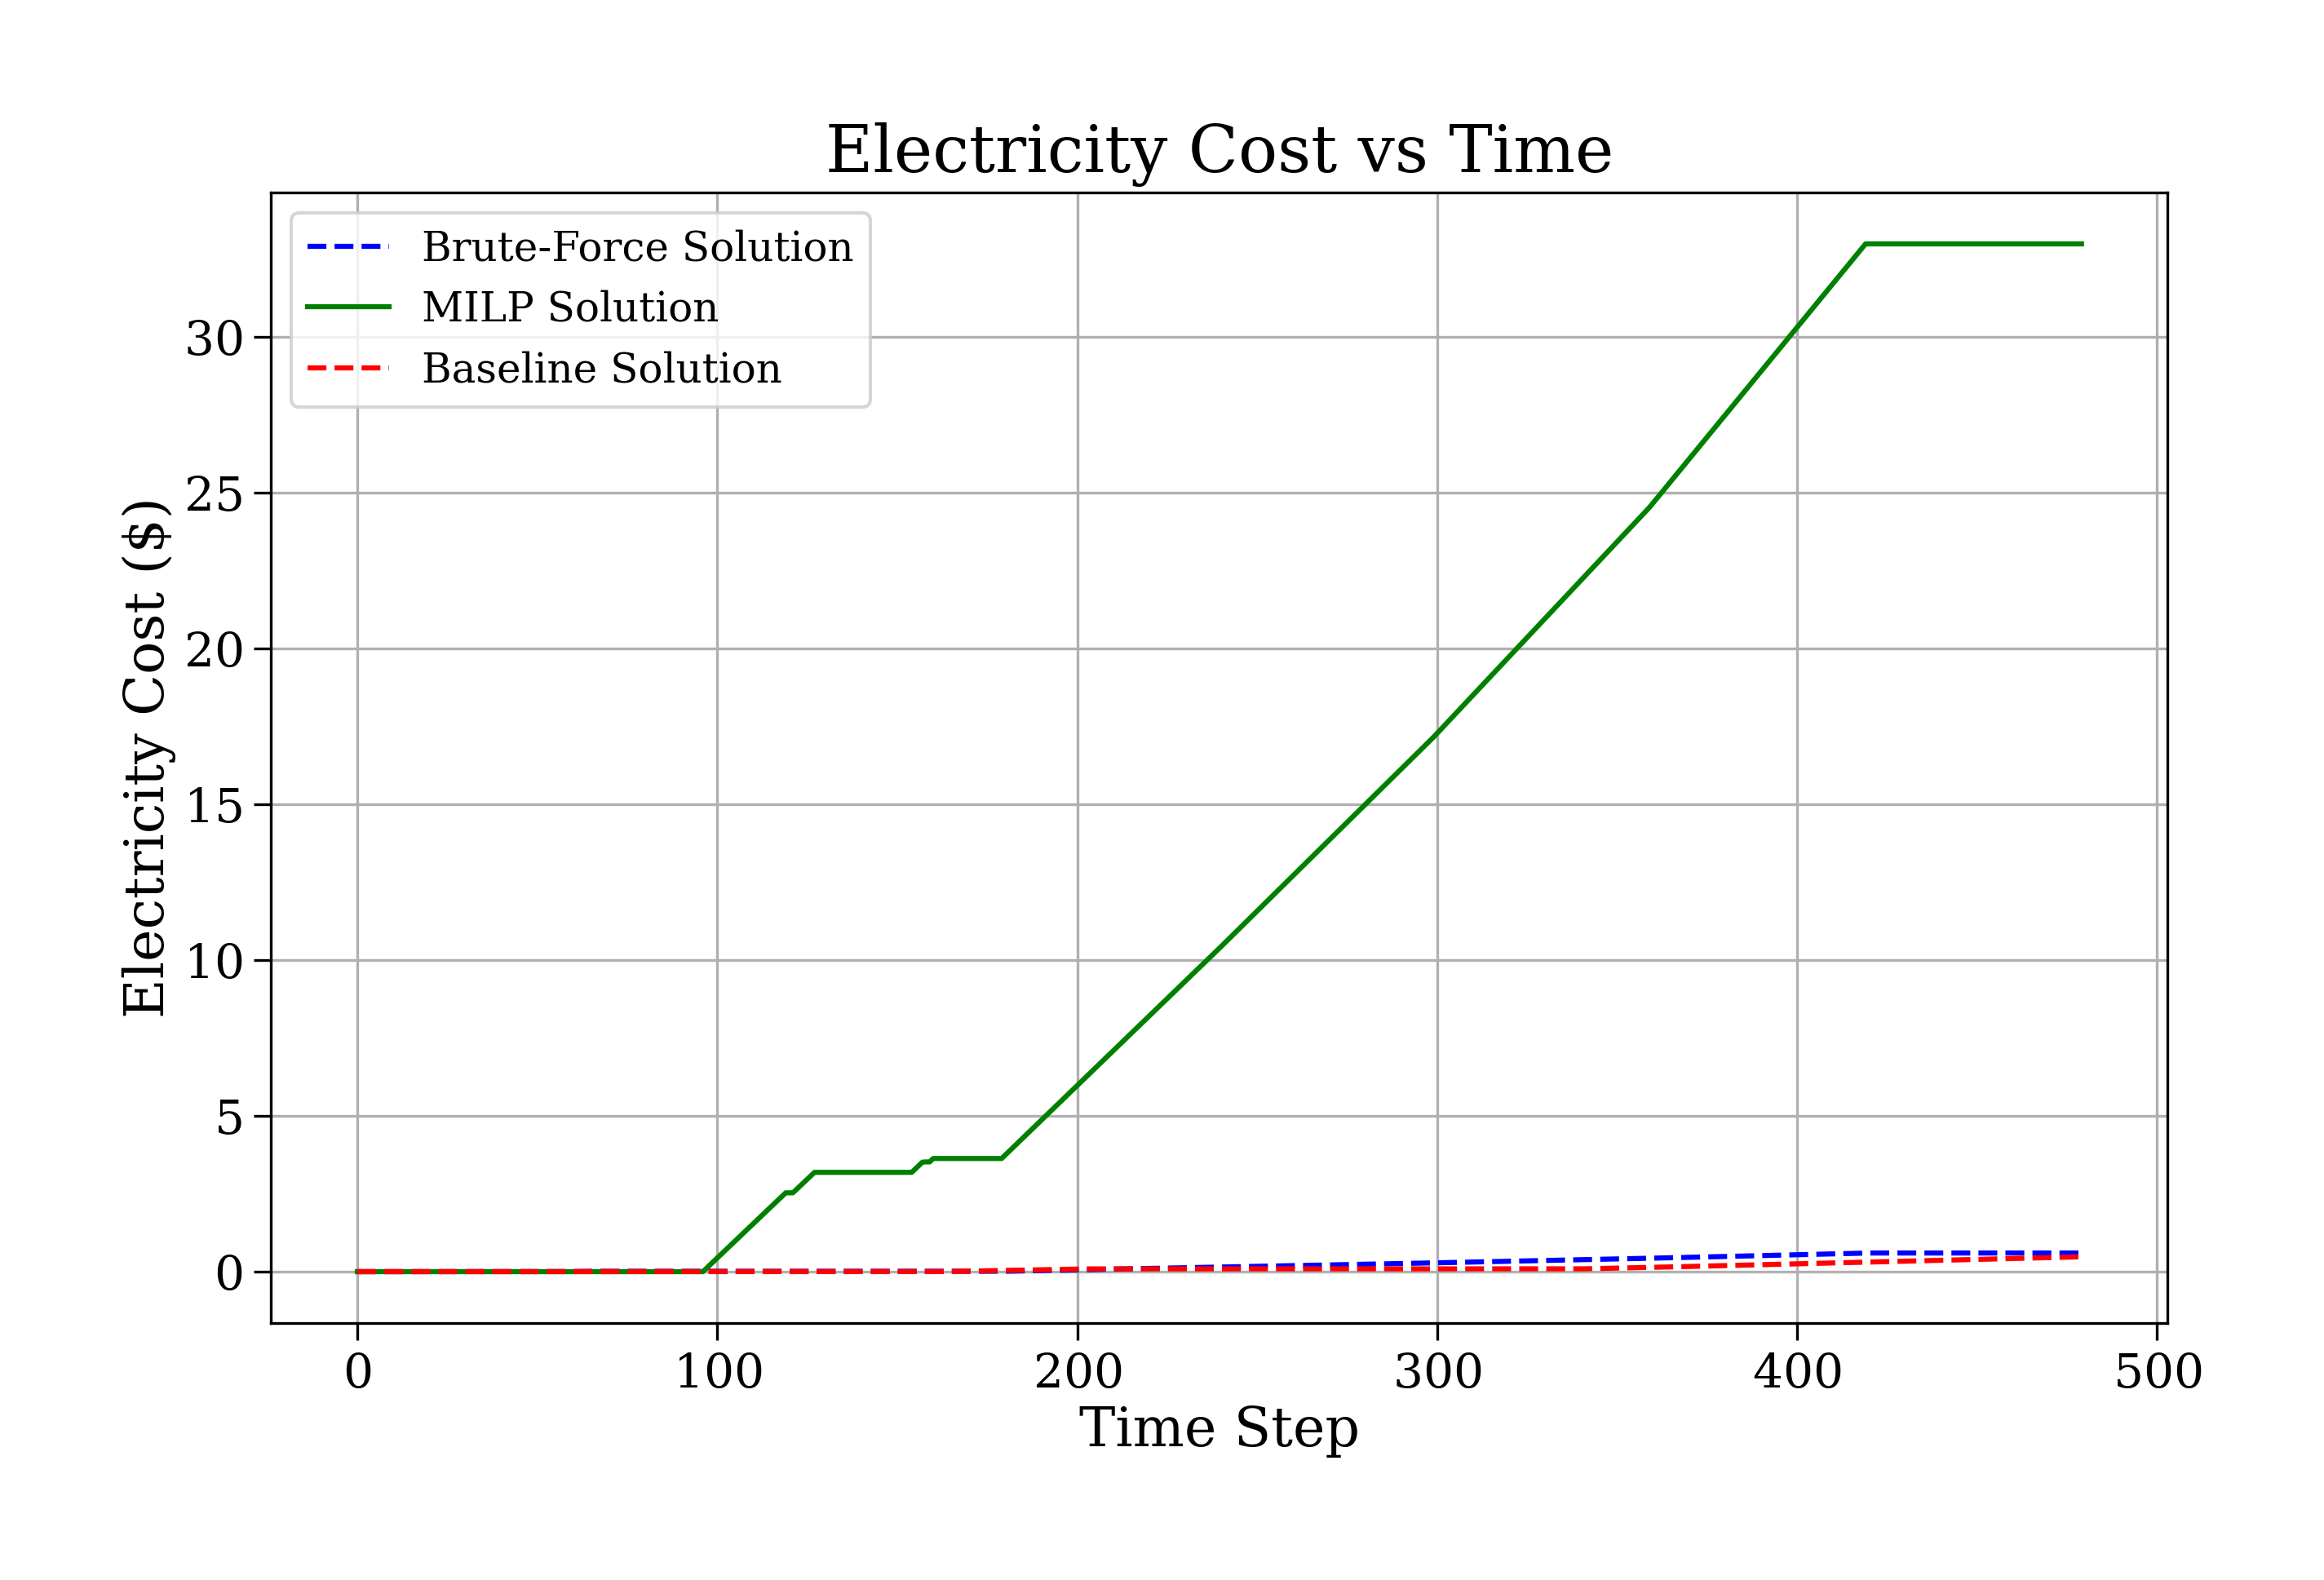

In [89]:
time_steps = list(range(T))

plt.figure(figsize=(10, 6))
plt.plot(time_steps, brute_force_electricity_cost, label='Brute-Force Solution', color='blue', linestyle='--')
plt.plot(time_steps, milp_electricity_cost, label='MILP Solution', color='green', linestyle='-')
plt.plot(time_steps, baseline_electricity_cost, label='Baseline Solution', color='red', linestyle='--')

plt.xlabel('Time Step')
plt.ylabel('Electricity Cost ($)')
plt.title('Electricity Cost vs Time')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

## IGNORE

In [21]:
'''
IGNORE

'''

# n = T

# time_array = [charge_window_start + t * delta_t for t in range(T + 1)]

# def min_cost_path_with_bounds(combined_price):
#     target = SOC_target
#     max_sum_allowed = SOC_target
#     min_sum_allowed = 0
#     dp = {0: (0, [], )}
#     cumulative_costs = [0] * n  # Track cumulative costs

#     for i in range(len(combined_price)):
#         price = combined_price[i]
#         new_dp = {}
#         for current_sum, (cost, path) in dp.items():
# #             for action in np.arange(-max_discharge_power,max_charge_power+1):
#             for action in [-50,0,50]:
#                 new_sum = round(current_sum + action/60,1)
#                 if min_sum_allowed >= new_sum:
#                     continue

#                 if new_sum >= max_sum_allowed:
#                     # remaining charge to reach max allowed
#                     remainder_charge = max_sum_allowed - current_sum

#                     # time required for remaining charge in minutes
#                     remainder_charge_time = 60*remainder_charge/action

#                     #adding additional data point in time_array


#                 if action >= 0:
#                     new_cost = cost + action * price * eta_c
#                 elif action < 0:
#                     new_cost = cost + action * price * eta_d

#                 new_path = path + [action]
#                 if new_sum not in new_dp or new_dp[new_sum][0] > new_cost:
#                     new_dp[new_sum] = (new_cost, new_path)
#                     if i < n:
#                         cumulative_costs[i] = new_cost  # Update cumulative cost for this timestep
#         dp = new_dp
# #     print(list(dp.keys()))
#     return dp[target][1] if target in dp else None, cumulative_costs


# # Example usage with random prices (replace this with actual prices)
# total_cost_delta = p_t[start_idx:end_idx + 1] + lambd*g_t[start_idx:end_idx + 1]

# optimal_path, cumulative_costs = min_cost_path_with_bounds(total_cost_delta)
# print("Optimal path to minimize cost:", optimal_path)


# print("Sum of all actions:", sum(optimal_path))

# # Electricity Price
# fig1, ax1 = plt.subplots(figsize=(14, 4))
# ax1.plot(time_index[start_idx:end_idx+1], electricity_price[start_idx:end_idx+1], label='Electricity Price')
# ax1.set_xlim(charge_window_start, charge_window_end)
# ax1.set_ylabel('Electricity Price\n($/kWh)')
# ax1.set_xlabel('Time (minutes)')
# plt.show()

# # Grid Carbon Intensity
# fig2, ax2 = plt.subplots(figsize=(14, 4))
# ax2.plot(time_index[start_idx:end_idx+1], carbon_intensity[start_idx:end_idx+1], label='Grid Carbon Intensity')
# ax2.set_xlim(charge_window_start, charge_window_end)
# ax2.set_ylabel('Grid Carbon Intensity\n(kgCO$_2$/kWh)')
# ax2.set_xlabel('Time (minutes)')
# plt.show()

# # Battery Remaining Energy
# fig3, ax3 = plt.subplots(figsize=(14, 4))
# ax3.plot([charge_window_start + t * delta_t for t in range(T + 1)], [SOC_min + sum(optimal_path[:i+1])*1/60 for i in range(len(optimal_path))], label='Remaining Energy')
# ax3.axhline(y=SOC_max, color='g', linestyle='--', label='Max SOC')
# ax3.axhline(y=SOC_min, color='orange', linestyle='--', label='Min SOC')
# ax3.set_xlim(charge_window_start, charge_window_end)
# ax3.set_ylabel('Battery\nRemaining Energy (kWh)')
# ax3.set_xlabel('Time (minutes)')
# ax3.legend()
# plt.show()

# # # Plot cumulative cost
# # plt.figure(figsize=(14, 4))
# # plt.plot(cumulative_costs, label='Cumulative Cost', color='blue')
# # plt.title('Cumulative Cost Over Time')
# # plt.ylabel('Cumulative Cost')
# # plt.xlabel('Time Step')
# # plt.legend()
# # plt.grid(True)
# # plt.show()

'\nIGNORE\n\n'

Optimal path to minimize cost: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

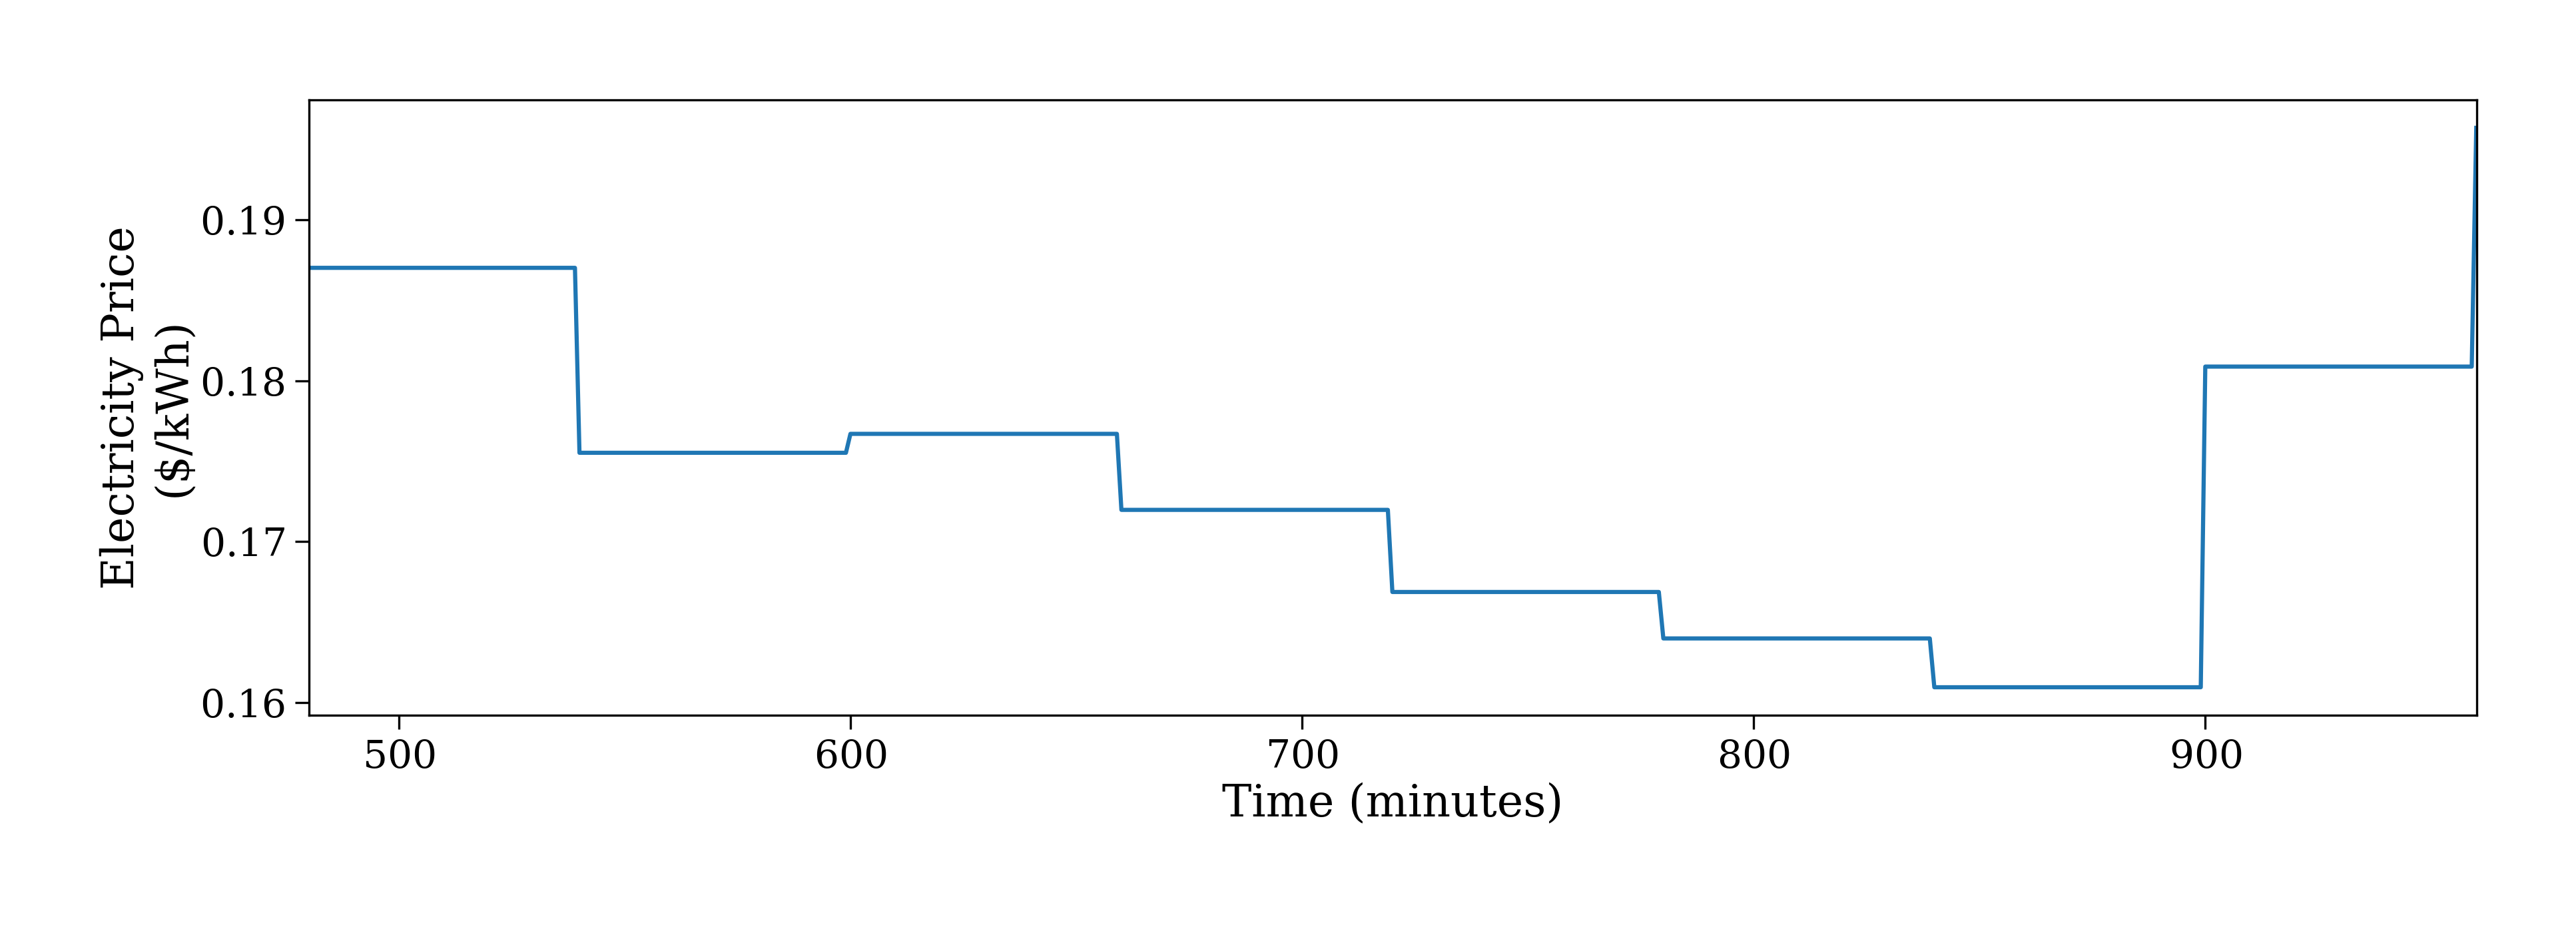

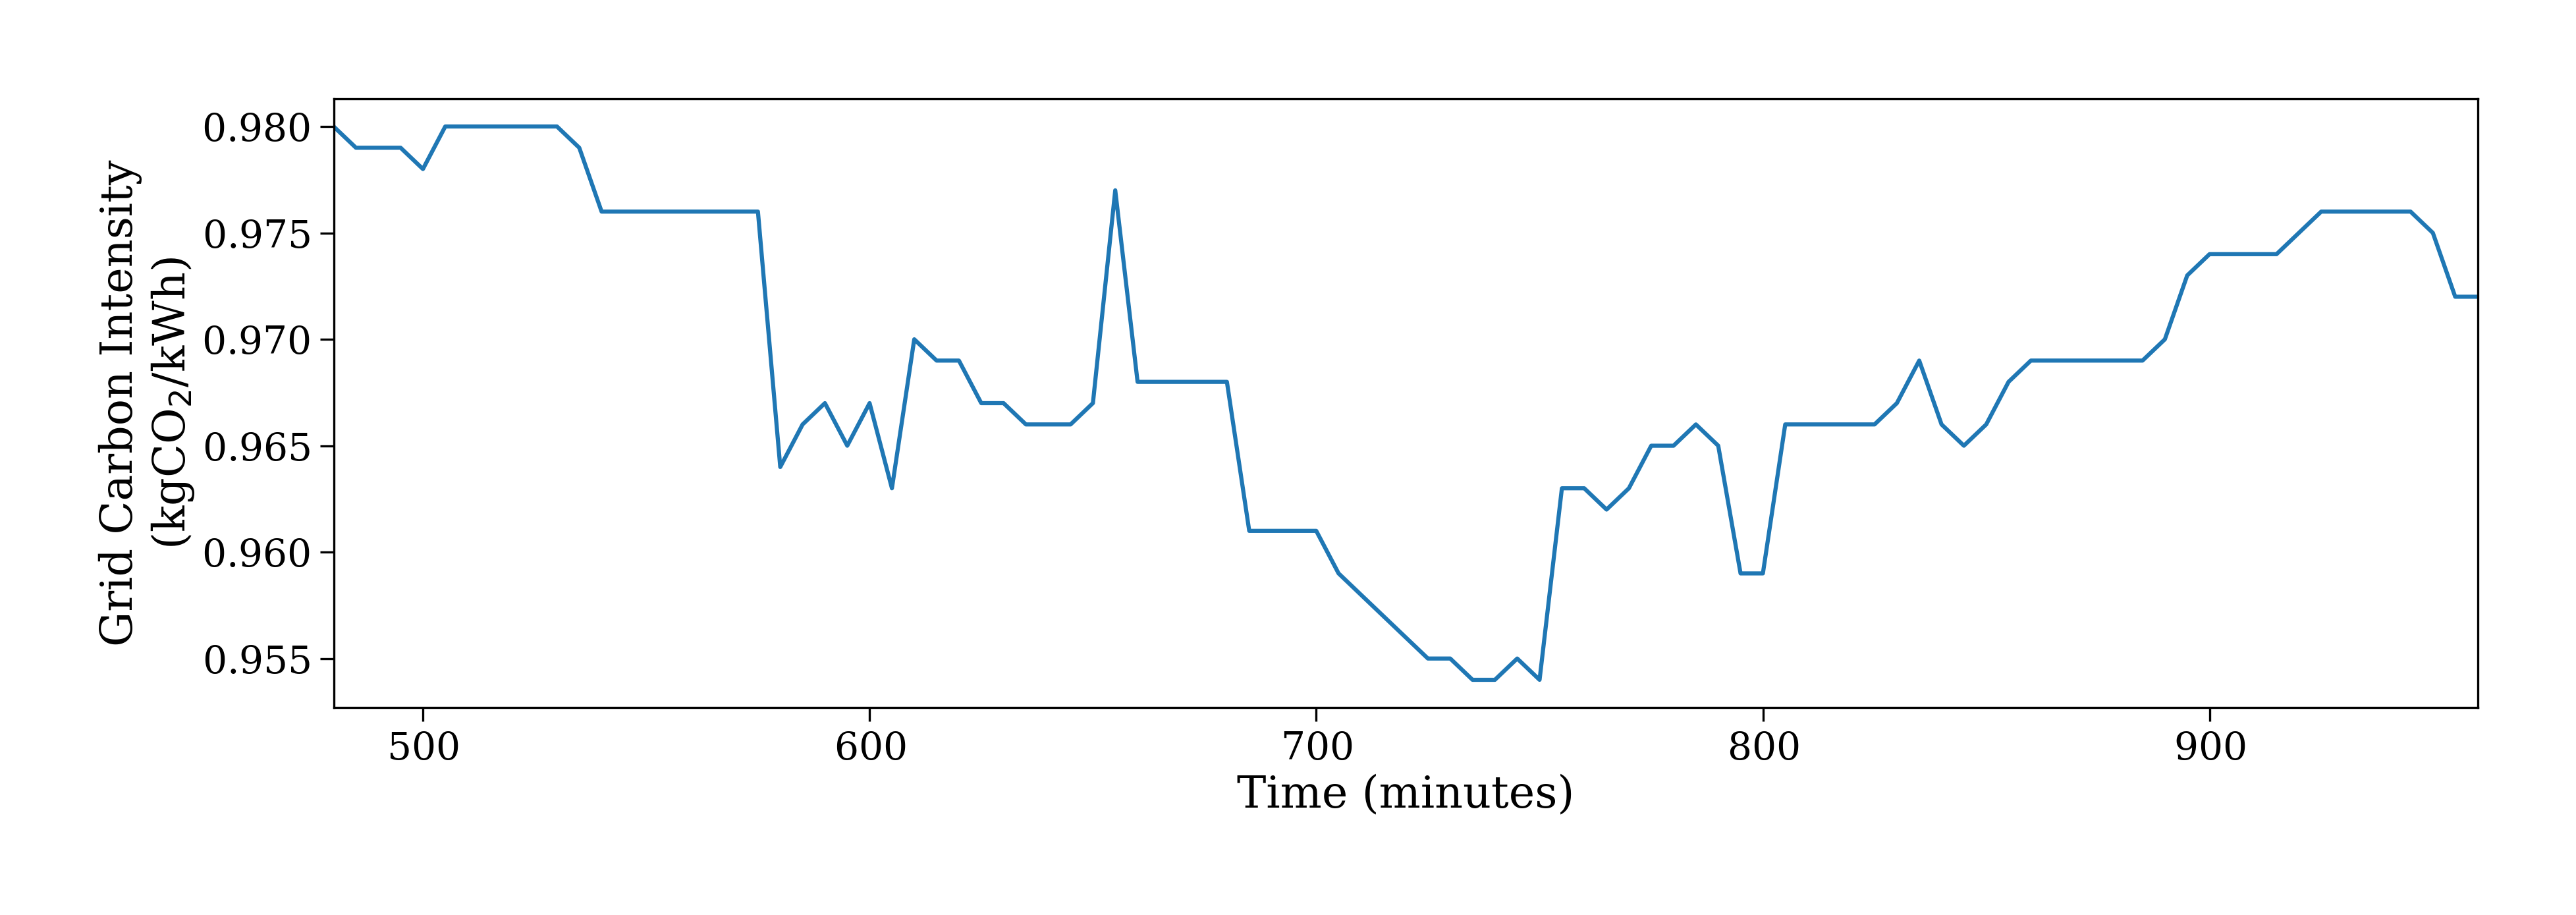

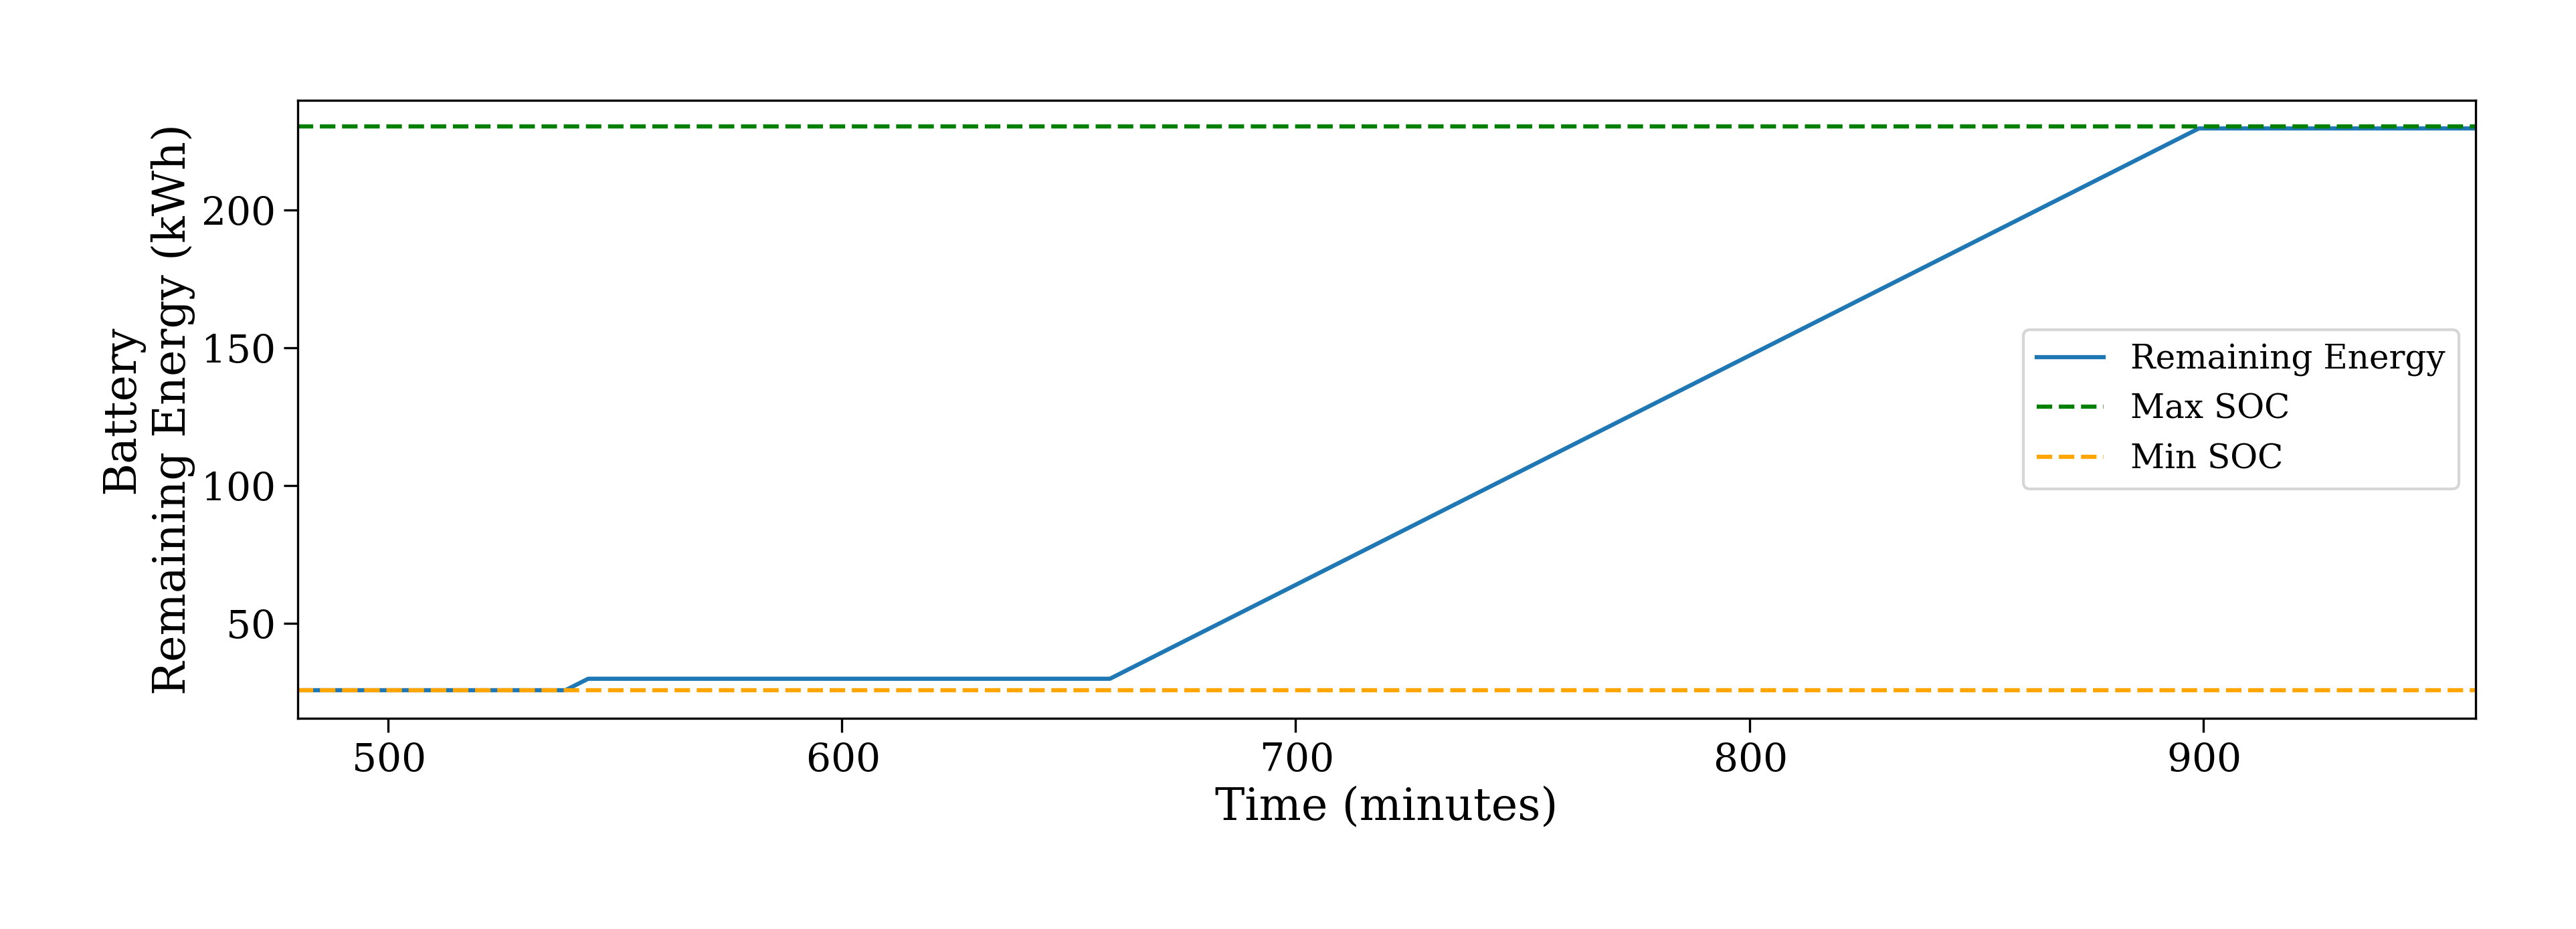

In [22]:
lambd = 0
n = T
def min_cost_path_with_bounds(electricity_price):
    target = min_charging_steps
    max_sum_allowed = math.floor((SOC_max-SOC_init)/max_charge_power/(delta_t/60)) # +1?
    if (max_discharge_power):
        min_sum_allowed = min(0,-math.floor((SOC_init-SOC_min)/max_discharge_power/(delta_t/60)))
    else:
        min_sum_allowed = 0
    dp = {0: (0, [])}
    cumulative_costs = [0] * n  # Track cumulative costs

    for i in range(len(electricity_price)):
        price = electricity_price[i]
        new_dp = {}
        for current_sum, (cost, path) in dp.items():
            for action in [1, 0, -1]:
                new_sum = current_sum + action
                if not (min_sum_allowed <= new_sum <= max_sum_allowed):
                    continue
                if action == 1:
                    new_cost = cost + action * price * eta_c
                elif action == -1:
                    new_cost = cost + action * price * eta_d
                else:
                    new_cost = cost
                new_path = path + [action]
#                 print(new_path)
#                 time.sleep(0.2)
                if new_sum not in new_dp or new_dp[new_sum][0] > new_cost:
                    new_dp[new_sum] = (new_cost, new_path)
                    if i < n:
                        cumulative_costs[i] = new_cost  # Update cumulative cost for this timestep
#                     print(new_dp)
#                     print('\n')
#                 if new_sum==0:
#                     if new_cost<0:
#                         print(new_dp[new_sum])
#                     if new_path[0]==-1:
#                         print(new_path, new_cost)

        dp = new_dp
#     print(dp[-1])
#     plt.plot(dp[-1][1])
    return dp[target][1] if target in dp else None, cumulative_costs


# Example usage with random prices (replace this with actual prices)
total_cost_delta = p_t[start_idx:end_idx + 1] + lambd*g_t[start_idx:end_idx + 1]

optimal_path, cumulative_costs = min_cost_path_with_bounds(total_cost_delta)
print("Optimal path to minimize cost:", optimal_path)


print("Sum of all actions:", sum(optimal_path))

print('Cumulative Cost:', cumulative_costs[-1])


# Electricity Price
fig1, ax1 = plt.subplots(figsize=(14, 4))
ax1.plot(time_index[start_idx:end_idx+1], electricity_price[start_idx:end_idx+1], label='Electricity Price')
ax1.set_xlim(charge_window_start, charge_window_end)
ax1.set_ylabel('Electricity Price\n($/kWh)')
ax1.set_xlabel('Time (minutes)')
plt.show()

# Grid Carbon Intensity
fig2, ax2 = plt.subplots(figsize=(14, 4))
ax2.plot(time_index[start_idx:end_idx+1], carbon_intensity[start_idx:end_idx+1], label='Grid Carbon Intensity')
ax2.set_xlim(charge_window_start, charge_window_end)
ax2.set_ylabel('Grid Carbon Intensity\n(kgCO$_2$/kWh)')
ax2.set_xlabel('Time (minutes)')
plt.show()

# Battery Remaining Energy
fig3, ax3 = plt.subplots(figsize=(14, 4))
ax3.plot([charge_window_start + t * delta_t for t in range(T + 1)], [SOC_min + sum(optimal_path[:i+1])*50*1/60 for i in range(len(optimal_path))], label='Remaining Energy')
ax3.axhline(y=SOC_max, color='g', linestyle='--', label='Max SOC')
ax3.axhline(y=SOC_min, color='orange', linestyle='--', label='Min SOC')
ax3.set_xlim(charge_window_start, charge_window_end)
ax3.set_ylabel('Battery\nRemaining Energy (kWh)')
ax3.set_xlabel('Time (minutes)')
ax3.legend()
plt.show()

# # Plot cumulative cost
# plt.figure(figsize=(14, 4))
# plt.plot(cumulative_costs, label='Cumulative Cost', color='blue')
# plt.title('Cumulative Cost Over Time')
# plt.ylabel('Cumulative Cost')
# plt.xlabel('Time Step')
# plt.legend()
# plt.grid(True)
# plt.show()